## Housing Price Prediction for the Australian Market

### Objective:
<span style = "color:green">
    - Build a regression model using regularization to predict the price of the houses
    - Determine which variables are significant in predicting the price of a house and how well they explain the price of the houses
    - Determine the optimal value of lambda for ridge and lasso regression
</span>

### Data understanding and exploration

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the data
housing_df = pd.read_csv('train.csv')
housing_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
# Checking the dimension of the data
housing_df.shape

(1460, 81)

In [4]:
# Checking the variable datatypes and null values
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<span style = "color:green"> It seems that there are a few variables with a lot of missing values. Let's see the column-wise percentage of missing values </span>

In [5]:
# Fetching the percentage of null values in each column
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals.sort_values(ascending = False)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
                 ...    
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
SalePrice       0.000000
Length: 81, dtype: float64

#### Analyzing individual columns to check missing values

**Analyzing column `PoolQC`**
- The value NA for column PoolQC corresponds to the cases where there is no pool. This is interpreted by Pandas as a missing value. Changing NA to NP to indicate No Pool

In [6]:
# Checking the distinct values for the column PoolQC before transformation:
print(housing_df['PoolQC'].value_counts())

# Changing NA in PoolQC to NP (No Pool) and checking the percentage of missing values after that
housing_df[['PoolQC']] = housing_df[['PoolQC']].fillna('NP')

# Checking the distinct values for the column PoolQC after transformation:
print(housing_df['PoolQC'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
PoolQC
NP    1453
Gd       3
Ex       2
Fa       2
Name: count, dtype: int64


MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**As we can see, the variable `PoolQC` is highly imbalanced with most of the houses not having a pool. So, we will create a new binary variable `Pool` to indicate whether a particular house has a pool or not and drop the `PoolQC` variable**

In [7]:
# Creating a binary variable Pool to indicate whether a house has a pool or not
housing_df['Pool'] = housing_df['PoolQC'].map({'Gd': 1, 'Ex': 1, 'Fa': 1, 'NP': 0})
housing_df['Pool'].head()

# Checking the distinct values for the column Pool after transformation:
print(housing_df['Pool'].value_counts())

# Dropping the PoolQC variable
housing_df.drop('PoolQC', axis = 'columns', inplace = True)

# Checking the dimension of the data after the transformation
print(housing_df.shape)

# Fetching the percentage of null values in each column
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals.sort_values(ascending = False)

Pool
0    1453
1       7
Name: count, dtype: int64
(1460, 81)


MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
                 ...    
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
Pool            0.000000
Length: 81, dtype: float64

**Analyzing column `MiscFeature`**
- The value NA for column MiscFeature corresponds to the cases where there is no misc feature. This is interpreted by Pandas as a missing value. Changing NA to NMF to suggest No Misc Feature

In [8]:
# Checking the distinct values for the column MiscFeature before transformation:
print(housing_df['MiscFeature'].value_counts())

# Changing NA in MiscFeature to NMF (No Misc Feature) and checking the percentage of missing values after that
housing_df[['MiscFeature']] = housing_df[['MiscFeature']].fillna('NMF')

# Checking the distinct values for the column MiscFeature after transformation:
print(housing_df['MiscFeature'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64
MiscFeature
NMF     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64


Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**As we can see, the variable `MiscFeature` is highly imbalanced with most of the houses not having a misc feature. So, we will convert it into a binary variable to indicate whether a house has a misc feature or not**

In [9]:
# Converting MiscFeature variable to binary
housing_df['MiscFeature'] = housing_df['MiscFeature'].map({'Shed': 1, 'Gar2': 1, 'Othr': 1, 'TenC': 1, 'NMF': 0})
housing_df['MiscFeature'].head()

# Checking the distinct values for the column PoolQC after transformation:
print(housing_df['MiscFeature'].value_counts())

# Checking the dimension of the data after the transformation
print(housing_df.shape)

# Fetching the percentage of null values in each column
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals.sort_values(ascending = False)

MiscFeature
0    1406
1      54
Name: count, dtype: int64
(1460, 81)


Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
LotFrontage    17.739726
                 ...    
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
Pool            0.000000
Length: 81, dtype: float64

**Analyzing column `Alley`**
- The value NA for column `Alley` corresponds to the cases where there is no alley access. This is interpreted by Pandas as a missing value. Changing NA to NAA to suggest No Alley Access

In [10]:
# Checking the distinct values for the column Alley before transformation:
print(housing_df['Alley'].value_counts())

# Changing NA in Alley to NAA (No Alley Access) and checking the percentage of missing values after that
housing_df[['Alley']] = housing_df[['Alley']].fillna('NAA')

# Checking the distinct values for the column Alley after transformation:
print(housing_df['Alley'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

Alley
Grvl    50
Pave    41
Name: count, dtype: int64
Alley
NAA     1369
Grvl      50
Pave      41
Name: count, dtype: int64


Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**Checking column `Fence`**
- The value NA for column `Fence` corresponds to the cases where there is no fence. This is interpreted by Pandas as a missing value. Changing NA to NF to suggest No Fence

In [11]:
# Checking the distinct values for the column Fence before transformation:
print(housing_df['Fence'].value_counts())

# Changing NA in Fence to NF (No Fence) and checking the percentage of missing values after that
housing_df[['Fence']] = housing_df[['Fence']].fillna('NF')

# Checking the distinct values for the column Fence after transformation:
print(housing_df['Fence'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64
Fence
NF       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: count, dtype: int64


MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**Analyzing column `MasVnrType`**
- The value None for column `MasVnrType` corresponds to the cases where there is no masony veneer. This is interpreted by Pandas as a missing value. Changing None to NMV to suggest No Masony Veneer

In [12]:
# Checking the distinct values for the column MasVnrType before transformation:
print(housing_df['MasVnrType'].value_counts())

# Changing None in MasVnrType to NMV (No Masonry Veneer) and checking the percentage of missing values after that
housing_df[['MasVnrType']] = housing_df[['MasVnrType']].fillna('NMV')

# Checking the distinct values for the column MasVnrType after transformation:
print(housing_df['MasVnrType'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64
MasVnrType
NMV        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**Checking column `FireplaceQu`**
- The value NA for column `FireplaceQu` corresponds to the cases where there is no fireplace. This is interpreted by Pandas as a missing value. Changing NA to NFP to suggest No Fireplace

In [13]:
# Checking the distinct values for the column FireplaceQu before transformation:
print(housing_df['FireplaceQu'].value_counts())

# Changing NA in FireplaceQu to NFP (No Fireplace) and checking the percentage of missing values after that
housing_df[['FireplaceQu']] = housing_df[['FireplaceQu']].fillna('NFP')

# Checking the distinct values for the column FireplaceQu after transformation:
print(housing_df['FireplaceQu'].value_counts())

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
FireplaceQu
NFP    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: count, dtype: int64


LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

**Analyzing column `LotFrontage`**

In [14]:
# Checking the cases where LotFrontage is null
housing_df[housing_df['LotFrontage'].isnull()]['LotConfig'].value_counts()

LotConfig
Inside     134
Corner      62
CulDSac     49
FR2         14
Name: count, dtype: int64

It seems that there are all types of lot configurations for which the lot frontage is blank indicating an absence of a pattern which makes it difficult to impute a value. Hence, we will drop this variable.

In [15]:
housing_df.drop('LotFrontage', axis = 'columns', inplace = True)
housing_df.shape

(1460, 80)

**Analyzing columns `GarageType` `GarageYrBlt` `GarageFinish` `GarageQual` `GarageCond`**
- The value NA for these columns correspond to the cases where there is no garage. This is interpreted by Pandas as a missing value. Changing NA to NG to suggest No Garage

In [16]:
# Changing NA in GarageType to NG (No Garage) and checking the percentage of missing values after that
housing_df[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = housing_df[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('NG')

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

GarageYrBlt     5.547945
BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64

In [17]:
# Dropping the variable GarageYrBlt as the year built should not be as important as the garage condition captured in GarageCond
housing_df.drop('GarageYrBlt', axis = 'columns', inplace = True)
print(housing_df.shape)

(1460, 79)


In [18]:
# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64

**Analyzing columns `BsmtExposure` `BsmtFinType2` `BsmtQual` `BsmtCond` `BsmtFinType1`**
- The value NA for these columns correspond to the cases where there is no basement. This is interpreted by Pandas as a missing value. Changing NA to NB to suggest No Basement

In [19]:
# Changing NA in GarageType to NG (No Garage) and checking the percentage of missing values after that
housing_df[['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']] = housing_df[['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']].fillna('NB')

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

MasVnrArea    0.547945
Electrical    0.068493
dtype: float64

**Analyzing columns `MasVnrArea`**
- The MasVnrArea should be 0 for houses where MasVnrType is NMV

In [20]:
# Updating MasVnrArea to 0 where MasVnrType is NMV
housing_df.loc[housing_df['MasVnrType'] == 'NMV', 'MasVnrArea'] = 0

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

Electrical    0.068493
dtype: float64

**Analyzing columns `Electrical`**

In [21]:
# Dropping rows where the value in column 'Electrical' is missing
housing_df = housing_df.loc[~housing_df['Electrical'].isnull()]
print(housing_df.shape)

# Checking the missing values after transformation
null_vals = (housing_df.isnull().sum() * 100/housing_df.shape[0])
null_vals[null_vals > 0].sort_values(ascending = False)

(1459, 79)


Series([], dtype: float64)

In [22]:
# Checking rows which are duplicate
housing_df[housing_df.duplicated()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Pool]
Index: []

[0 rows x 79 columns]

In [23]:
# Dropping column ID as it is not an attribute of a house
housing_df.drop('Id', axis = 'columns', inplace = True)
print(housing_df.shape)

(1459, 78)


In [24]:
# Checking the variable datatypes
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   Alley          1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemodAdd 

In [25]:
# Selecting numeric columns and categorical columns
numeric_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
categorical_cols = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Street', 'Utilities',
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                    'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'SaleType', 'SaleCondition']
binary_cols = ['CentralAir', 'MiscFeature', 'Pool']
print(len(numeric_cols))
print(len(categorical_cols))
print(len(binary_cols))

32
42
3


#### Univariate Analysis of numeric columns

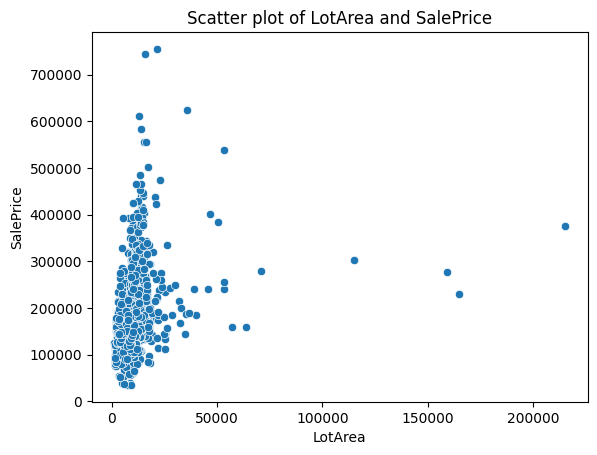

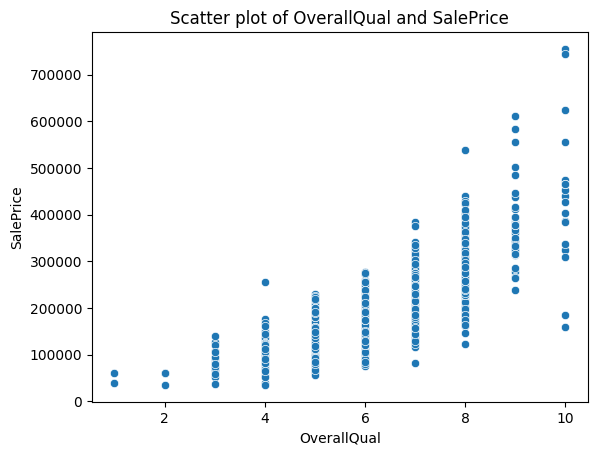

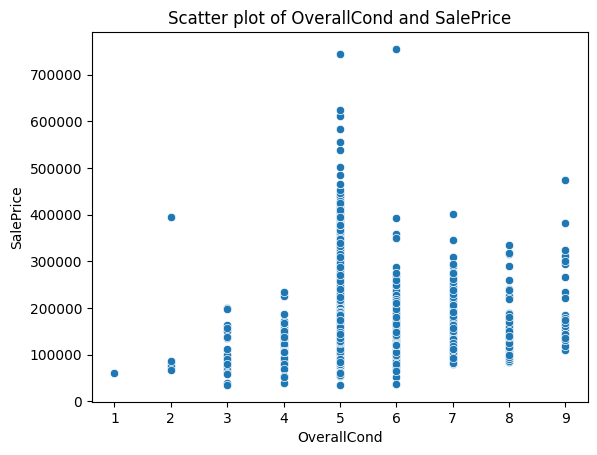

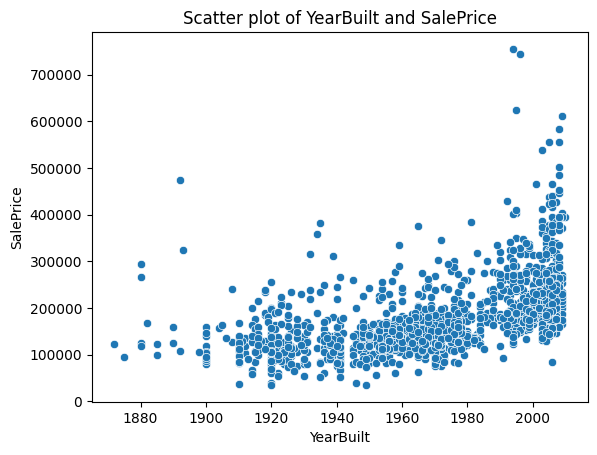

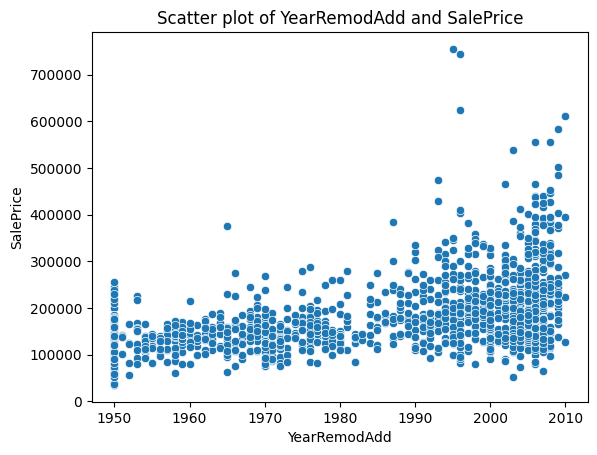

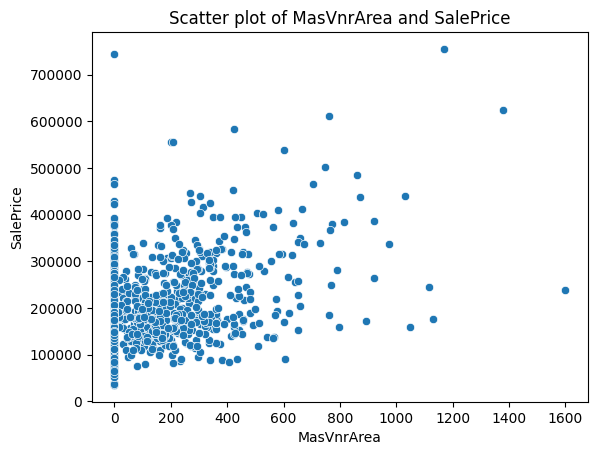

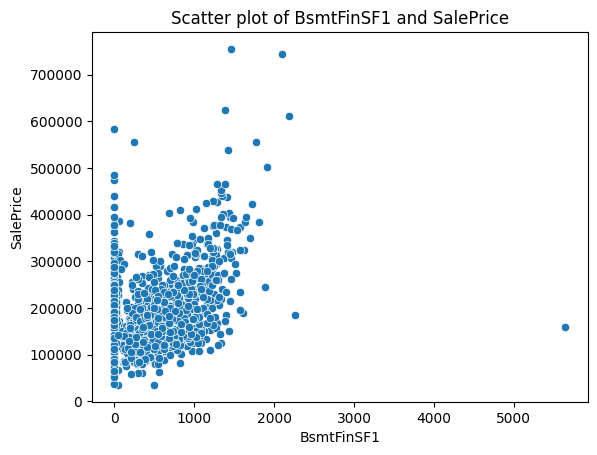

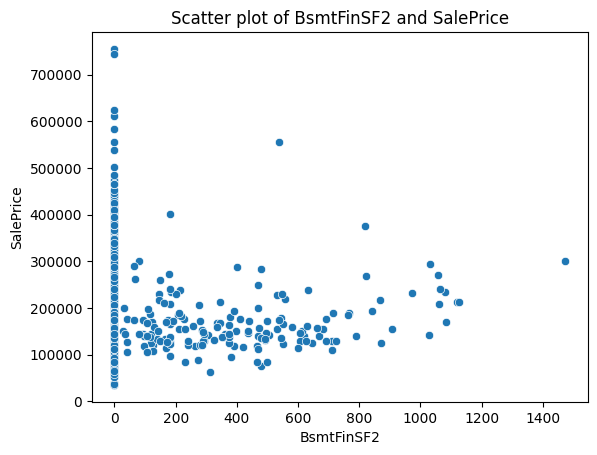

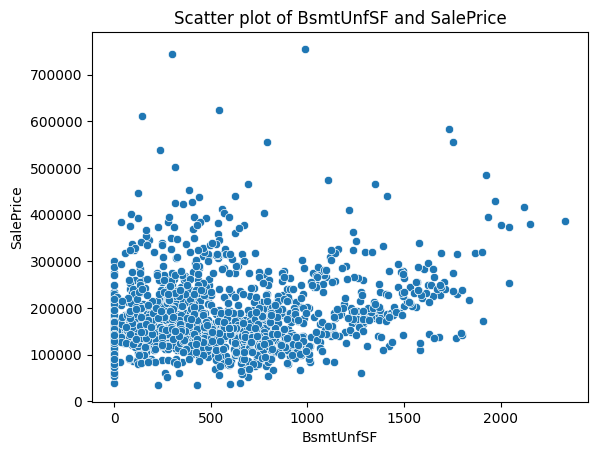

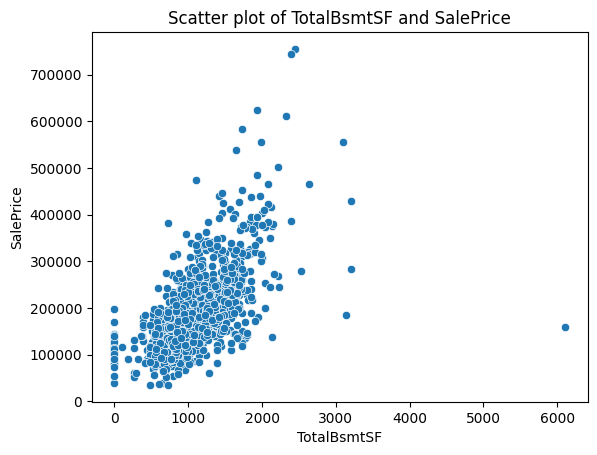

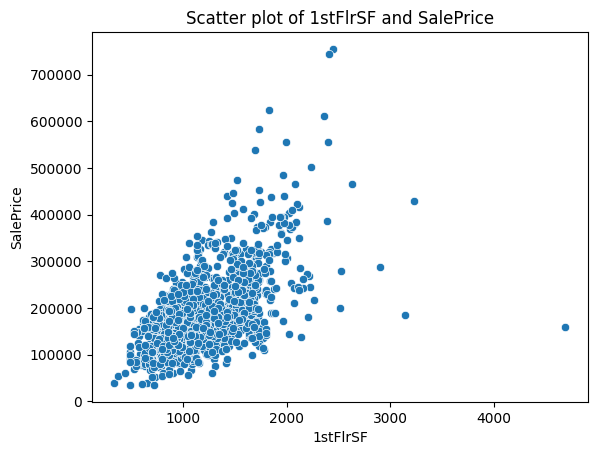

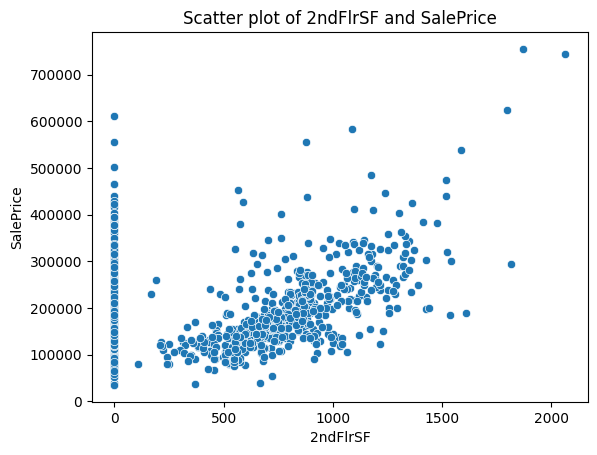

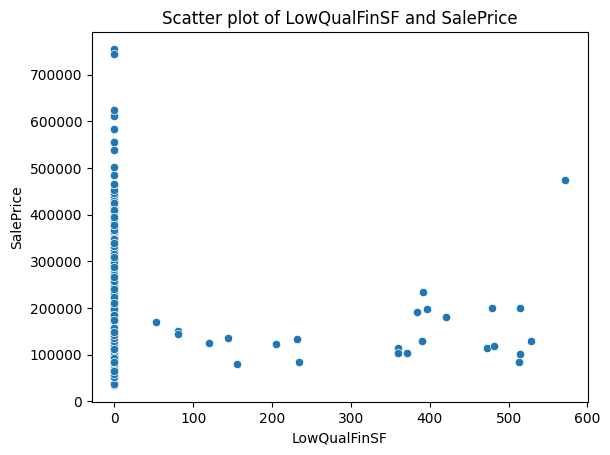

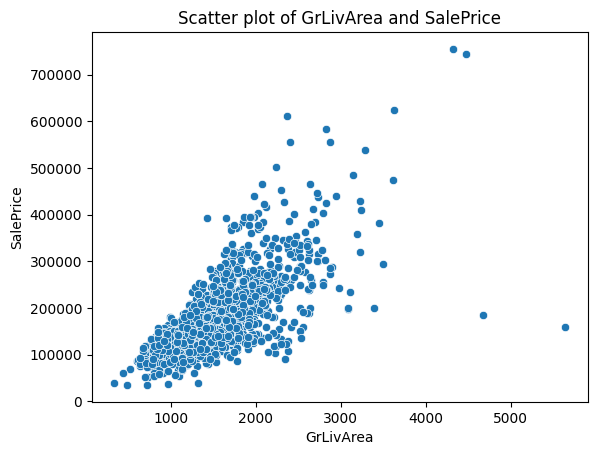

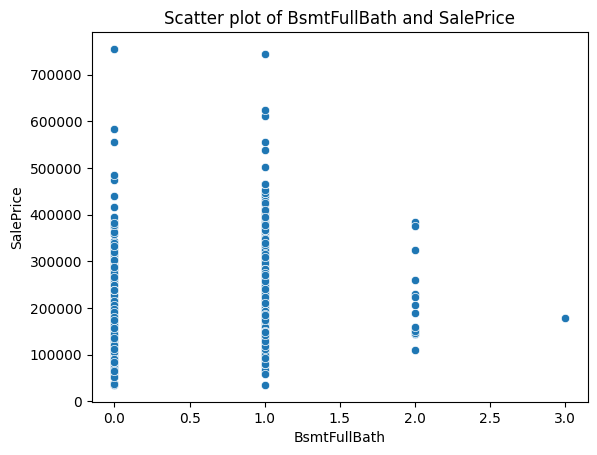

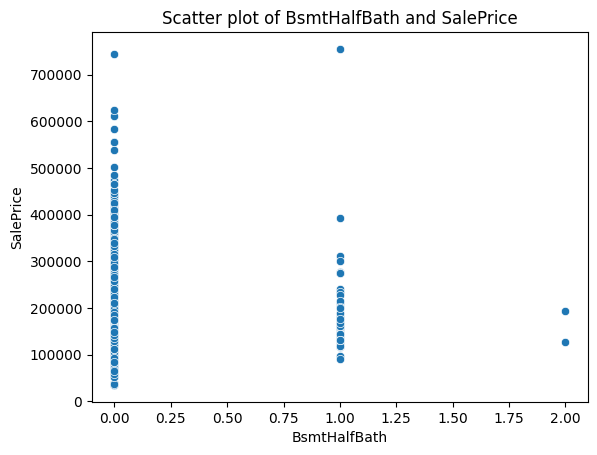

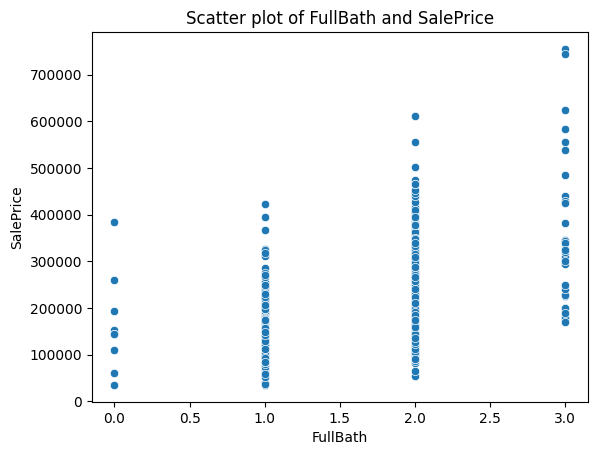

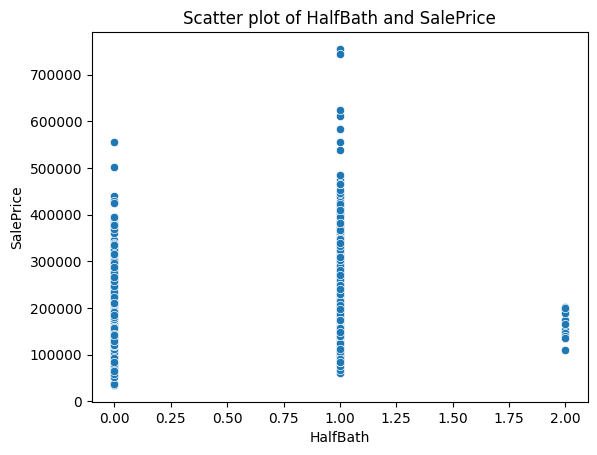

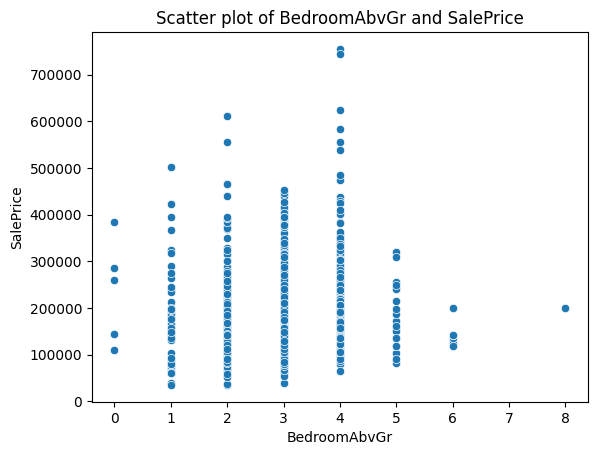

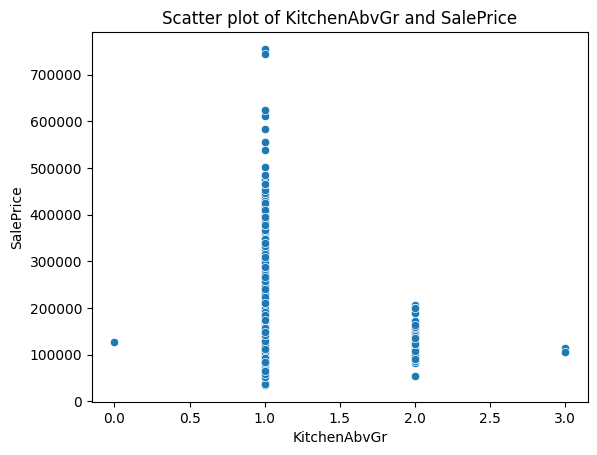

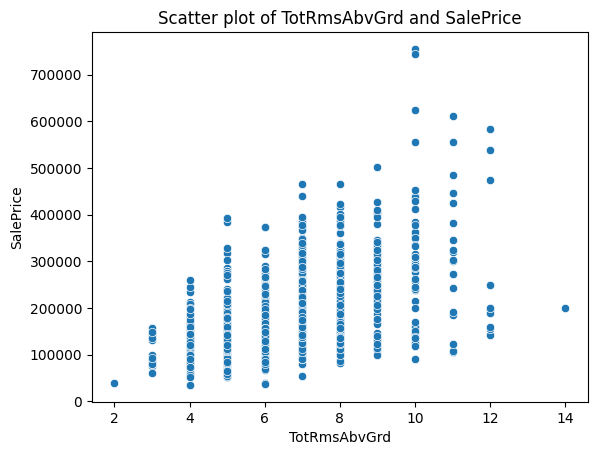

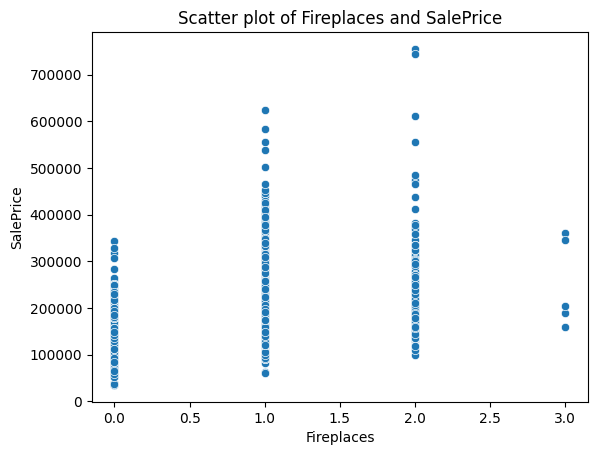

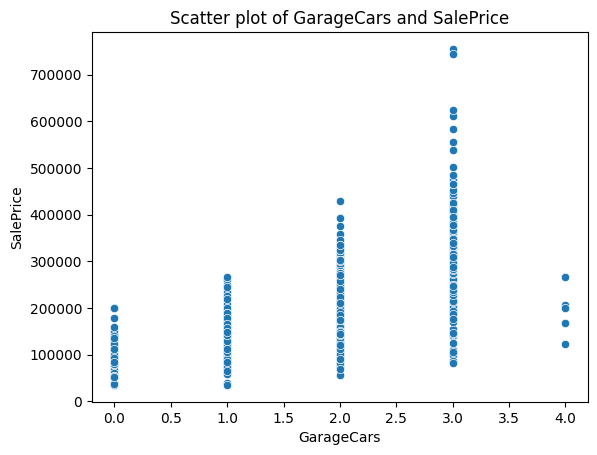

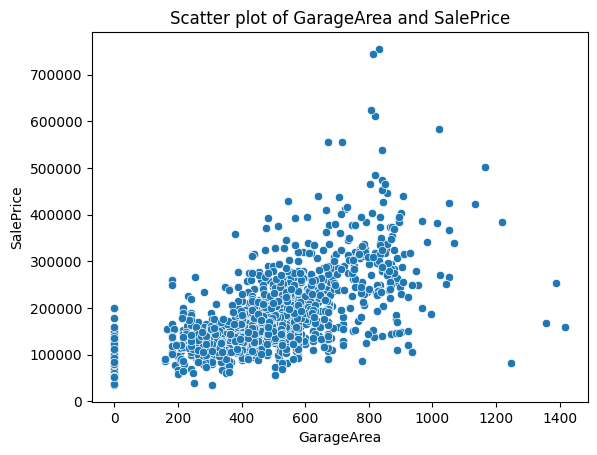

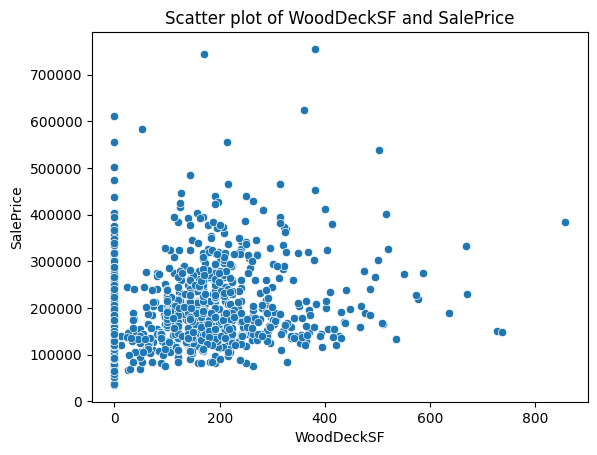

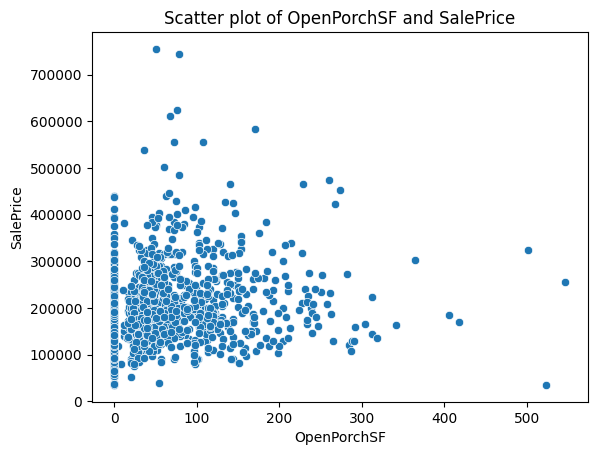

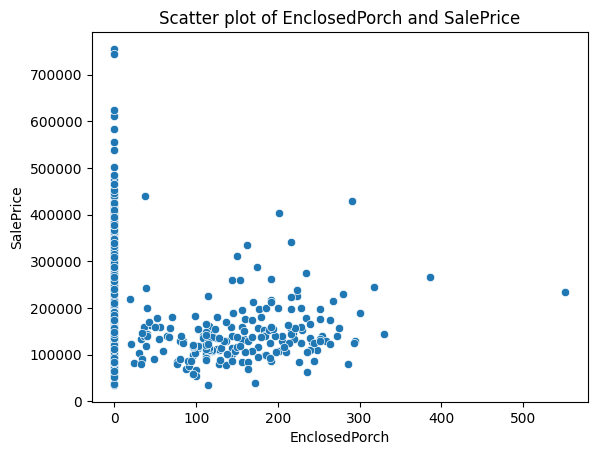

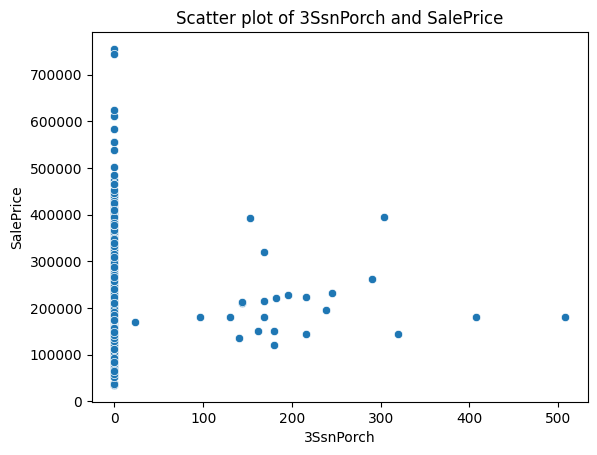

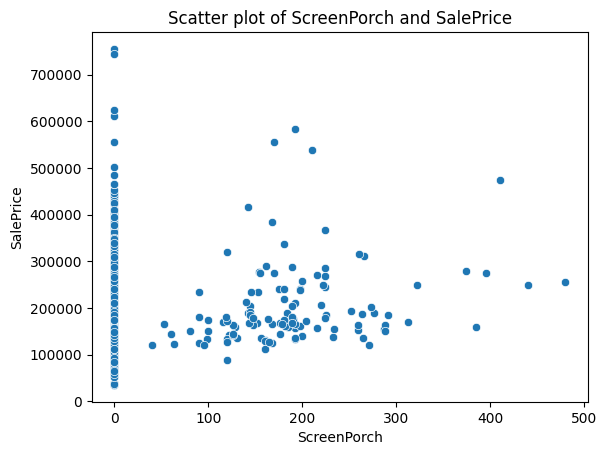

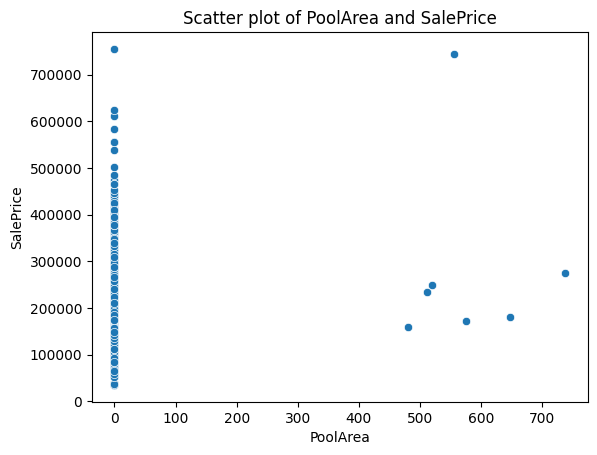

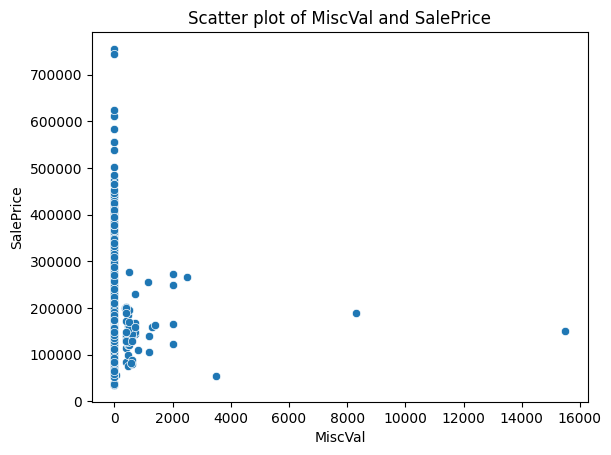

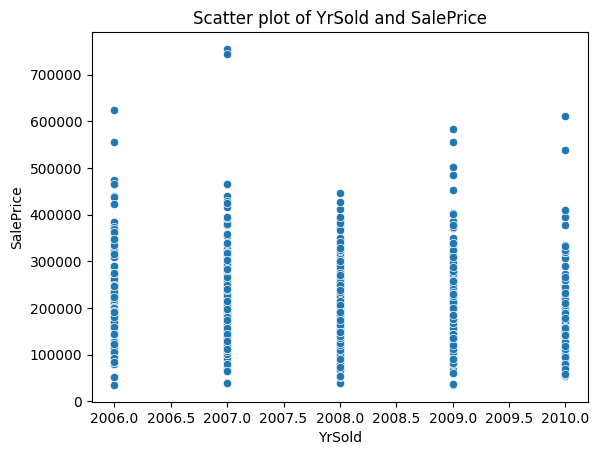

In [26]:
for col in numeric_cols:
    plt.figure()
    sns.scatterplot(data = housing_df, x = col, y = 'SalePrice')
    plt.title('Scatter plot of {0} and {1}'.format(col, 'SalePrice'))
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

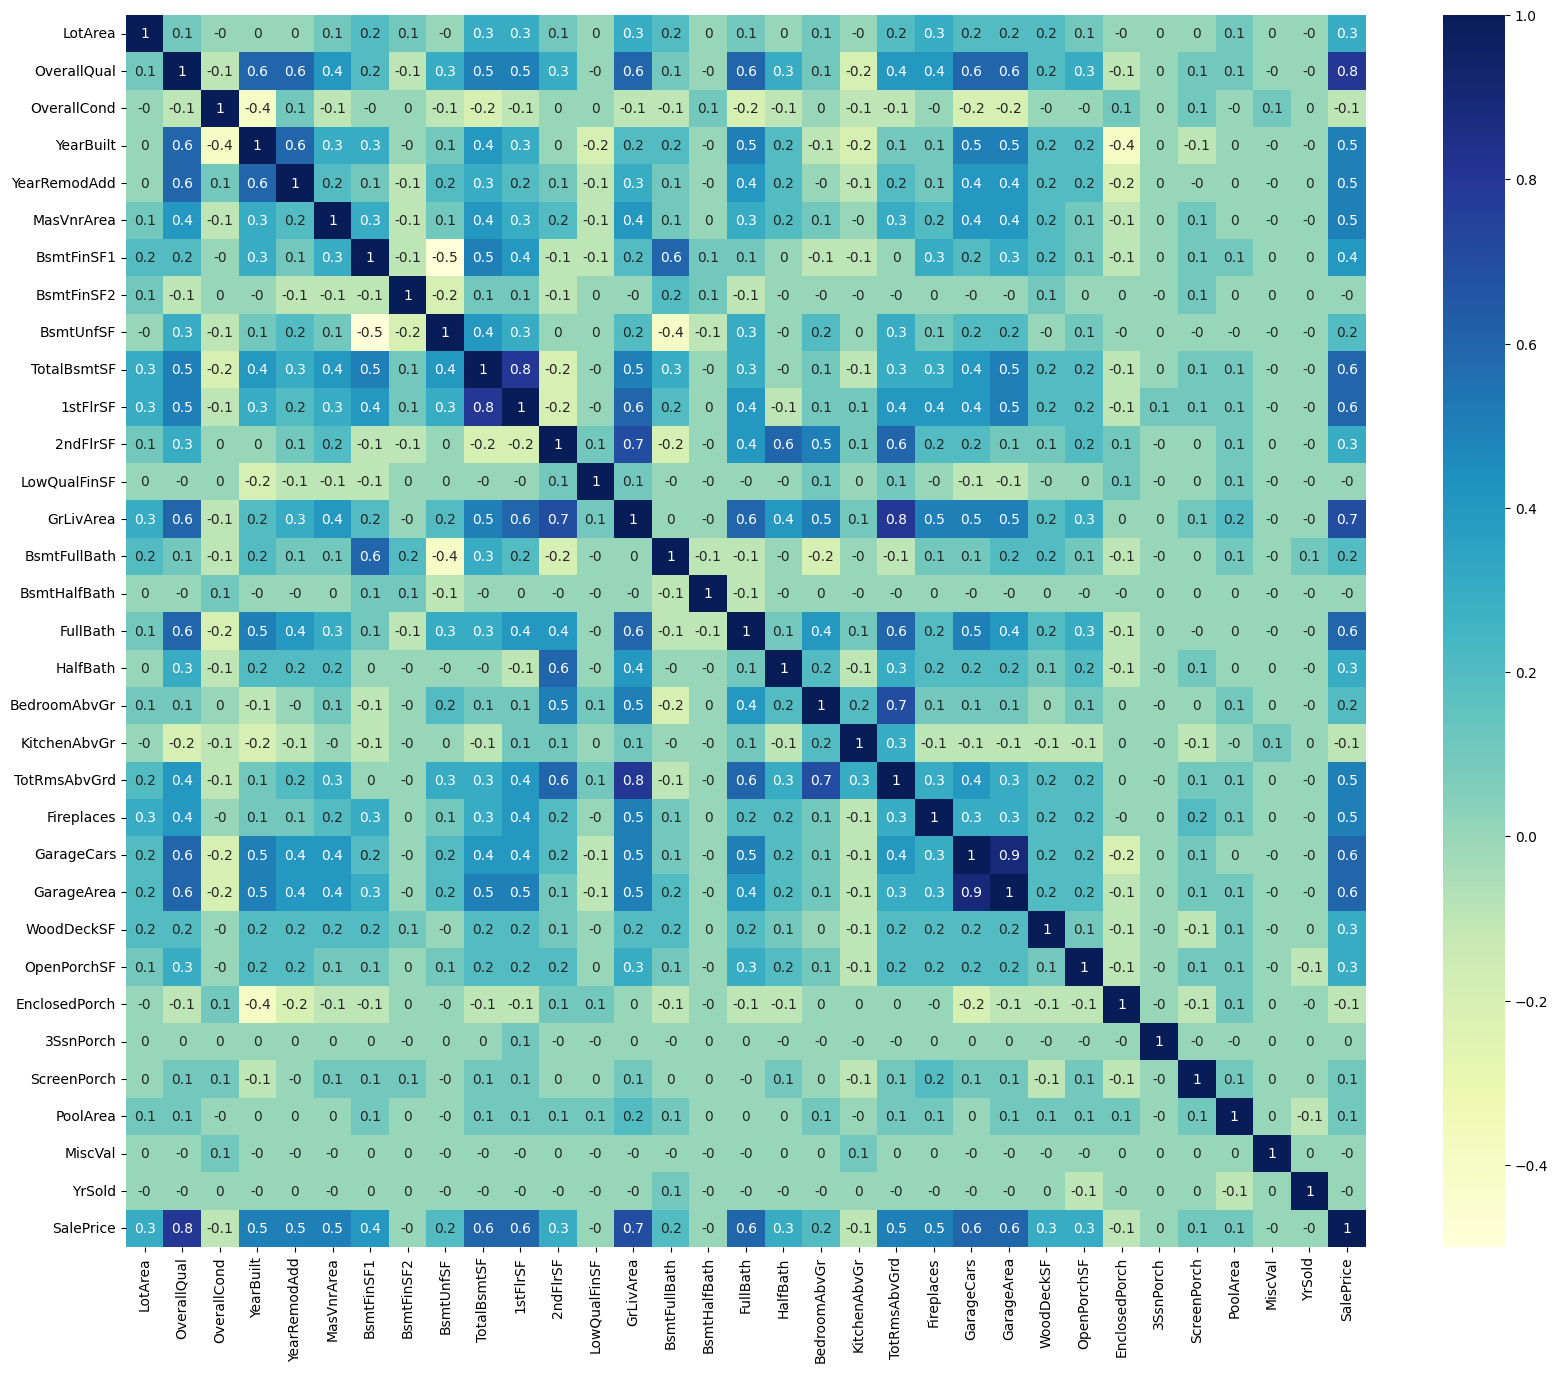

In [27]:
selected_cols = numeric_cols + ['SalePrice']
plt.figure(figsize = (20, 16))
sns.heatmap(round(housing_df[selected_cols].corr(), 1), cmap = 'YlGnBu', annot = True)
plt.show()

Insights from the heatmap:
- `SalePrice` is strongly positively correlated with `OverallQual`, `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `FullBath`, `GarageCars`, `GarageArea`
- `SalePrice` is mildly positively correlated with `YearBuilt`, `YearRemodAdd`, `MasVnrArea`, `TotRmsAbvGrd`, `Fireplaces`

- There are strong correlations among independent variables:
- `OverallQual` is strongly correlated with `YearBuilt`, `YearRemodAdd`, `GrLivArea`, `FullBath`, `GarageCars`, `GarageArea`. This suggests that `OverallQual` captures most of the relationship with `SalePice`
- `OverallCond` is negatively correlated with `YearBuilt`
- `YearBuilt` is strongly correlated with `YearRemodAdd`. This is because in the cases where the house was not remodelled, `YearBuilt` is the same as `YearRemodAdd`. It is negatively correlated with `EnclosedPorch`. This suggests that the recently constructed buildings might not have an enclosed porch.
- `BsmtFinSF1` is negatively correlated with `BsmtUnfSF`. This suggests that as basement finished area increases, not finished basement area decreases, which is as expected.
- `BsmtUnfSF` is negatively correlated with `BsmtFullBath`. This is to be expected because the unfinished sq. ft. will reduce as the number of bathrooms will increase in the basement.
- `TotalBsmtSF` is positively correlated with `1stFlrSF`. This is to be expected because as the basement area increases, the area on the first floor will increase.
- `1stFlrSF` is positively correlated with `GrLivArea`
- `2ndFlrSF` is positively correlated with `GrLivArea`
- `GrLivArea` is positively correlated with `2ndFlrSF`, `FullBath`, `TotRmsAbvGrd`
- `FullBath` is positively correlated with `TotRmsAbvGrd`
- `BedroomAbvGr` is positively correlated with `TotRmsAbvGrd`

#### Univariate analysis of categorical columns

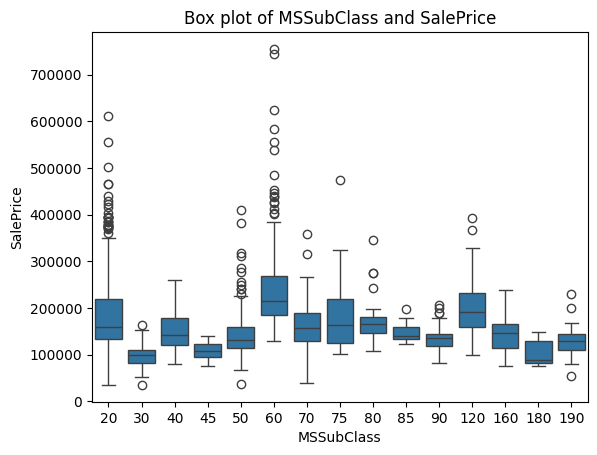

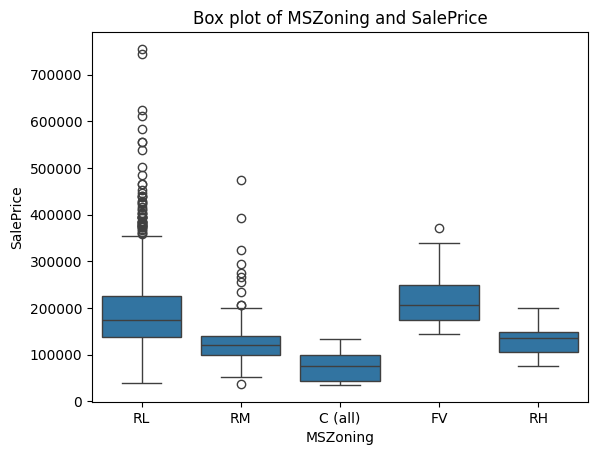

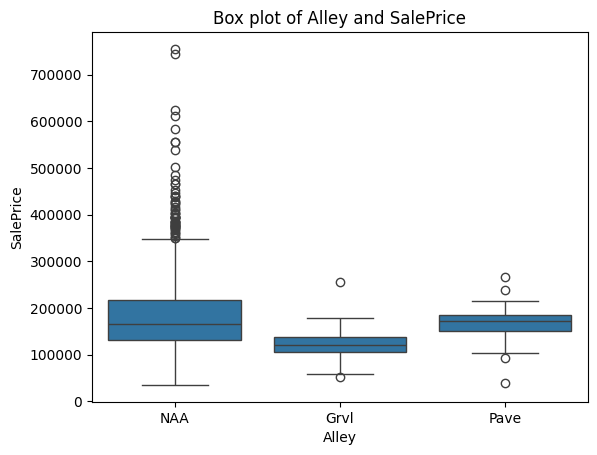

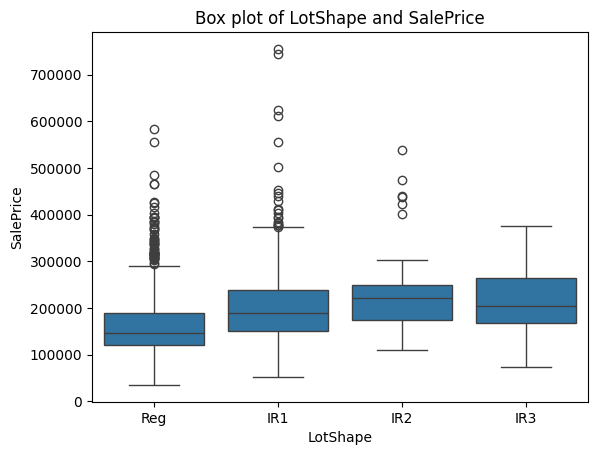

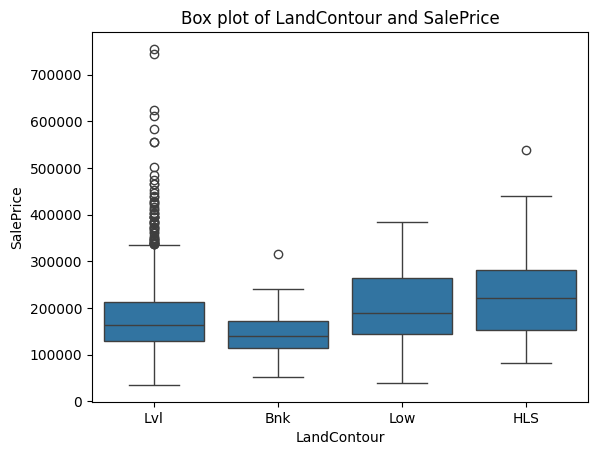

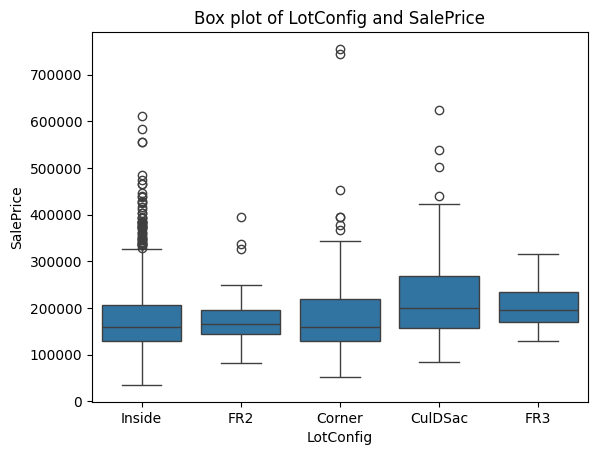

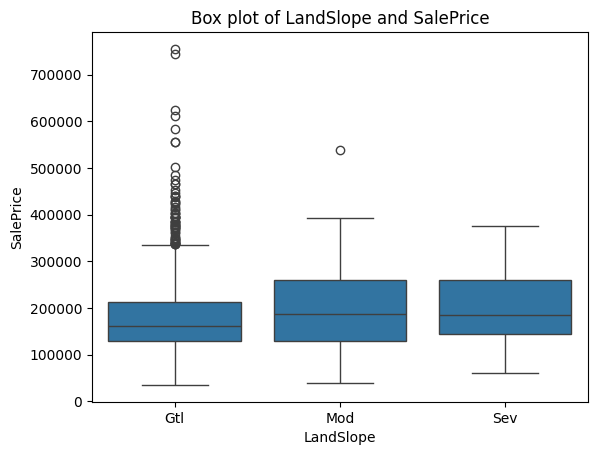

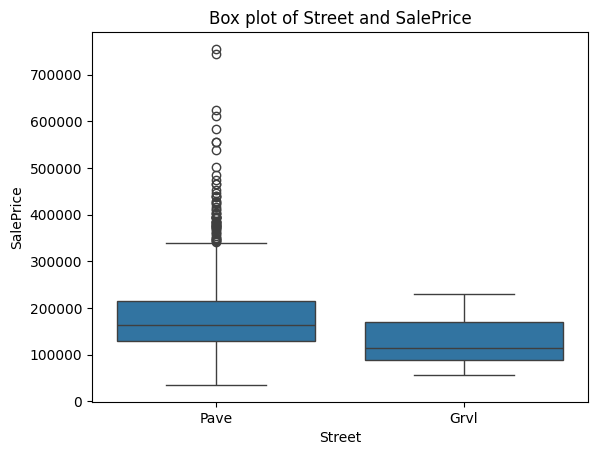

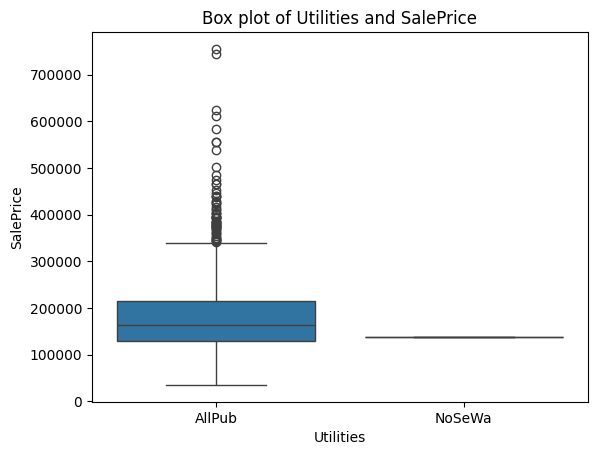

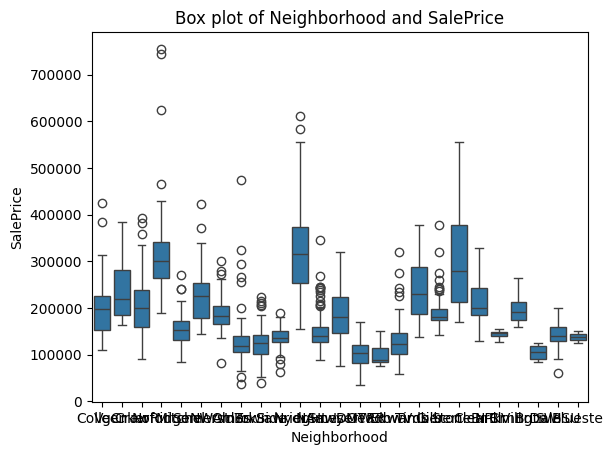

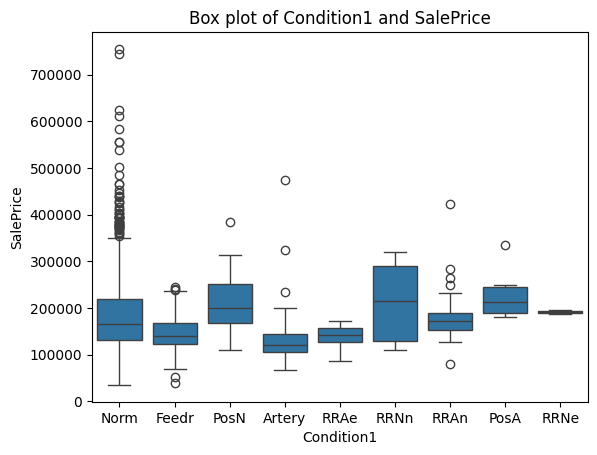

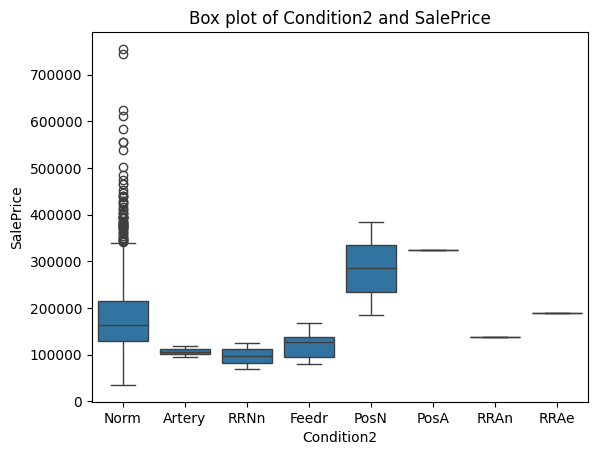

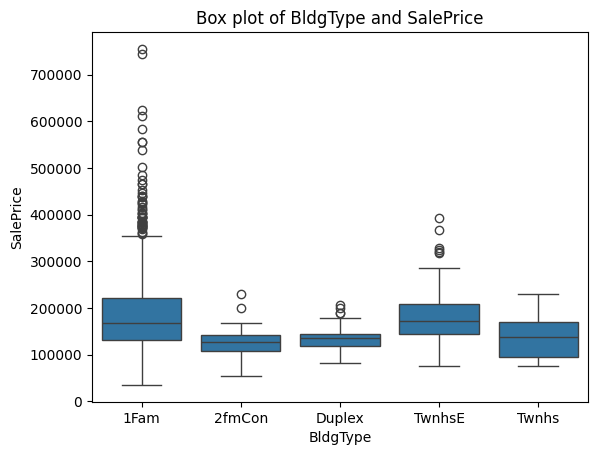

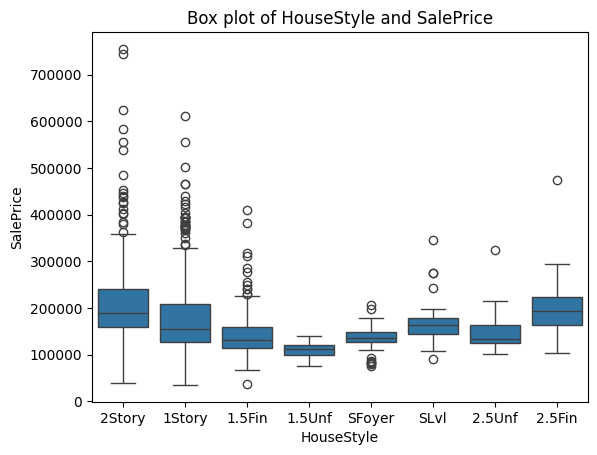

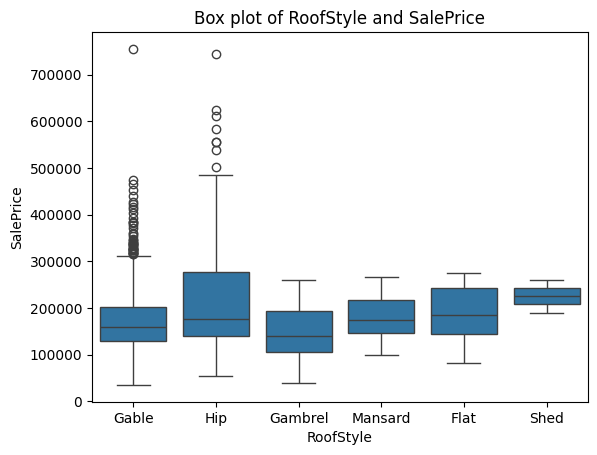

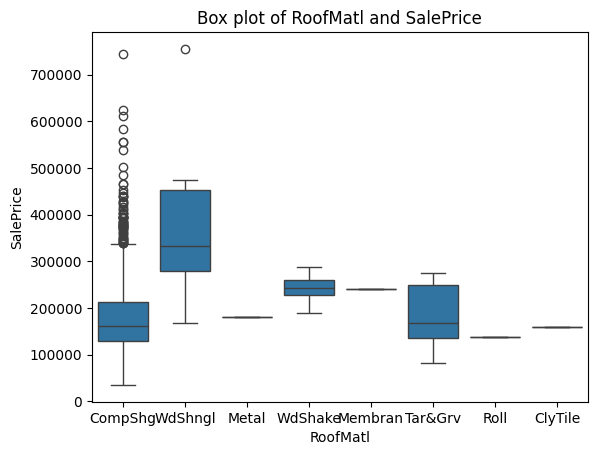

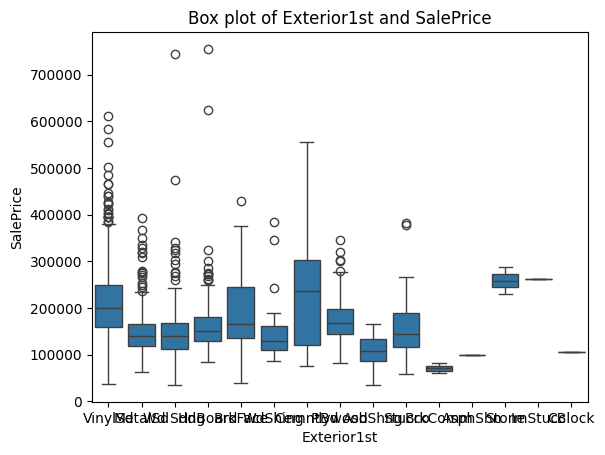

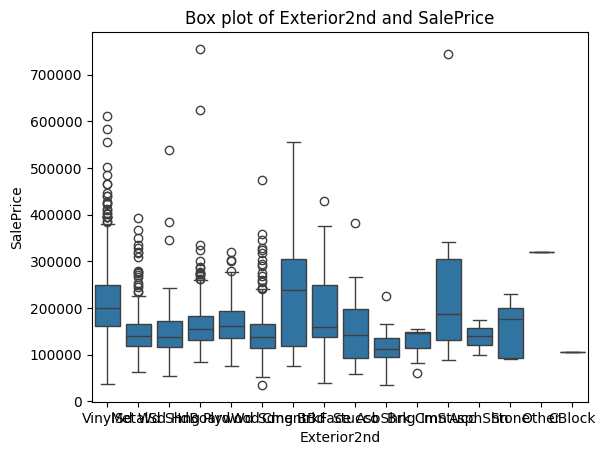

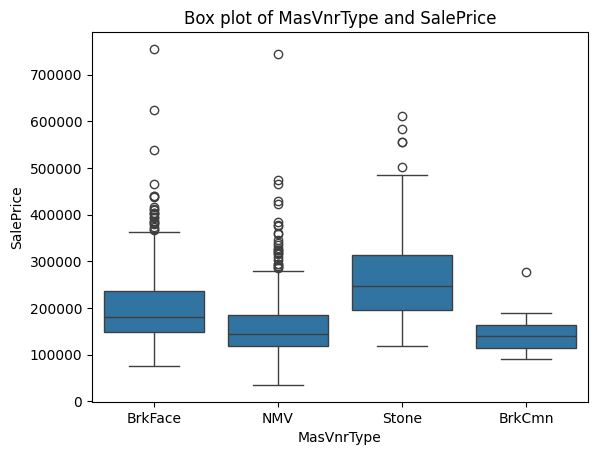

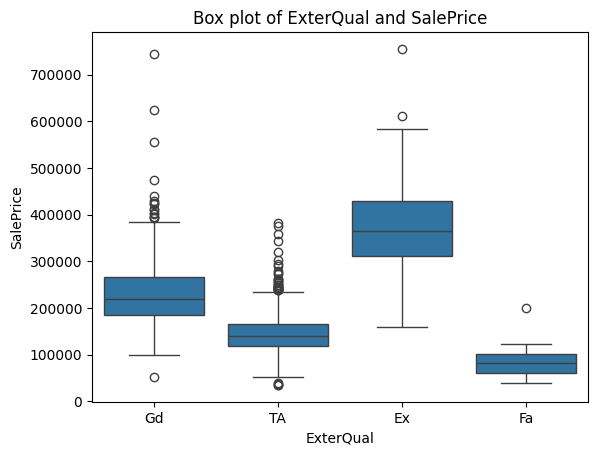

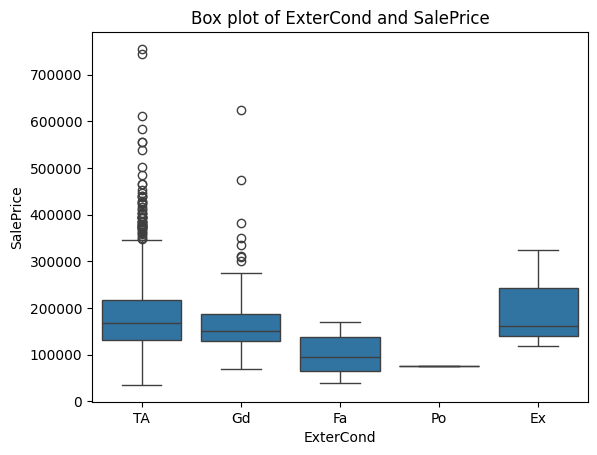

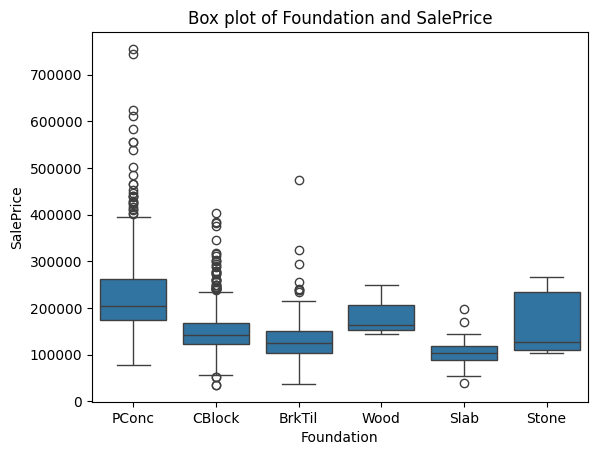

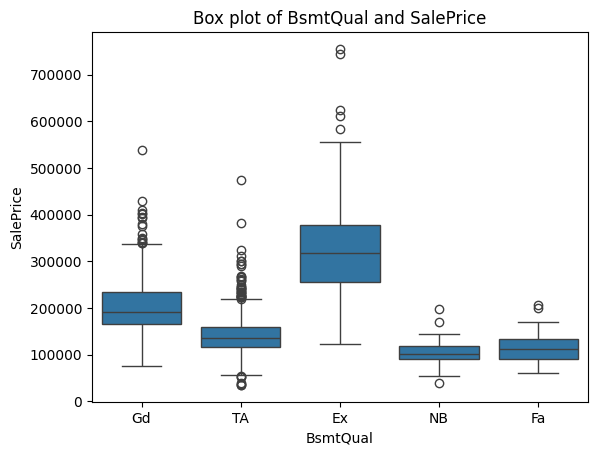

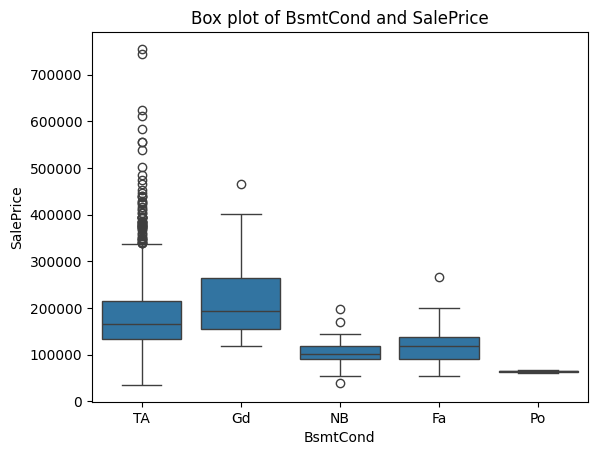

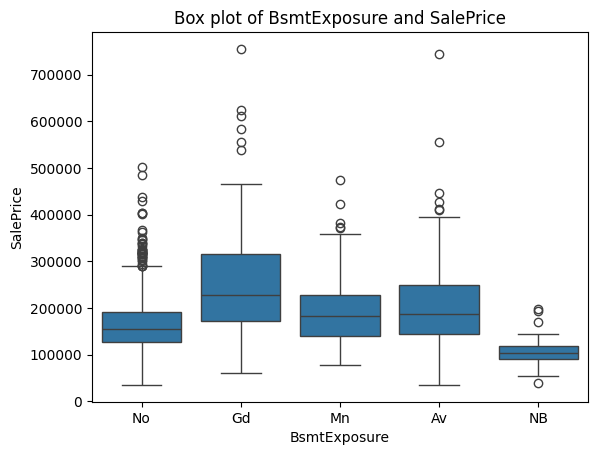

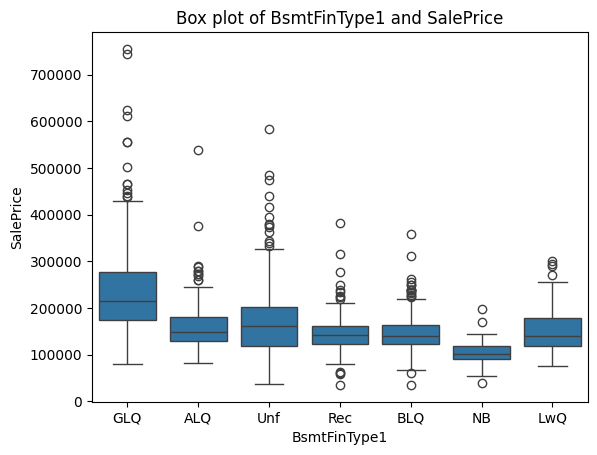

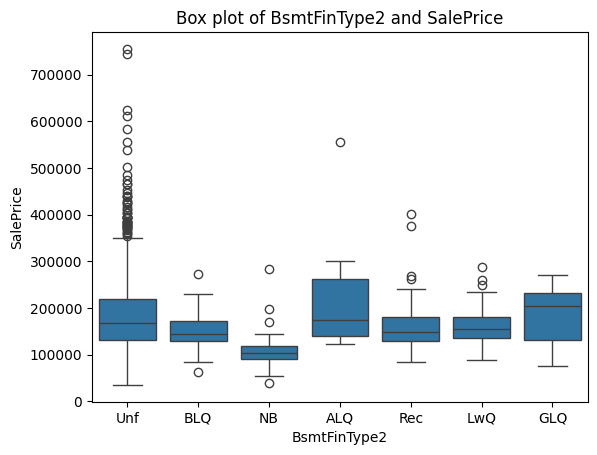

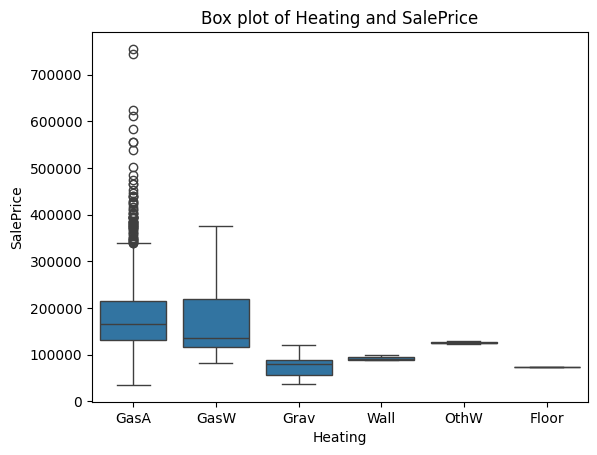

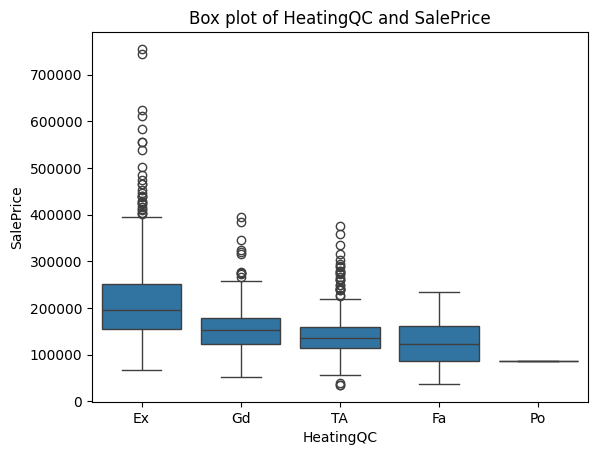

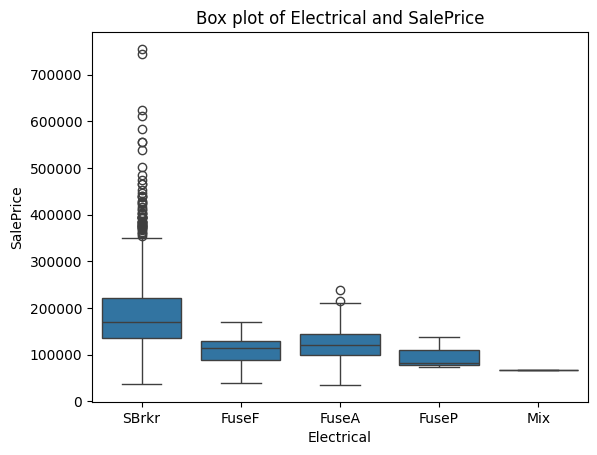

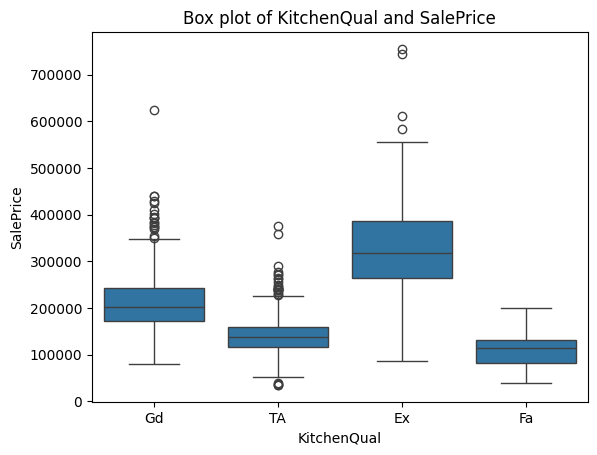

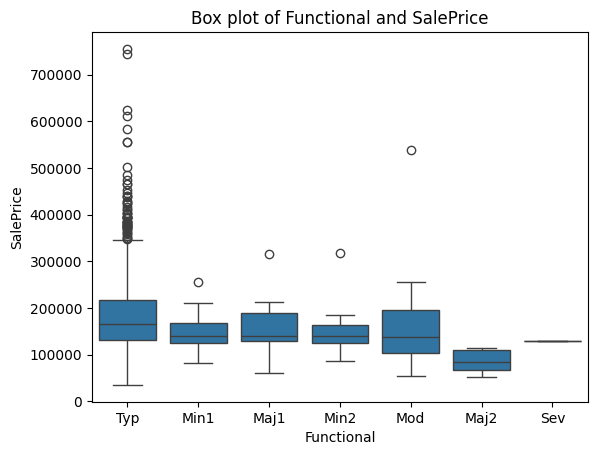

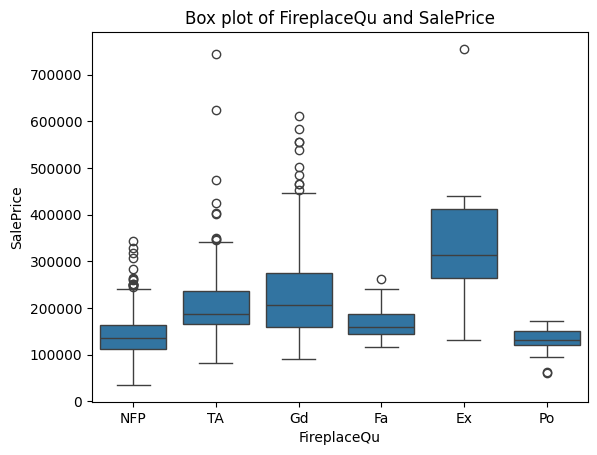

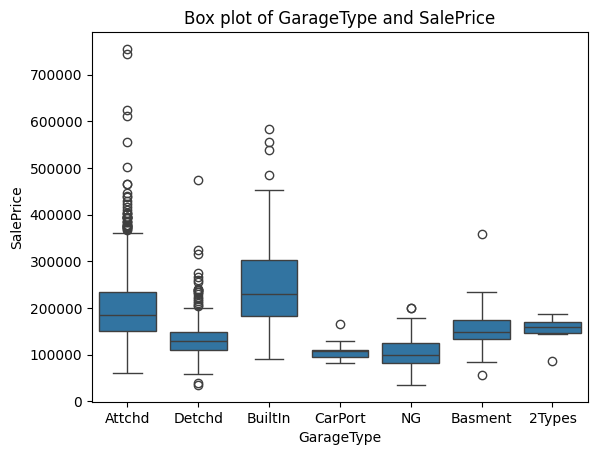

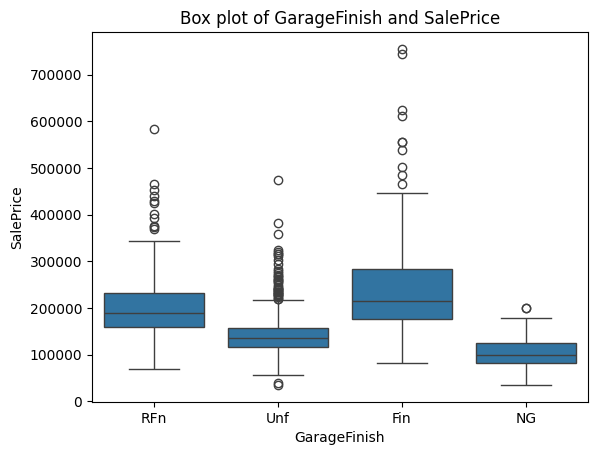

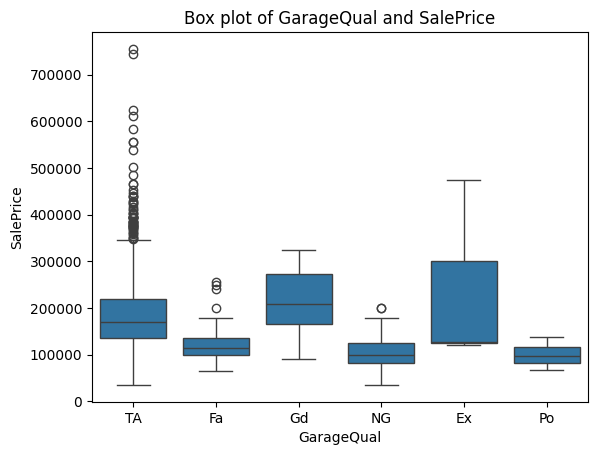

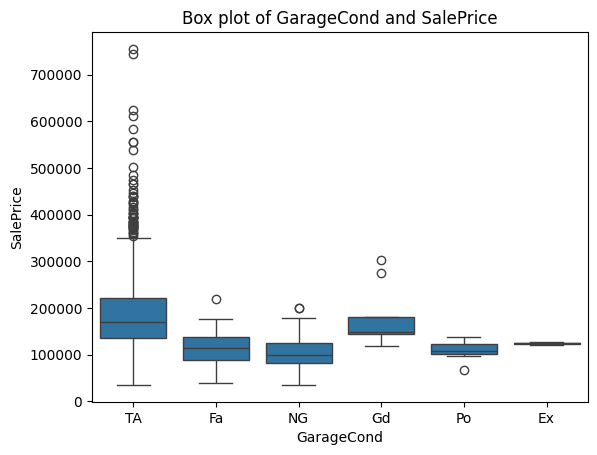

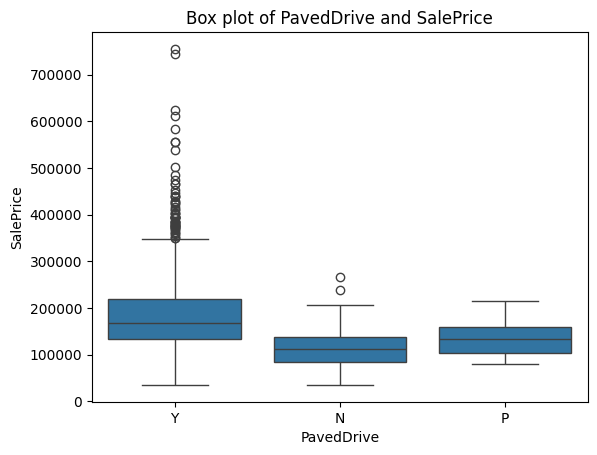

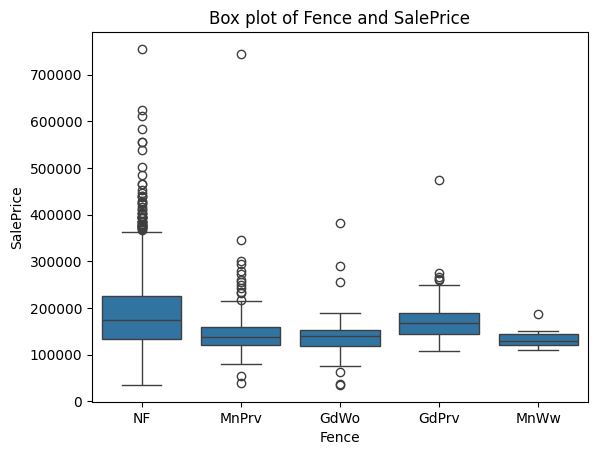

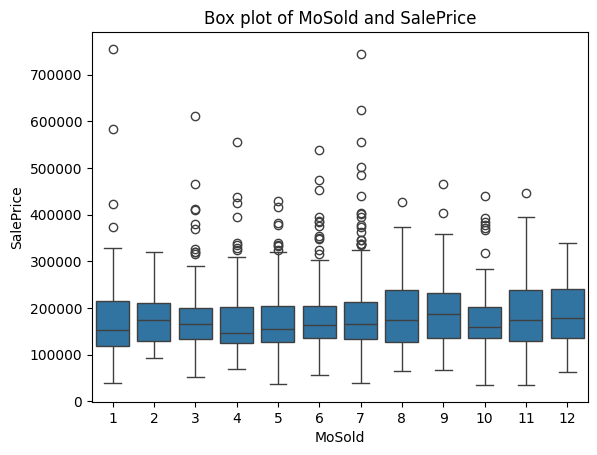

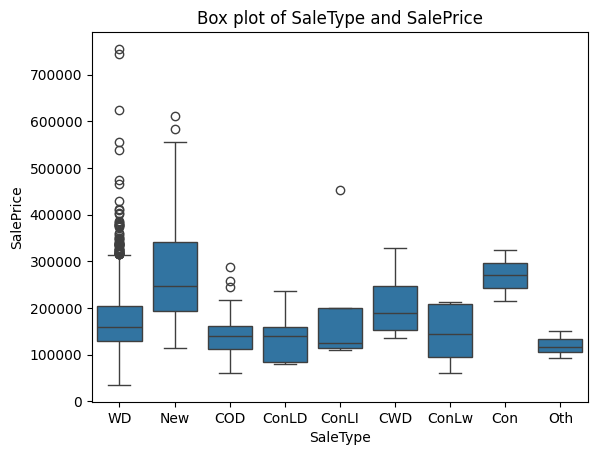

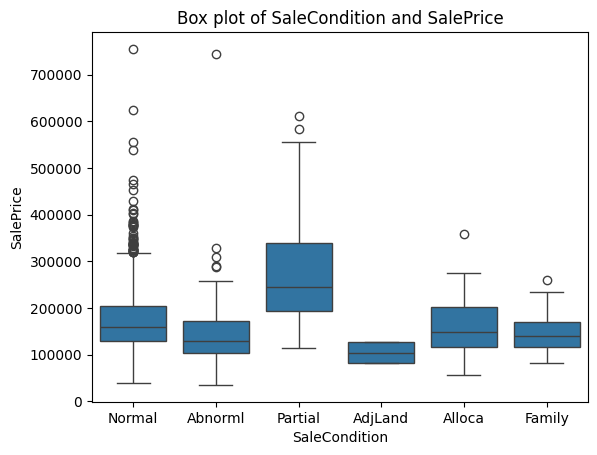

In [28]:
for col in categorical_cols:
    plt.figure()
    sns.boxplot(data = housing_df, x = col, y = 'SalePrice')
    plt.title('Box plot of {0} and {1}'.format(col, 'SalePrice'))
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

#### Data preparation

In [29]:
# Encoding binary variables as 0/1
for col in binary_cols:
    print(housing_df[col].value_counts())
    print('============================================================================================')

CentralAir
Y    1364
N      95
Name: count, dtype: int64
MiscFeature
0    1405
1      54
Name: count, dtype: int64
Pool
0    1452
1       7
Name: count, dtype: int64


In [30]:
# Encoding the column CentralAir as 0/1
housing_df['CentralAir'] = housing_df['CentralAir'].map({'Y': 1, 'N': 0})
print(housing_df['CentralAir'].value_counts())

CentralAir
1    1364
0      95
Name: count, dtype: int64


In [31]:
# Creating dummy columns for categorical variables and dropping the original columns
print('Shape of the DataFrame before creation of categorical variables: {0}'.format(housing_df.shape))
for col in categorical_cols:
    print('Creating dummy for: {0}'.format(col))
    dummies = pd.get_dummies(housing_df[col], dtype = 'int', drop_first=True, prefix = col)
    print('Number of dummy columns: {0}'.format(dummies.shape[1]))
    housing_df.drop(col, axis = 'columns', inplace = True)
    housing_df = pd.concat([housing_df, dummies], axis = 'columns')
    print('Shape of the DataFrame after creation of categorical variables: {0}'.format(housing_df.shape))
    print('============================================================================================')

Shape of the DataFrame before creation of categorical variables: (1459, 78)
Creating dummy for: MSSubClass
Number of dummy columns: 14
Shape of the DataFrame after creation of categorical variables: (1459, 91)
Creating dummy for: MSZoning
Number of dummy columns: 4
Shape of the DataFrame after creation of categorical variables: (1459, 94)
Creating dummy for: Alley
Number of dummy columns: 2
Shape of the DataFrame after creation of categorical variables: (1459, 95)
Creating dummy for: LotShape
Number of dummy columns: 3
Shape of the DataFrame after creation of categorical variables: (1459, 97)
Creating dummy for: LandContour
Number of dummy columns: 3
Shape of the DataFrame after creation of categorical variables: (1459, 99)
Creating dummy for: LotConfig
Number of dummy columns: 4
Shape of the DataFrame after creation of categorical variables: (1459, 102)
Creating dummy for: LandSlope
Number of dummy columns: 2
Shape of the DataFrame after creation of categorical variables: (1459, 103)


In [32]:
print(housing_df.shape)

(1459, 276)


In [33]:
# Creating train and test dataframes
housing_df_train, housing_df_test = train_test_split(housing_df, train_size = 0.7, random_state = 100)
print(housing_df_train.shape)
print(housing_df_test.shape)

(1021, 276)
(438, 276)


In [34]:
# scaling the numerical features as it is required for ridge and lasso regression
print(housing_df_train[selected_cols].describe())
selected_cols = numeric_cols + ['SalePrice']
scaler = MinMaxScaler()
housing_df_train[selected_cols] = scaler.fit_transform(housing_df_train[selected_cols])
print(housing_df_train[selected_cols].describe())
housing_df_test[selected_cols] = scaler.transform(housing_df_test[selected_cols])
print(housing_df_test[selected_cols].describe())

             LotArea  OverallQual  OverallCond    YearBuilt  YearRemodAdd  \
count    1021.000000  1021.000000  1021.000000  1021.000000   1021.000000   
mean    10639.495593     6.112635     5.571009  1971.033301   1984.390793   
std     10452.933711     1.408673     1.115005    30.543715     20.993581   
min      1477.000000     1.000000     1.000000  1872.000000   1950.000000   
25%      7599.000000     5.000000     5.000000  1953.000000   1965.000000   
50%      9572.000000     6.000000     5.000000  1973.000000   1993.000000   
75%     11606.000000     7.000000     6.000000  2001.000000   2004.000000   
max    215245.000000    10.000000     9.000000  2010.000000   2010.000000   

        MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  ...  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000  ...   
mean    104.289912   440.901077    50.992165   568.529873  1060.423115  ...   
std     188.196493   473.694202   170.267644   449.441571   466.53702

In [35]:
# Creating X_train and y_train
X_train = housing_df_train
y_train = housing_df_train.pop('SalePrice')
print(X_train.shape)
print(y_train.shape)

(1021, 275)
(1021,)


In [36]:
# Creating X_test and y_test
X_test = housing_df_test
y_test = housing_df_test.pop('SalePrice')
print(X_test.shape)
print(y_test.shape)

(438, 275)
(438,)


### Model Building and Evaluation

#### Ridge Regression
We will use both neg_mean_absolute_error and neg_mean_squared_error as the scoring parameter.

#### Using neg_mean_absolute_error as the scoring mechanism

In [37]:
# List of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                    4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

In [38]:
ridge = Ridge()

# Cross Validation
folds = 5
model_cv_mean_abs_err = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv_mean_abs_err.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [39]:
# Finding the best hyperparameter alpha:
print(model_cv_mean_abs_err.best_params_)

{'alpha': 7.0}


In [40]:
# Fitting Ridge model for alpha = 7
alpha = 7
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.02339325  0.07309016  0.0319839   0.00708609  0.01369983  0.03571782
  0.01958768  0.00994123  0.01494626  0.02620633  0.00747387  0.04857298
  0.06080653 -0.00365973  0.06408839  0.02769139  0.00149307  0.0449023
  0.01450791  0.00085246 -0.01413193  0.04405252  0.0222311   0.04390576
  0.02250817  0.01809531  0.00270105  0.0028797   0.01173802  0.00878006
  0.00619525 -0.00096075  0.00046741 -0.00394573 -0.00100192 -0.00492728
  0.00156677  0.00395833  0.00480049  0.00128836  0.00846521  0.00262422
 -0.00227612 -0.00469195 -0.00813867 -0.01537089 -0.01589123 -0.00421118
 -0.00974305  0.0125476   0.00897969  0.01040742  0.00143068 -0.00135687
  0.00220252  0.00401137 -0.01826907  0.00022022  0.0238925   0.01651204
  0.01646064  0.01297906 -0.01347271 -0.0088914  -0.00263019  0.00131404
  0.00472507  0.01101824 -0.00494237 -0.00153246 -0.00231704 -0.00062397
  0.00147853 -0.00662373  0.02550195 -0.02713135 -0.01550481 -0.01263569
 -0.01360927 -0.02029138 -0.01380207  0.00165751 -0.

#### Checking the model fit for Ridge Regression and neg_mean_absolute_error scoring method

In [41]:
coeffs = pd.DataFrame(index=X_train.columns)
coeffs['Ridge_mean_abs_err'] = ridge.coef_
r2_scores = pd.DataFrame(index = ['train', 'test'], columns = ['ridge_mean_squared_error', 'ridge_mean_absolute_error', 'lasso_mean_squared_error', 'lasso_mean_absolute_error'])
r2_scores

ridge_mean_squared_error ridge_mean_absolute_error  \
train                      NaN                       NaN   
test                       NaN                       NaN   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                      NaN                       NaN  
test                       NaN                       NaN

In [42]:
# Checking the R2 score on the train and test data
y_pred_train_ridge_mean_absolute_error = ridge.predict(X_train)
y_pred_test_ridge_mean_absolute_error = ridge.predict(X_test)

print('R2 score on train data: {0}'.format(r2_score(y_train, y_pred_train_ridge_mean_absolute_error)))
print('R2 score on test data: {0}'.format(r2_score(y_test, y_pred_test_ridge_mean_absolute_error)))

r2_scores.loc['train']['ridge_mean_absolute_error'] = r2_score(y_train, y_pred_train_ridge_mean_absolute_error)
r2_scores.loc['test']['ridge_mean_absolute_error'] = r2_score(y_test, y_pred_test_ridge_mean_absolute_error)
print(r2_scores)

R2 score on train data: 0.8892378513544957
R2 score on test data: 0.8709749348748915
      ridge_mean_squared_error ridge_mean_absolute_error  \
train                      NaN                  0.889238   
test                       NaN                  0.870975   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                      NaN                       NaN  
test                       NaN                       NaN  


#### Using neg_mean_squared_error as the scoring mechanism

In [43]:
ridge = Ridge()

# Cross Validation
folds = 5
model_cv_mean_sq_err = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring = 'neg_mean_squared_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv_mean_sq_err.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [44]:
# Finding the best hyperparameter alpha
print(model_cv_mean_sq_err.best_params_)

{'alpha': 10.0}


In [45]:
# Fitting the ridge model with alpha = 10
alpha = 10
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 1.88591100e-02  6.67986947e-02  2.79365078e-02  6.43720025e-03
  1.49893551e-02  3.30737947e-02  1.81545316e-02  8.42609987e-03
  1.61721090e-02  2.49856455e-02  8.25747090e-03  4.32465885e-02
  5.25031254e-02 -3.49384750e-03  5.63883330e-02  2.48644757e-02
  9.92025648e-04  4.26896372e-02  1.46978765e-02  3.82331244e-03
 -1.07113219e-02  4.20174969e-02  2.18575309e-02  4.06913831e-02
  2.49312097e-02  1.80549083e-02  4.37360492e-03  2.66210422e-03
  9.05191923e-03  8.06017385e-03  5.78674060e-03 -1.22203561e-03
  2.58884080e-04 -3.68479576e-03  7.03848523e-04 -6.63823987e-03
  1.27066534e-03  3.51191651e-03  5.07332697e-03  2.79812705e-03
  8.58844994e-03  2.95245850e-03 -2.99556260e-03 -4.23695161e-03
 -7.43740056e-03 -1.46668044e-02 -1.47636094e-02 -3.90649208e-03
 -8.80888977e-03  1.03845984e-02  6.80695364e-03  9.63133171e-03
 -1.00798693e-03 -1.22963975e-03  2.41341802e-03  3.69936379e-03
 -1.47151538e-02 -4.91100070e-04  2.04297225e-02  1.32793606e-02
  1.40429997e-02  1.23348

#### Checking the model fit for Ridge Regression and neg_mean_squared_error scoring method

In [47]:
y_pred_train_ridge_mean_squared_error = ridge.predict(X_train)
y_pred_test_ridge_mean_squared_error = ridge.predict(X_test)

print('R2 score on train data: {0}'.format(r2_score(y_train, y_pred_train_ridge_mean_squared_error)))
print('R2 score on test data: {0}'.format(r2_score(y_test, y_pred_test_ridge_mean_squared_error)))

r2_scores.loc['train']['ridge_mean_squared_error'] = r2_score(y_train, y_pred_train_ridge_mean_squared_error)
r2_scores.loc['test']['ridge_mean_squared_error'] = r2_score(y_test, y_pred_test_ridge_mean_squared_error)
print(r2_scores)

R2 score on train data: 0.8827901674974328
R2 score on test data: 0.8677859839187358
      ridge_mean_squared_error ridge_mean_absolute_error  \
train                  0.88279                  0.889238   
test                  0.867786                  0.870975   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                      NaN                       NaN  
test                       NaN                       NaN  


In [48]:
coeffs['Ridge_mean_sq_err'] = ridge.coef_

The model performs sufficiently well in Ridge regression. But it is too complex as there are lot of variables and it is very difficult to interpret

#### Lasso Regression

We will use both neg_mean_absolute_error and neg_mean_squared_error as the scoring parameter.

In [49]:
lasso = Lasso()

# Cross Validation
folds = 5
model_cv_mean_abs_err = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv_mean_abs_err.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [50]:
# Finding the best hyperparameter alpha
print(model_cv_mean_abs_err.best_params_)

{'alpha': 0.0001}


In [83]:
# Fitting Lasso model for alpha = 0.0001
alpha = 0.0001
lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[ 4.24341575e-02  1.18400070e-01  4.87729055e-02  1.40065684e-02
  8.23295930e-03  4.10417556e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.60163829e-03  0.00000000e+00
  3.16912590e-02 -1.08955869e-02  3.00111997e-01  3.49328920e-02
  0.00000000e+00  3.41777777e-02  5.80535574e-03 -2.14041088e-03
 -3.71782865e-02  8.83288660e-03  1.19807935e-02  5.89074401e-02
  0.00000000e+00  8.05490258e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  5.42277823e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.66496471e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.33945226e-03 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -5.85466892e-03 -1.33036619e-02 -1.42389423e-02 -0.00000000e+00
 -1.11495386e-02  9.04772808e-03  1.69277145e-03  7.33967191e-03
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.58011762e-03
 -2.71738649e-02  3.68059034e-04  2.73545987e-02  2.51142241e-02
  2.08556048e-02  1.47052

#### Checking the model fit for Lasso Regression and neg_mean_absolute_error scoring method

In [84]:
# Checking the R2 score on the train and test data
y_pred_train_lasso_mean_absolute_error = lasso.predict(X_train)
y_pred_test_lasso_mean_absolute_error = lasso.predict(X_test)

print('R2 score on train data: {0}'.format(r2_score(y_train, y_pred_train_lasso_mean_absolute_error)))
print('R2 score on test data: {0}'.format(r2_score(y_test, y_pred_test_lasso_mean_absolute_error)))

r2_scores.loc['train']['lasso_mean_absolute_error'] = r2_score(y_train, y_pred_train_lasso_mean_absolute_error)
r2_scores.loc['test']['lasso_mean_absolute_error'] = r2_score(y_test, y_pred_test_lasso_mean_absolute_error)
print(r2_scores)

R2 score on train data: 0.8995164206732411
R2 score on test data: 0.8806631152596457
      ridge_mean_squared_error ridge_mean_absolute_error  \
train                  0.88279                  0.889238   
test                  0.867786                  0.870975   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                 0.822164                  0.899516  
test                  0.824092                  0.880663  


In [85]:
coeffs['Lasso_mean_abs_err'] = lasso.coef_

The Lasso regression performs better than Ridge and also makes many coefficients 0

In [54]:
lasso = Lasso()

# Cross Validation
folds = 5
model_cv_mean_sq_err = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_squared_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv_mean_sq_err.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [55]:
# Finding the best hyperparameter alpha
print(model_cv_mean_sq_err.best_params_)

{'alpha': 0.001}


In [56]:
# Fitting Lasso model for alpha = 0.0001
alpha = 0.001
lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[ 0.00000000e+00  1.74109216e-01  0.00000000e+00  0.00000000e+00
  1.89143136e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.73686293e-03  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  2.00016487e-01  5.70757292e-03
  0.00000000e+00  5.92391551e-03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  9.29294771e-03  0.00000000e+00  6.47962485e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  6.84870844e-03
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.80609583e-03
 -1.33588371e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -4.32728786e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.21809

#### Checking the model fit for Lasso Regression and neg_mean_squared_error scoring method

In [58]:
# Checking the R2 score on the train and test data
y_pred_train_lasso_mean_squared_error = lasso.predict(X_train)
y_pred_test_lasso_mean_squared_error = lasso.predict(X_test)

print('R2 score on train data: {0}'.format(r2_score(y_train, y_pred_train_lasso_mean_squared_error)))
print('R2 score on test data: {0}'.format(r2_score(y_test, y_pred_test_lasso_mean_squared_error)))

r2_scores.loc['train']['lasso_mean_squared_error'] = r2_score(y_train, y_pred_train_lasso_mean_squared_error)
r2_scores.loc['test']['lasso_mean_squared_error'] = r2_score(y_test, y_pred_test_lasso_mean_squared_error)
print(r2_scores)

R2 score on train data: 0.822163873820066
R2 score on test data: 0.8240918727230888
      ridge_mean_squared_error ridge_mean_absolute_error  \
train                  0.88279                  0.889238   
test                  0.867786                  0.870975   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                 0.822164                  0.899516  
test                  0.824092                  0.880663  


In [59]:
coeffs['Lasso_mean_sq_err'] = lasso.coef_

### Comparing the Ridge and Lasso models

In [60]:
# Set the display option to show all rows
pd.set_option('display.max_rows', None)

In [61]:
coeffs['Ridge_mean_abs_err'] = round(coeffs['Ridge_mean_abs_err'], 4)
coeffs['Ridge_mean_sq_err'] = round(coeffs['Ridge_mean_sq_err'], 4)
coeffs['Lasso_mean_abs_err'] = round(coeffs['Lasso_mean_abs_err'], 4)
coeffs['Lasso_mean_sq_err'] = round(coeffs['Lasso_mean_sq_err'], 4)

In [62]:
coeffs

Ridge_mean_abs_err  Ridge_mean_sq_err  \
LotArea                            0.0234             0.0189   
OverallQual                        0.0731             0.0668   
OverallCond                        0.0320             0.0279   
YearBuilt                          0.0071             0.0064   
YearRemodAdd                       0.0137             0.0150   
MasVnrArea                         0.0357             0.0331   
BsmtFinSF1                         0.0196             0.0182   
BsmtFinSF2                         0.0099             0.0084   
BsmtUnfSF                          0.0149             0.0162   
TotalBsmtSF                        0.0262             0.0250   
CentralAir                         0.0075             0.0083   
1stFlrSF                           0.0486             0.0432   
2ndFlrSF                           0.0608             0.0525   
LowQualFinSF                      -0.0037            -0.0035   
GrLivArea                          0.0641             0.0564   
BsmtFullBath                       0.0277             0.0249   
BsmtHalfBath                       0.0015             0.0010   
FullBath                           0.0449             0.0427   
HalfBath                           0.0145             0.0147   
BedroomAbvGr                       0.0009             0.0038   
KitchenAbvGr                      -0.0141            -0.0107   
TotRmsAbvGrd                       0.0441             0.0420   
Fireplaces                         0.0222             0.0219   
GarageCars                         0.0439             0.0407   
GarageArea                         0.0225             0.0249   
WoodDeckSF                         0.0181             0.0181   
OpenPorchSF                        0.0027             0.0044   
EnclosedPorch                      0.0029             0.0027   
3SsnPorch                          0.0117             0.0091   
ScreenPorch                        0.0088             0.0081   
PoolArea                           0.0062             0.0058   
MiscFeature                       -0.0010            -0.0012   
MiscVal                            0.0005             0.0003   
YrSold                            -0.0039            -0.0037   
Pool                              -0.0010             0.0007   
MSSubClass_30                     -0.0049            -0.0066   
MSSubClass_40                      0.0016             0.0013   
MSSubClass_45                      0.0040             0.0035   
MSSubClass_50                      0.0048             0.0051   
MSSubClass_60                      0.0013             0.0028   
MSSubClass_70                      0.0085             0.0086   
MSSubClass_75                      0.0026             0.0030   
MSSubClass_80                     -0.0023            -0.0030   
MSSubClass_85                     -0.0047            -0.0042   
MSSubClass_90                     -0.0081            -0.0074   
MSSubClass_120                    -0.0154            -0.0147   
MSSubClass_160                    -0.0159            -0.0148   
MSSubClass_180                    -0.0042            -0.0039   
MSSubClass_190                    -0.0097            -0.0088   
MSZoning_FV                        0.0125             0.0104   
MSZoning_RH                        0.0090             0.0068   
MSZoning_RL                        0.0104             0.0096   
MSZoning_RM                        0.0014            -0.0010   
Alley_NAA                         -0.0014            -0.0012   
Alley_Pave                         0.0022             0.0024   
LotShape_IR2                       0.0040             0.0037   
LotShape_IR3                      -0.0183            -0.0147   
LotShape_Reg                       0.0002            -0.0005   
LandContour_HLS                    0.0239             0.0204   
LandContour_Low                    0.0165             0.0133   
LandContour_Lvl                    0.0165             0.0140   
LotConfig_CulDSac                  0.0130             0

In [63]:
r2_scores

ridge_mean_squared_error ridge_mean_absolute_error  \
train                  0.88279                  0.889238   
test                  0.867786                  0.870975   

      lasso_mean_squared_error lasso_mean_absolute_error  
train                 0.822164                  0.899516  
test                  0.824092                  0.880663

##### As we can see, the Lasso model performs the best when the scoring mechanism used is mean absolute error. The training accuracy on the model is 0.899 and the test accuracy is 0.88. Now, we will analyze the residuals.

### Model evaluation

#### Residual analysis
Although we have a well performing model, let us check the residuals to make sure we would be able to draw inferences from the model

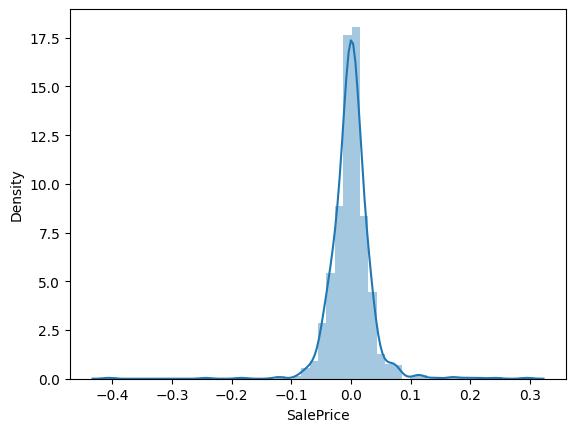

In [77]:
# Analyzing the residuals on the lasso_mean_absolute_error model
res_lasso_mean_absolute_error = y_train - y_pred_train_lasso_mean_absolute_error
sns.distplot(res_lasso_mean_absolute_error, kde = True)
plt.show()

In [78]:
# Filtering the predictors selected for the final model
selected_predictors = coeffs[coeffs['Lasso_mean_abs_err'] != 0]['Lasso_mean_abs_err'].index
selected_predictors

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'CentralAir', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       ...
       'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'MoSold_10',
       'SaleType_New', 'SaleType_WD', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=147)

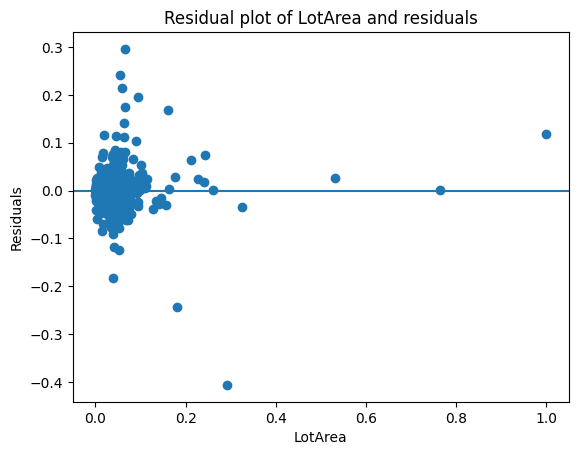

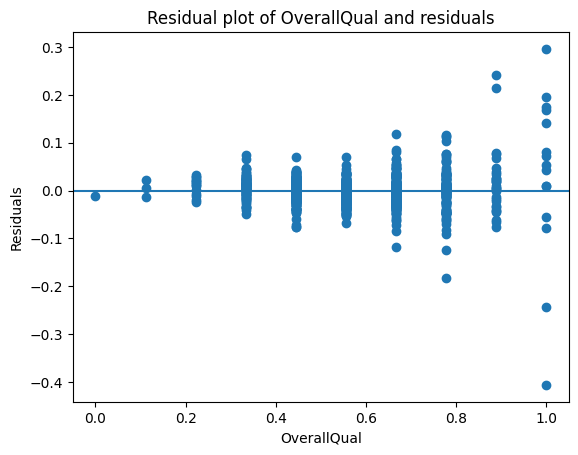

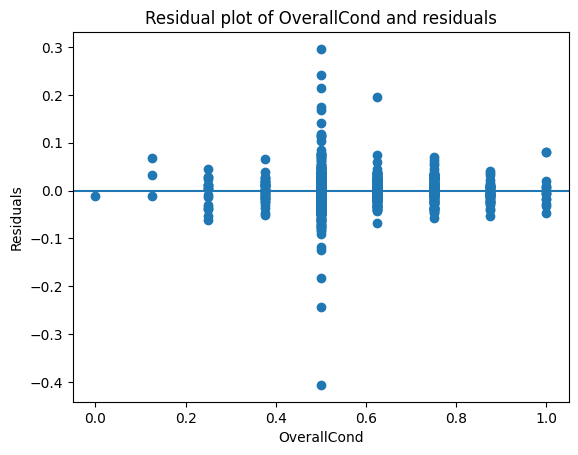

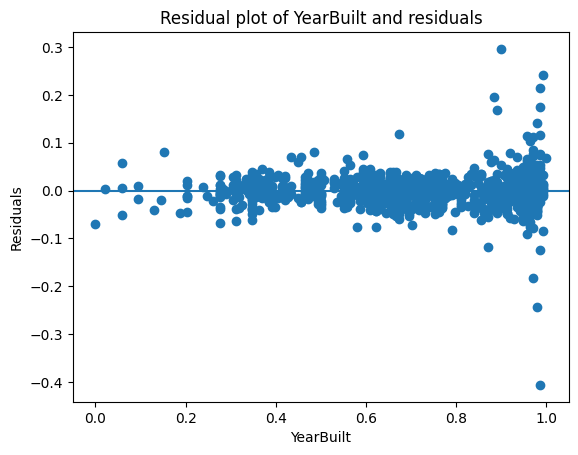

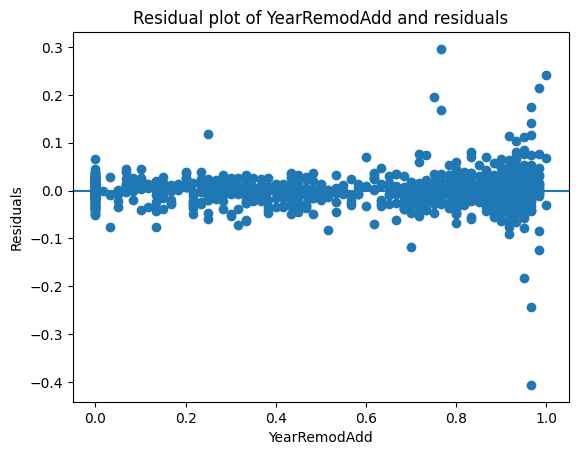

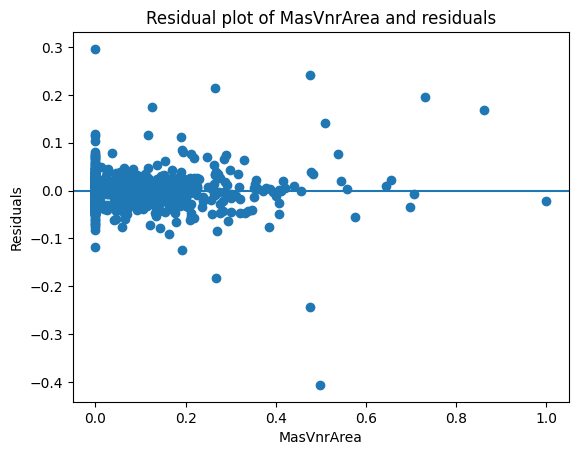

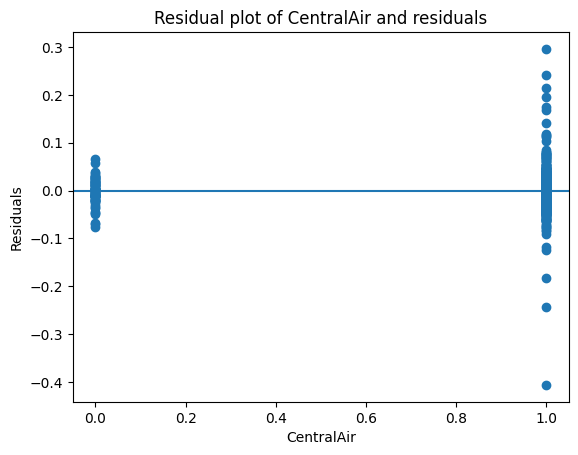

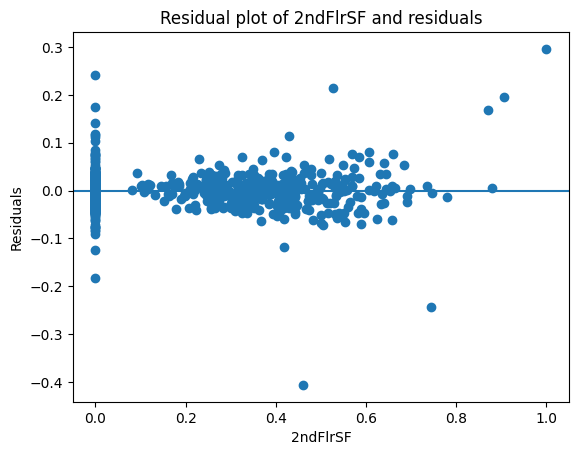

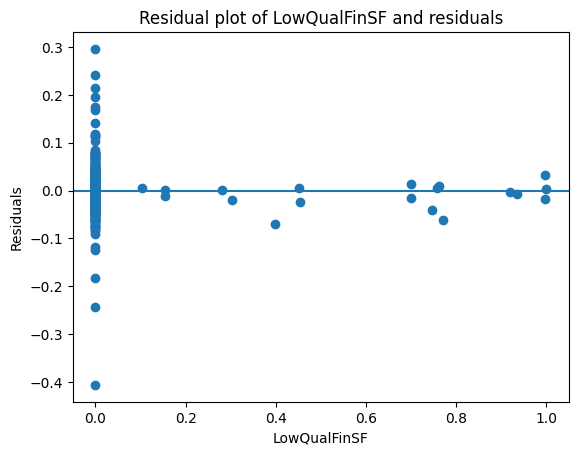

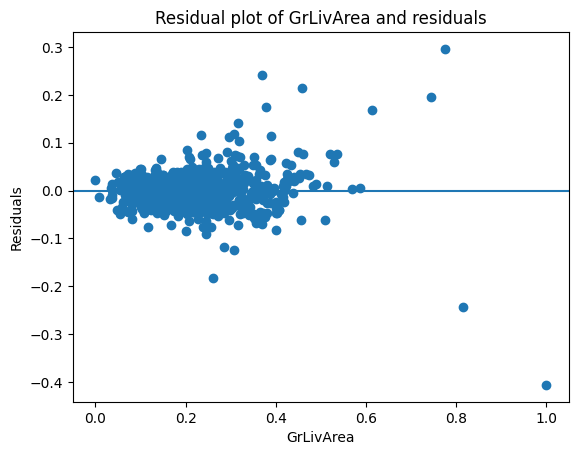

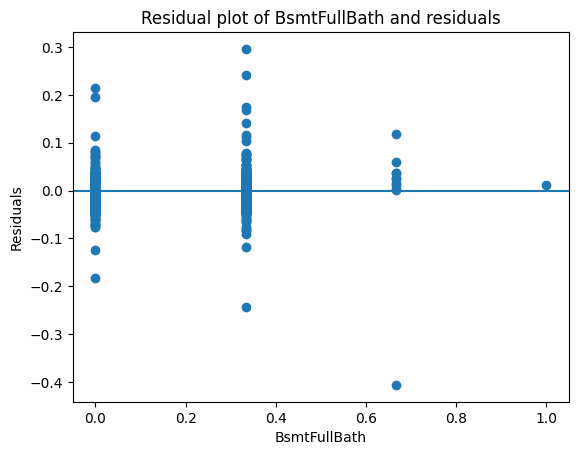

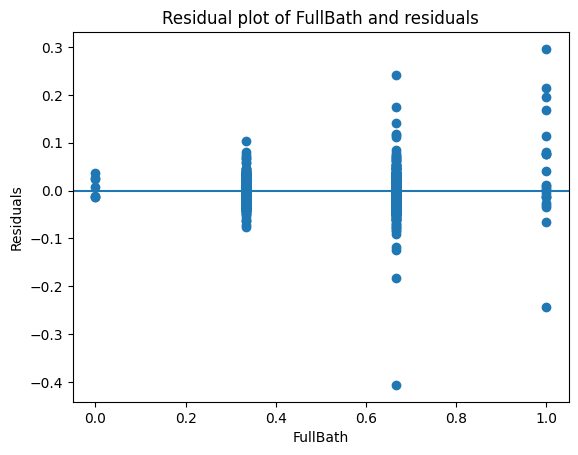

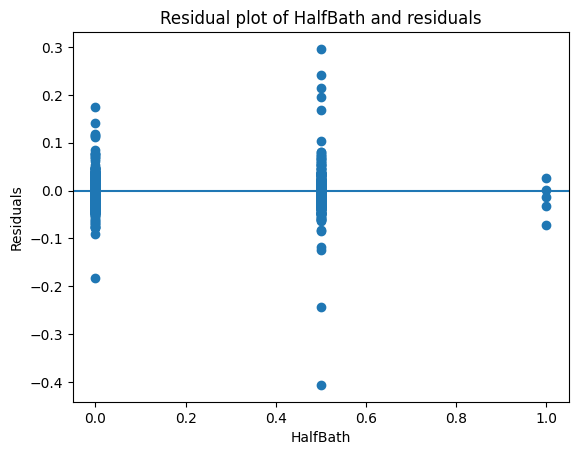

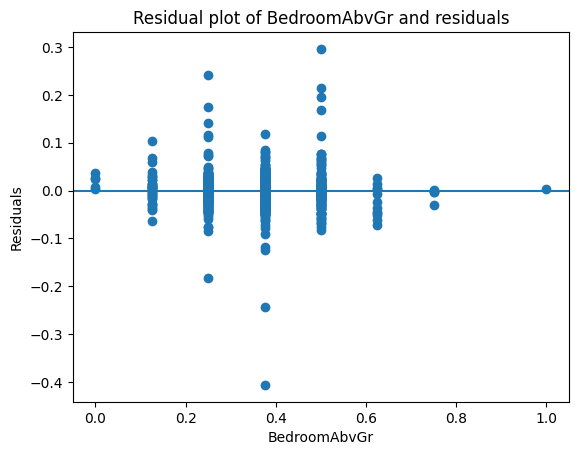

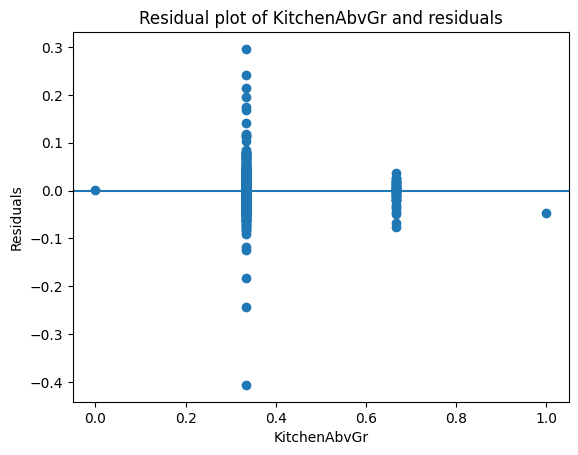

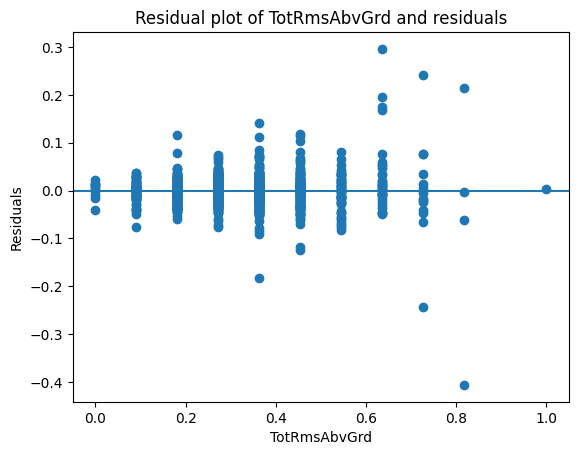

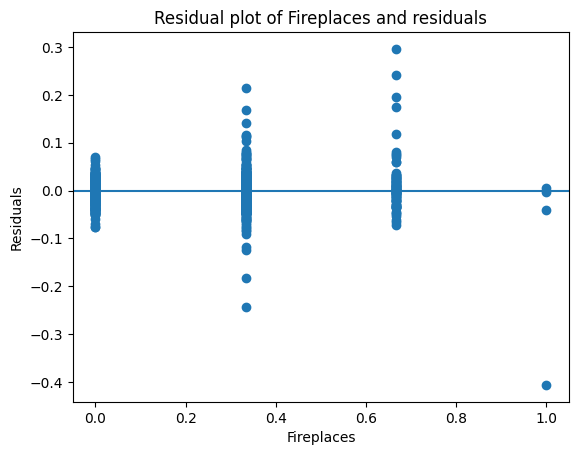

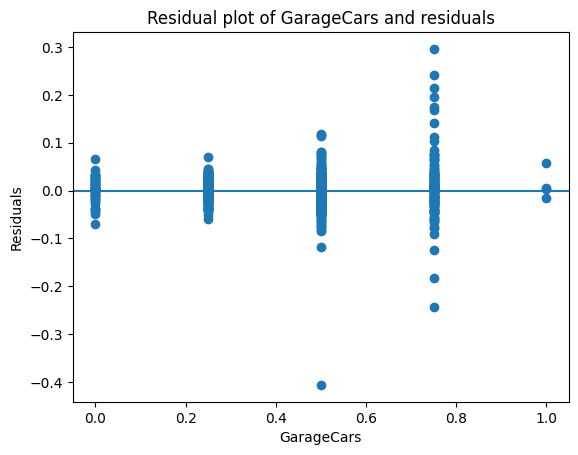

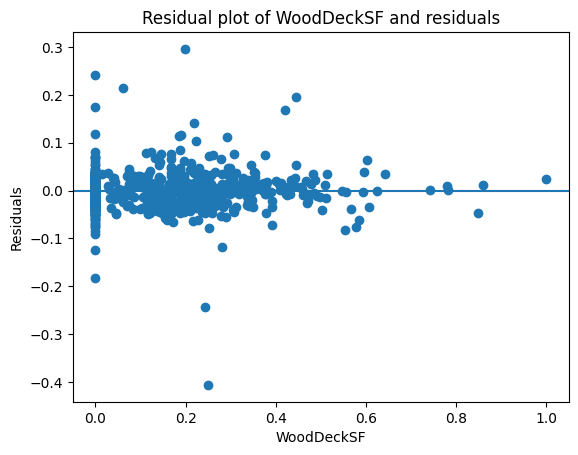

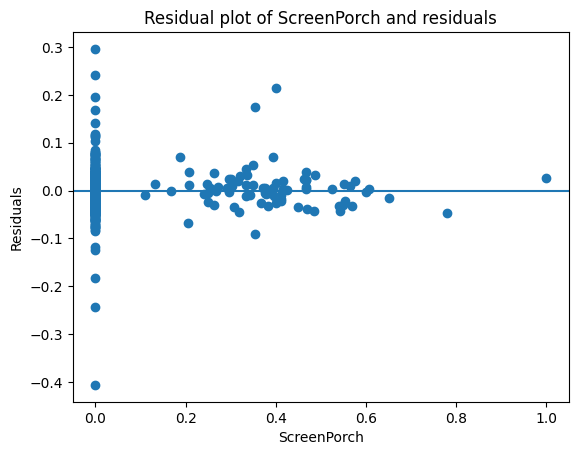

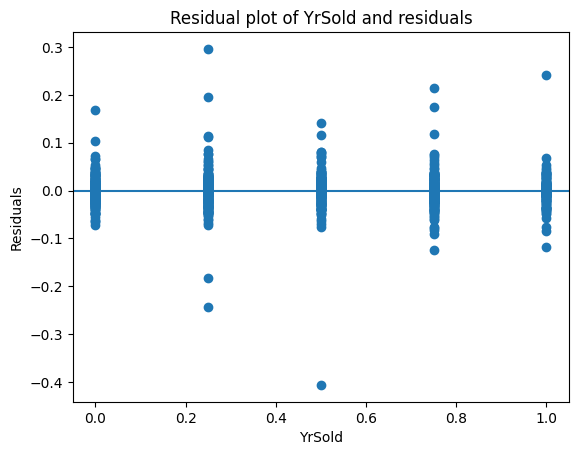

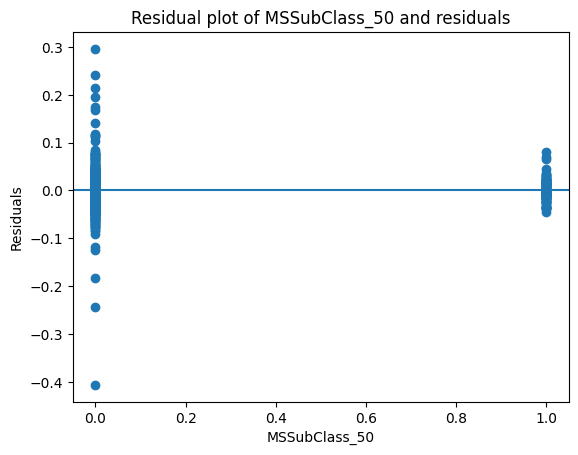

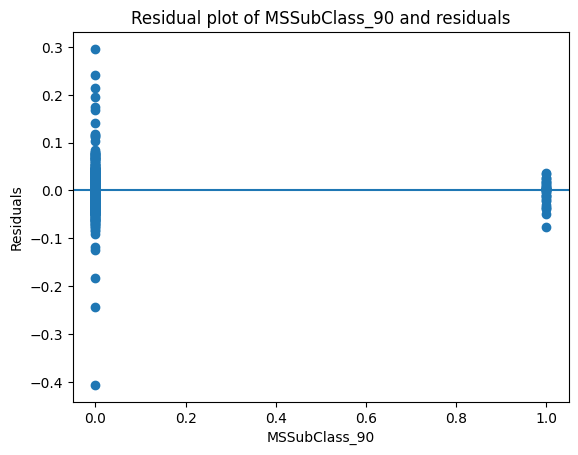

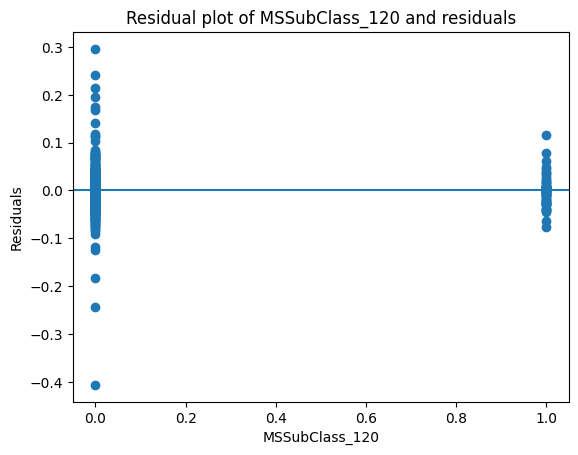

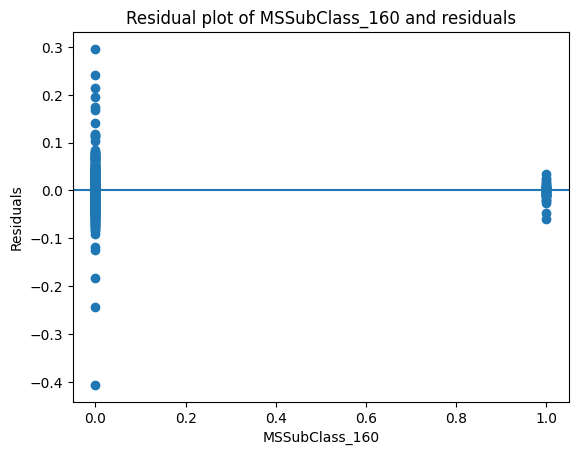

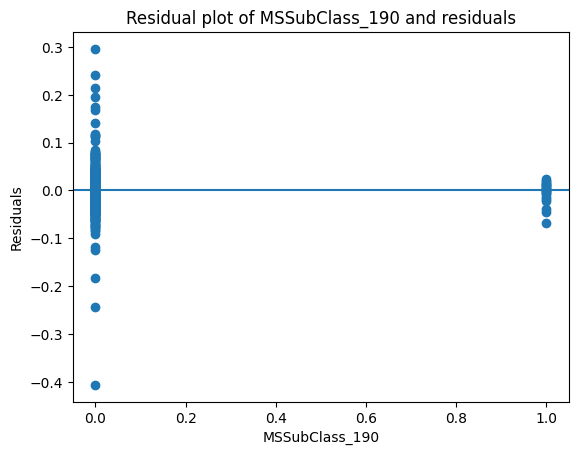

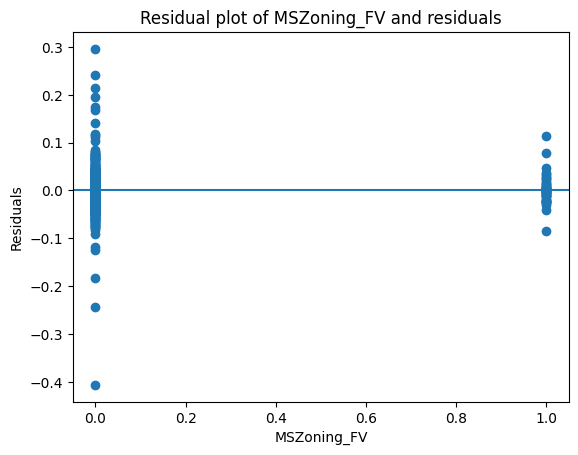

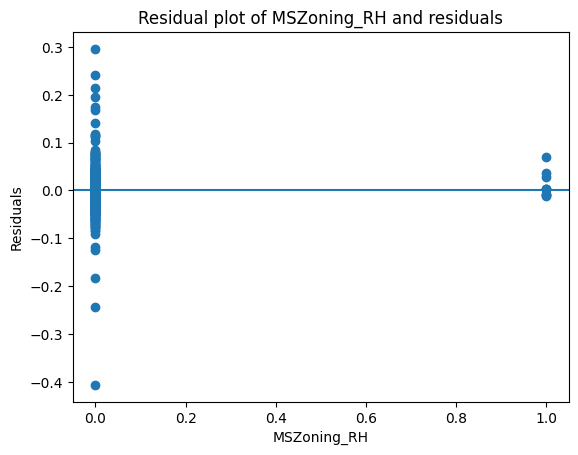

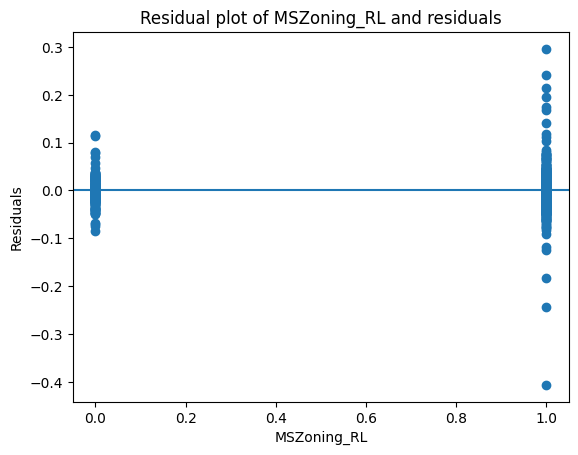

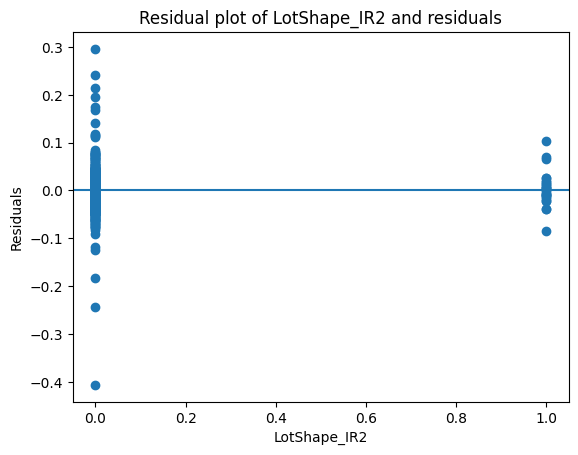

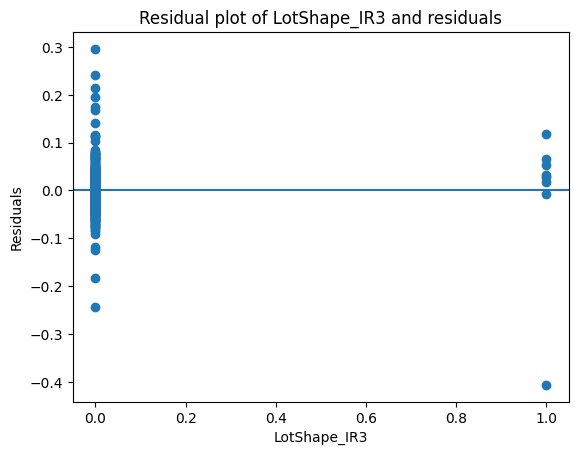

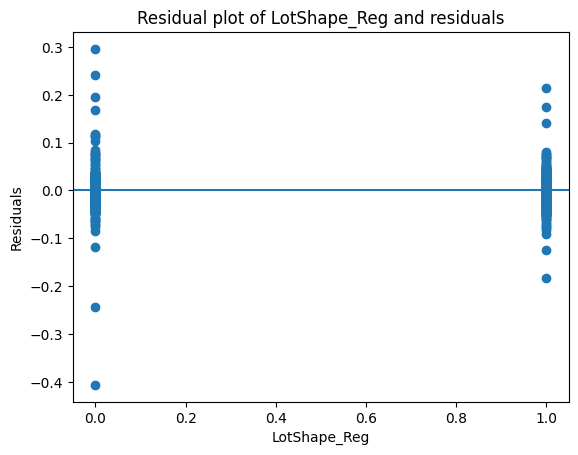

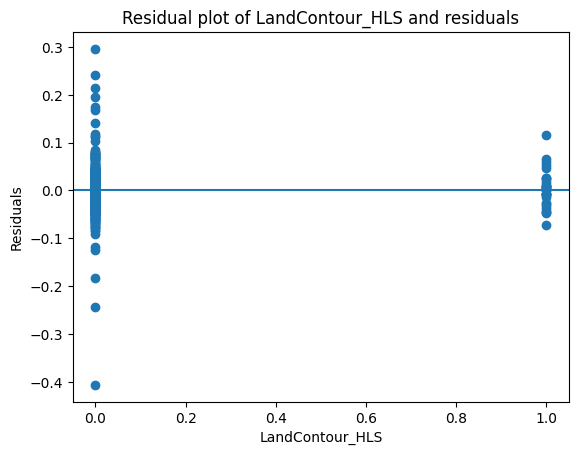

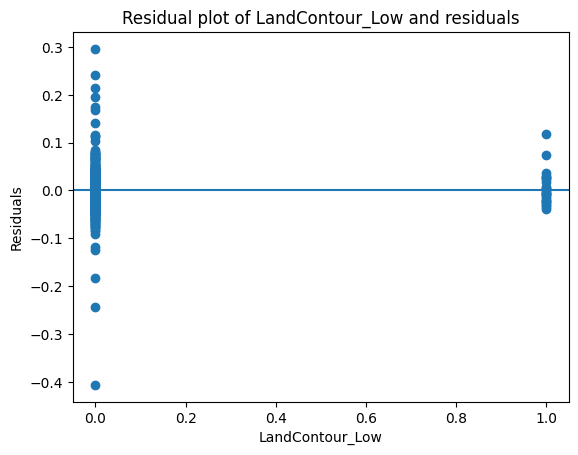

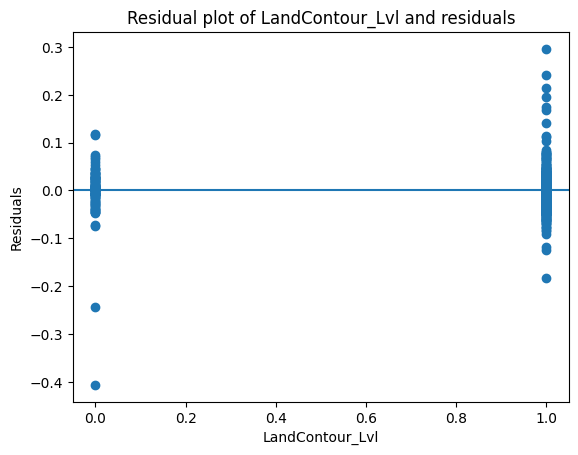

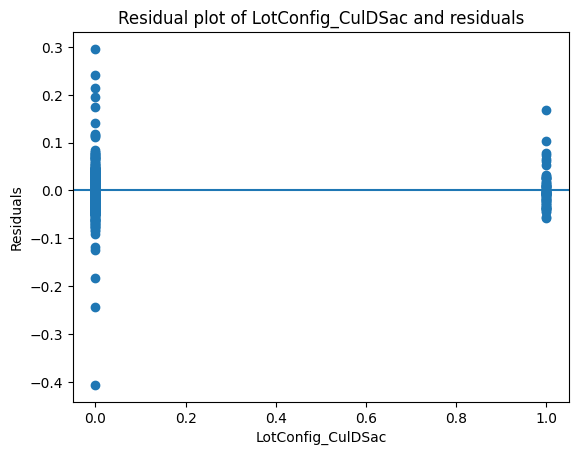

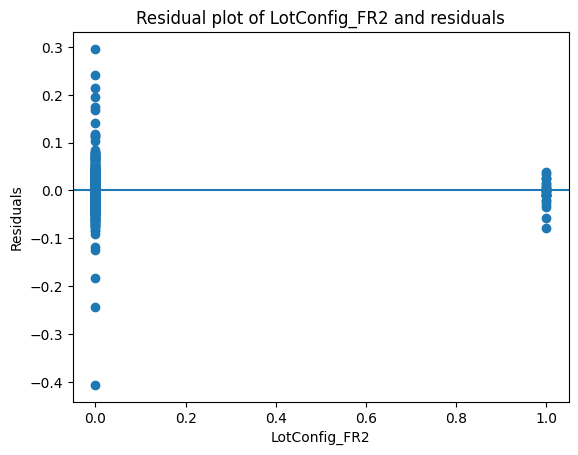

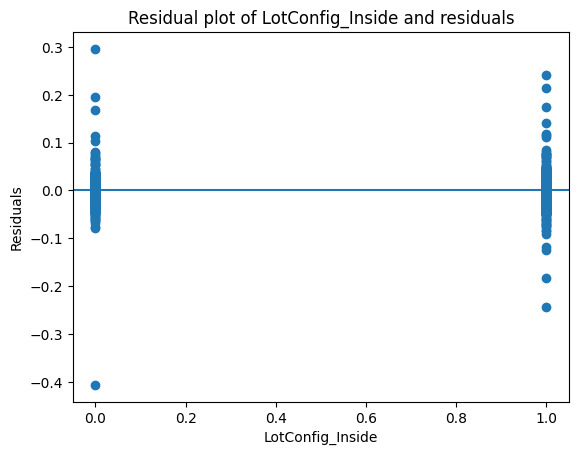

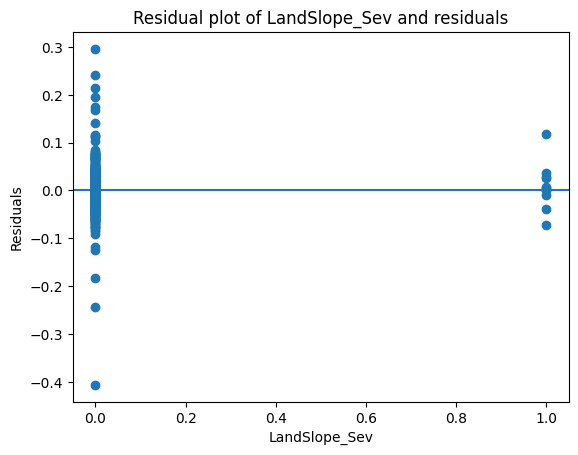

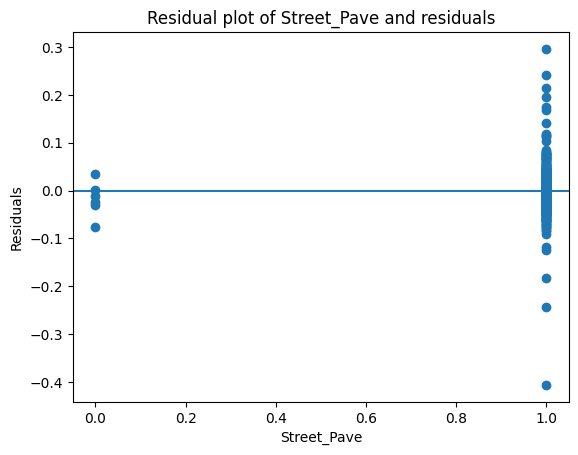

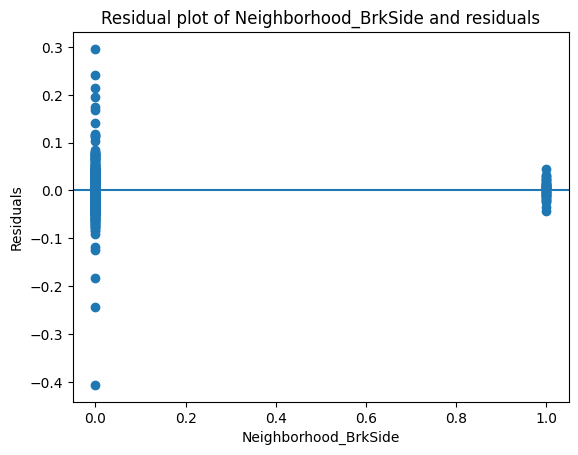

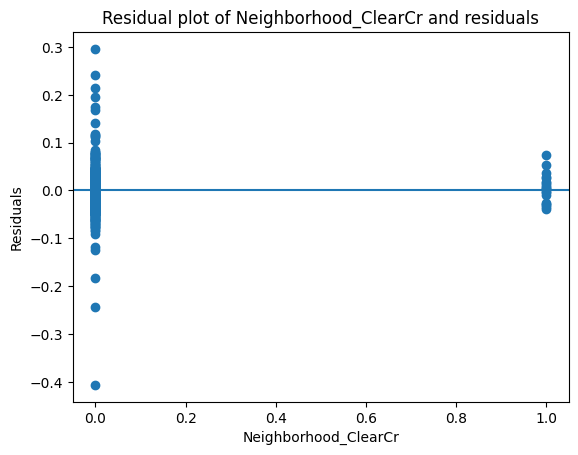

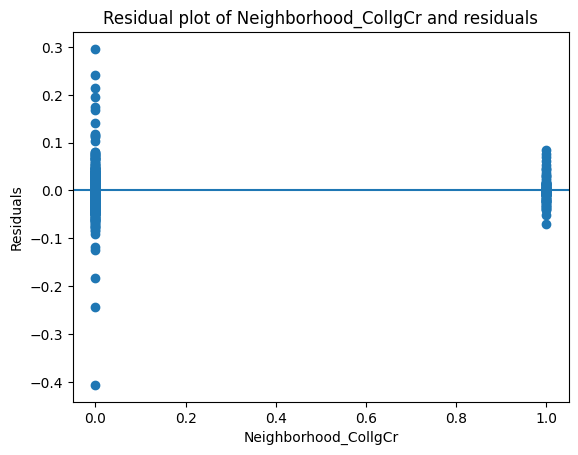

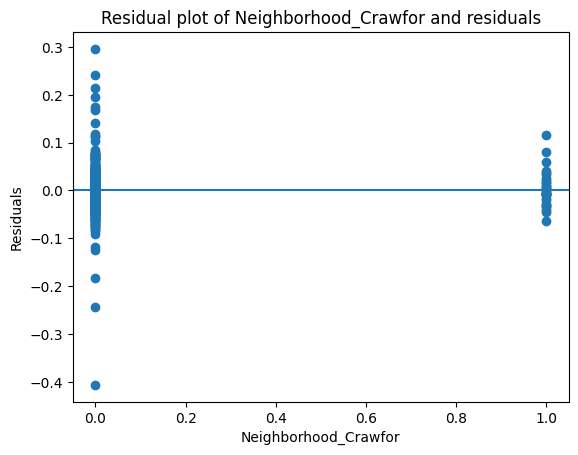

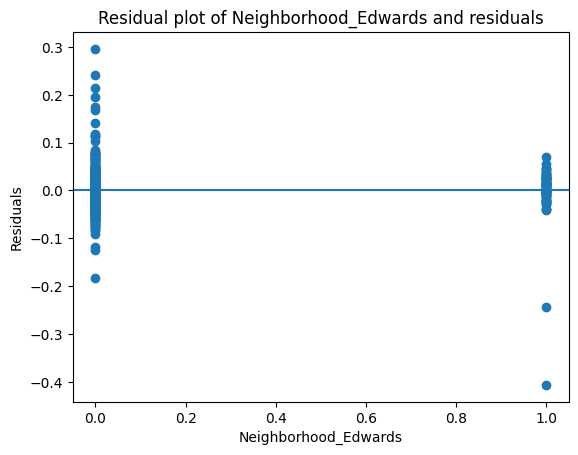

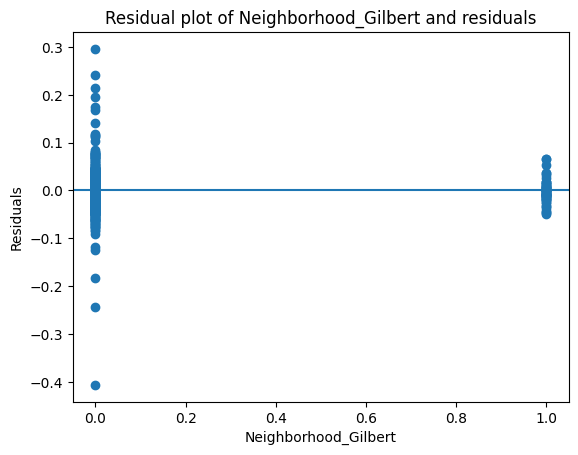

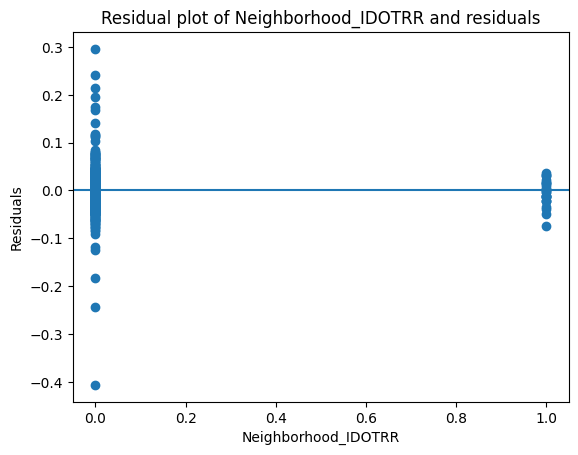

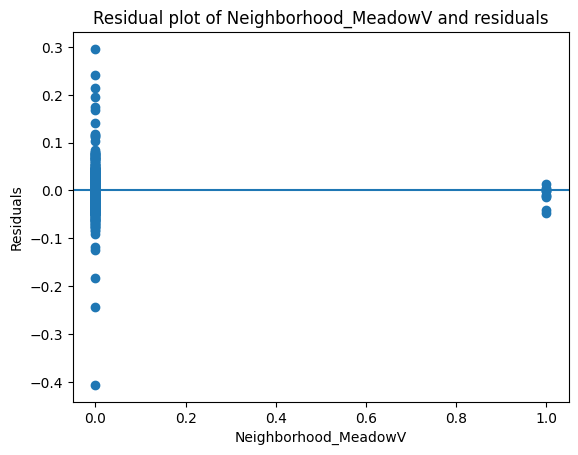

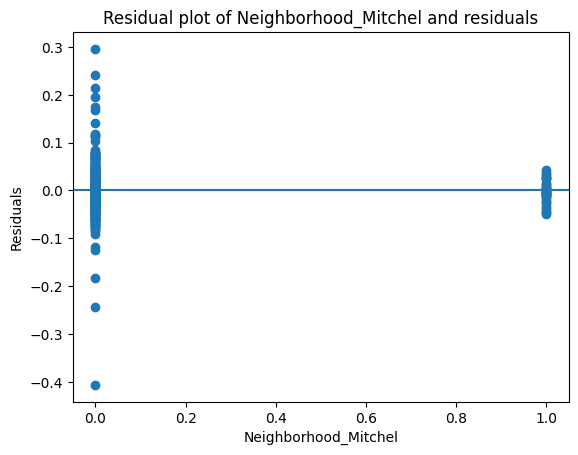

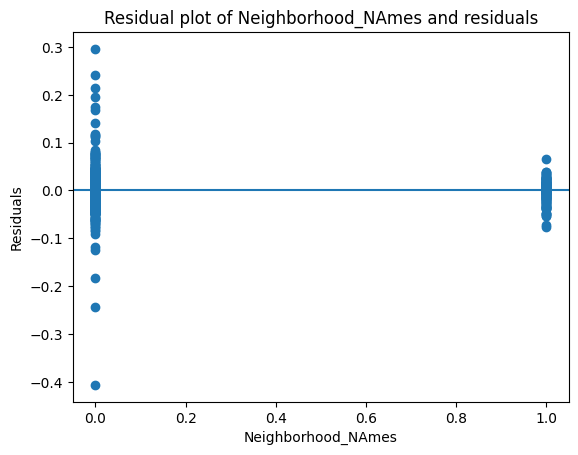

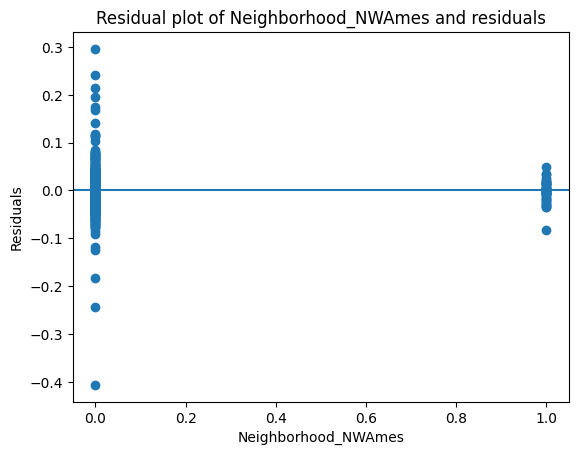

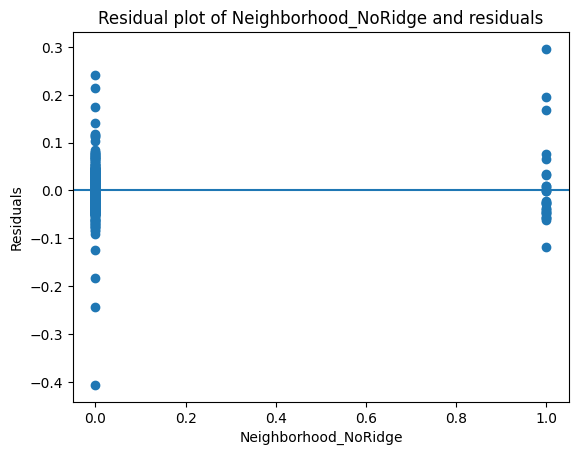

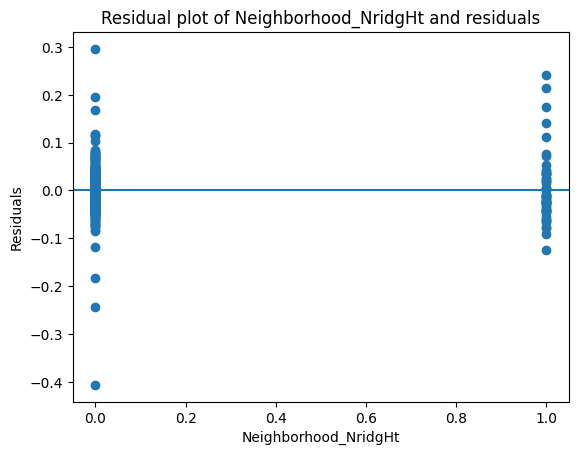

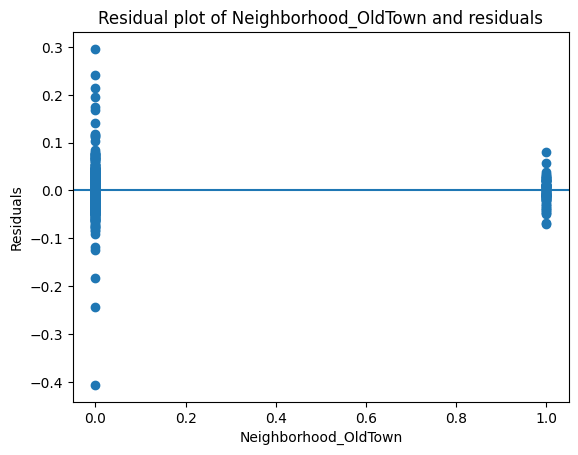

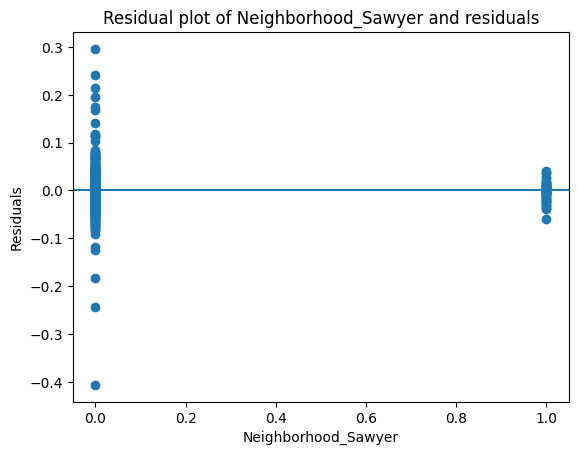

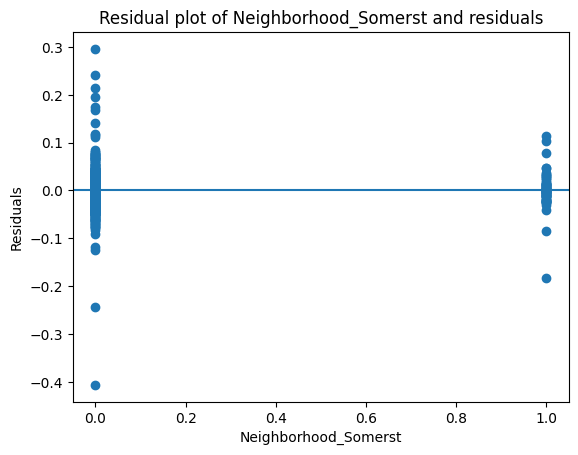

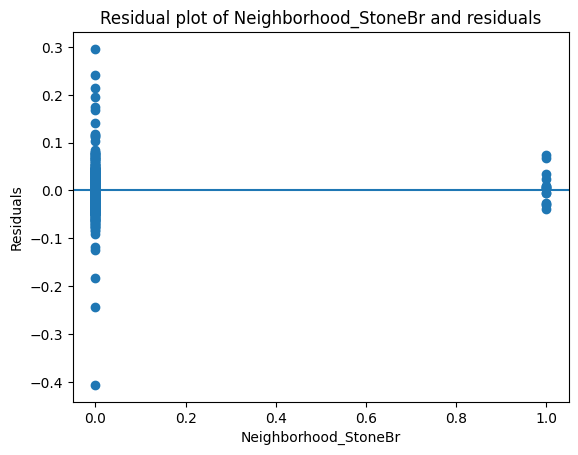

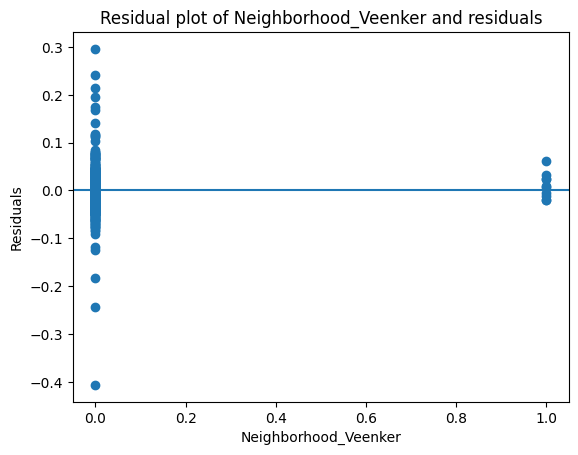

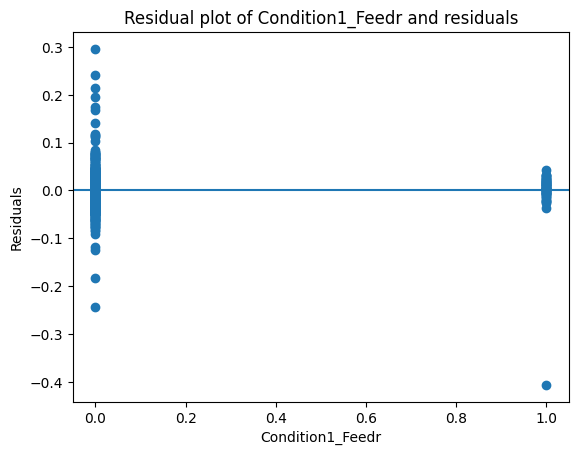

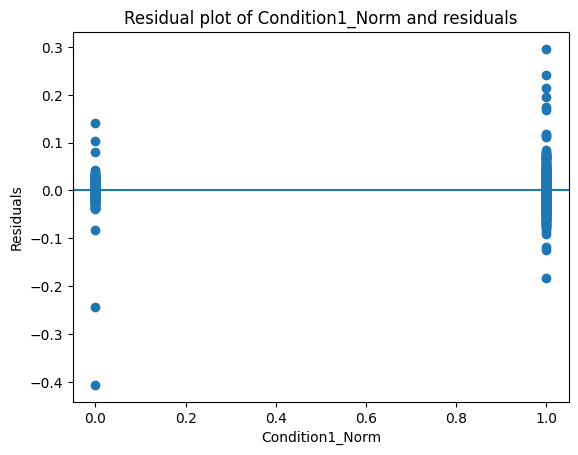

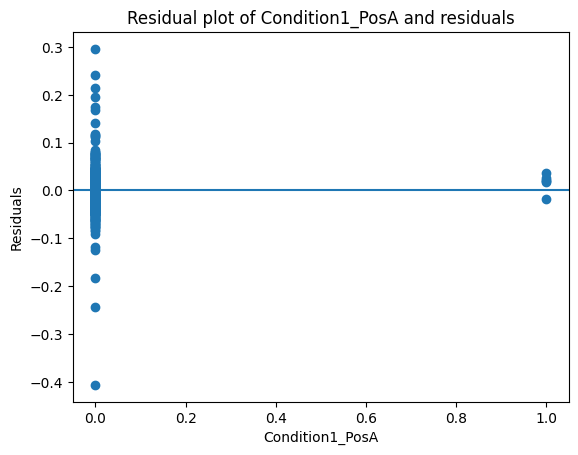

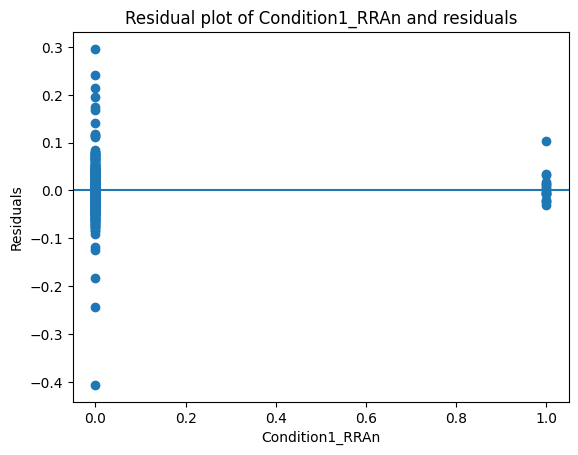

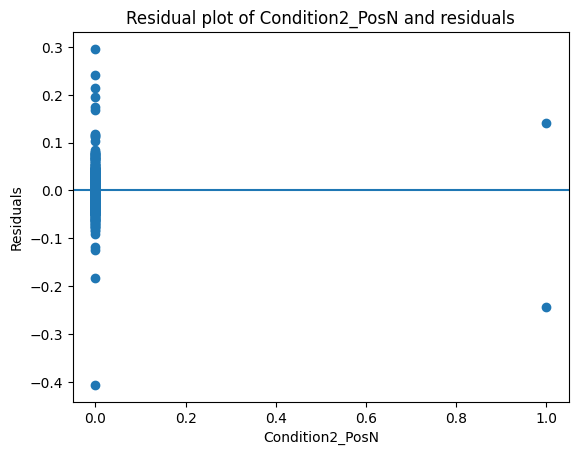

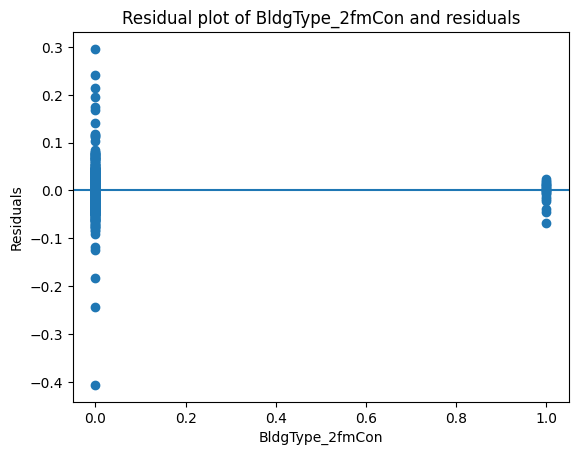

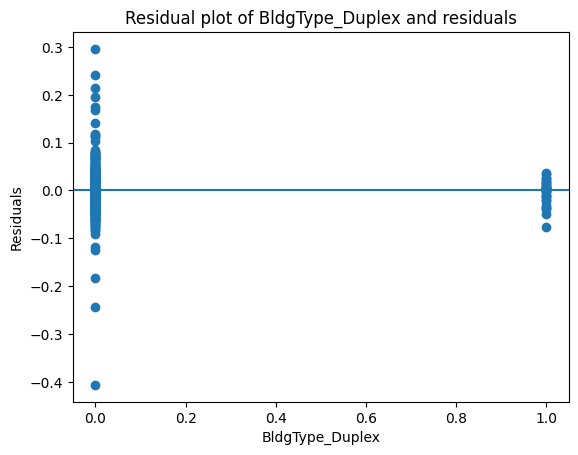

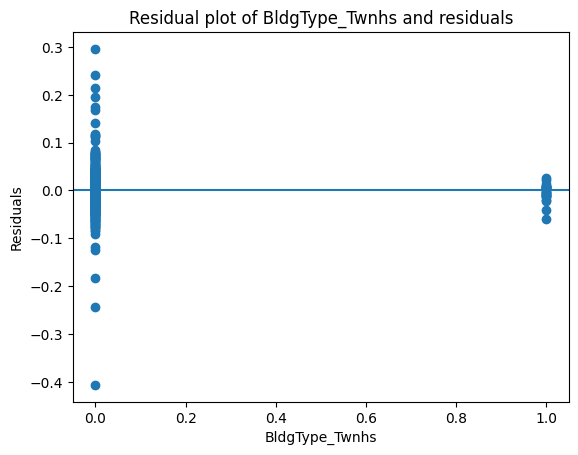

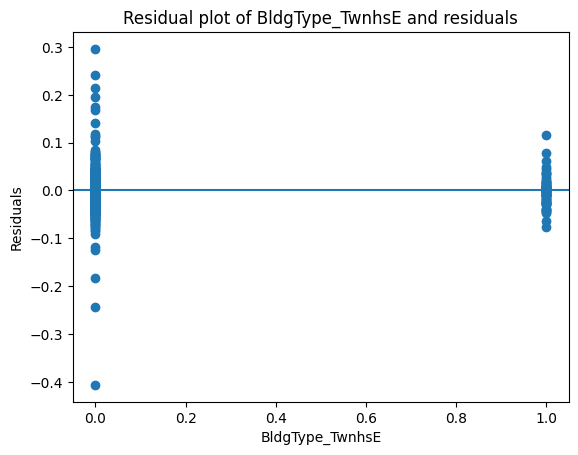

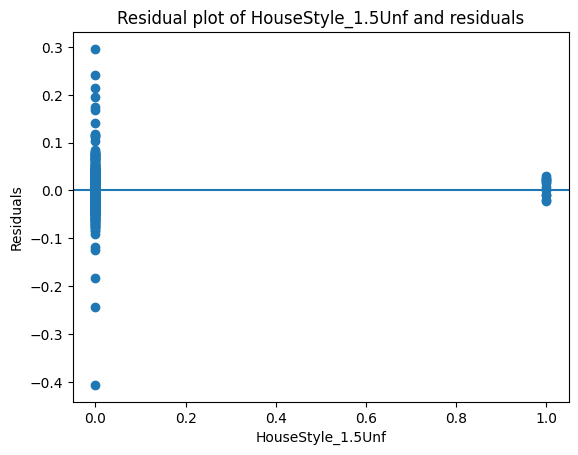

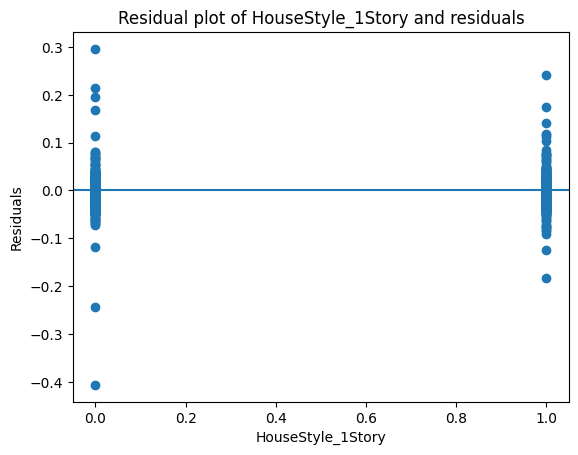

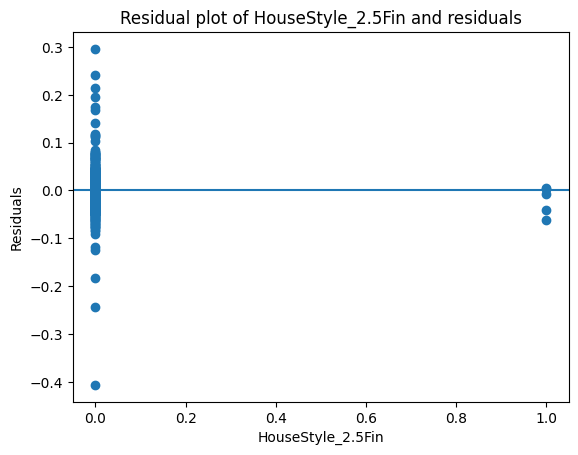

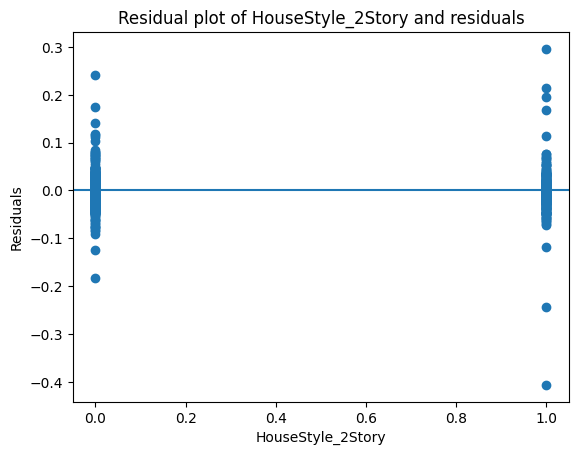

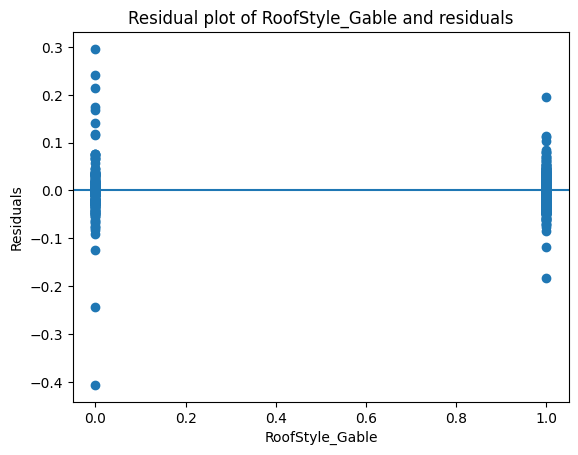

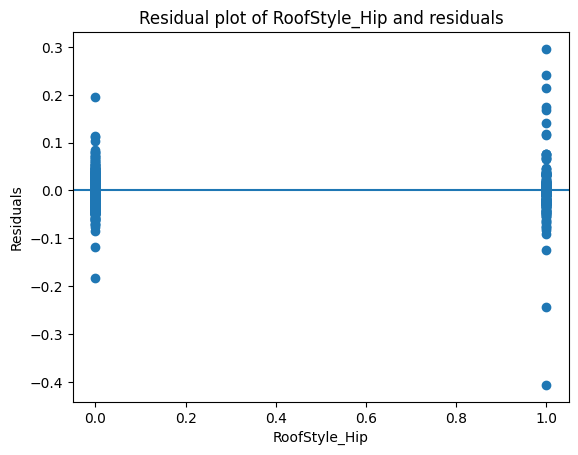

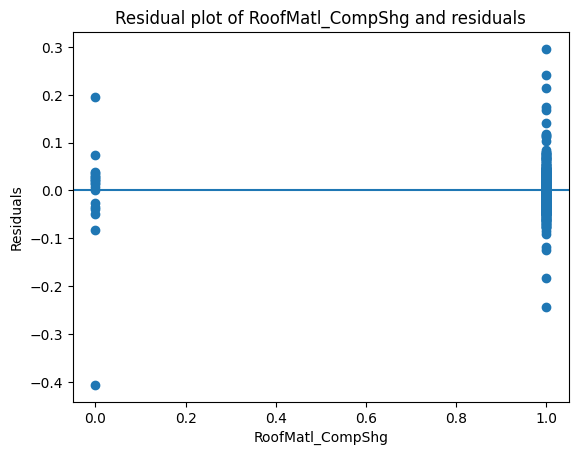

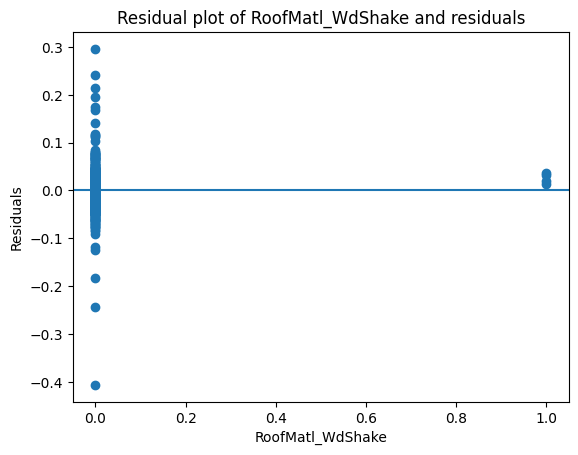

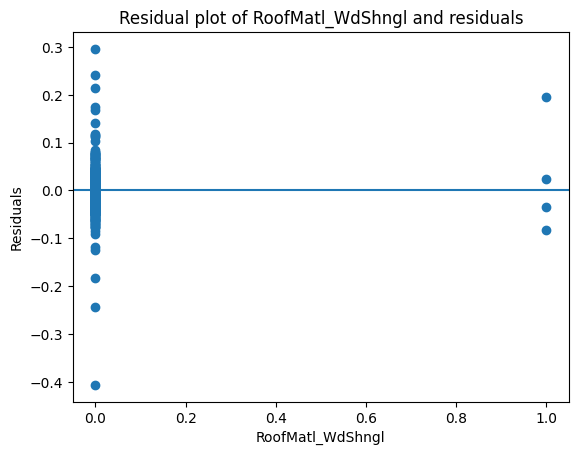

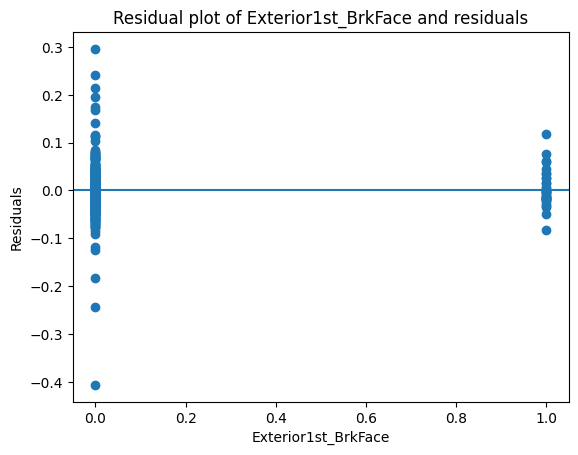

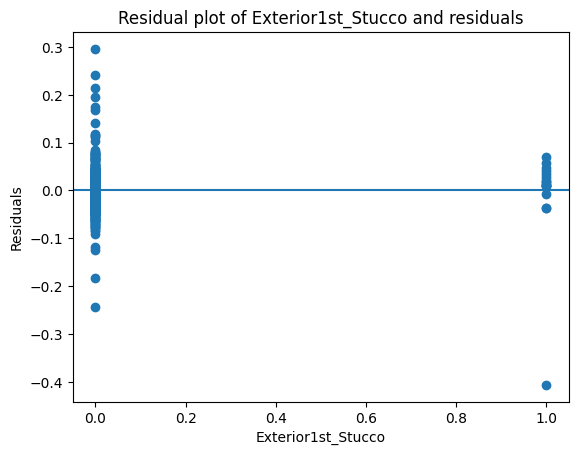

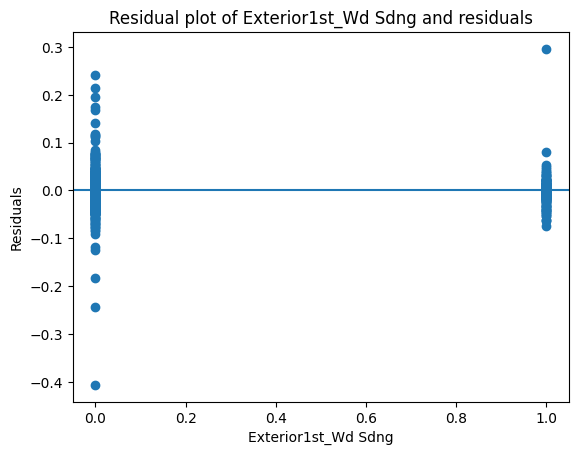

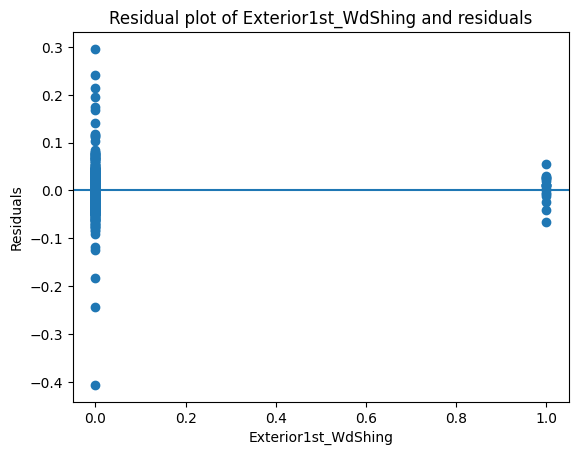

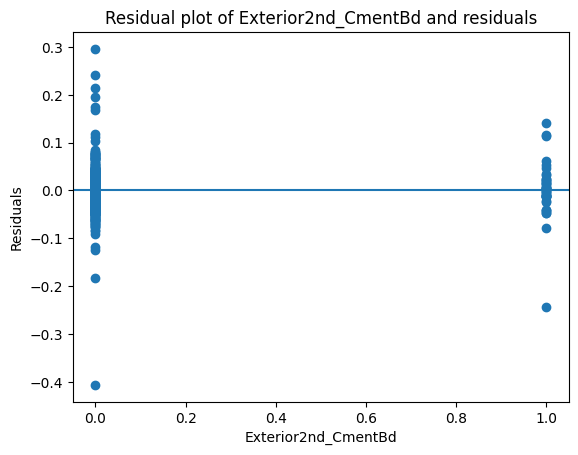

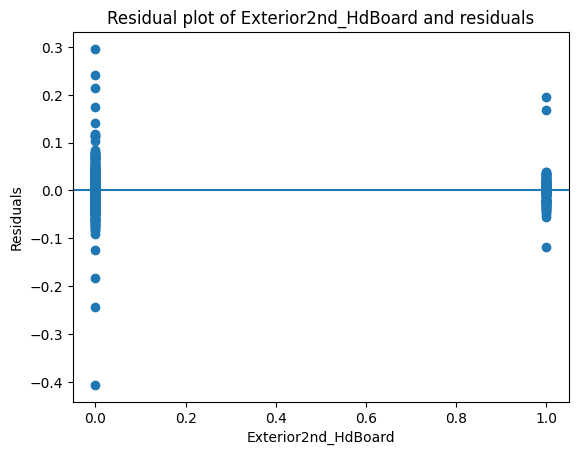

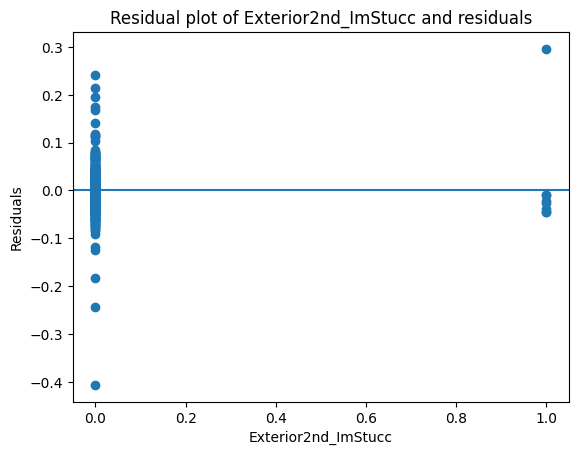

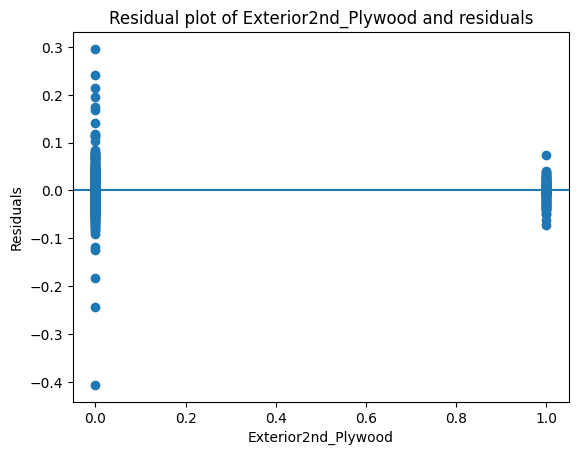

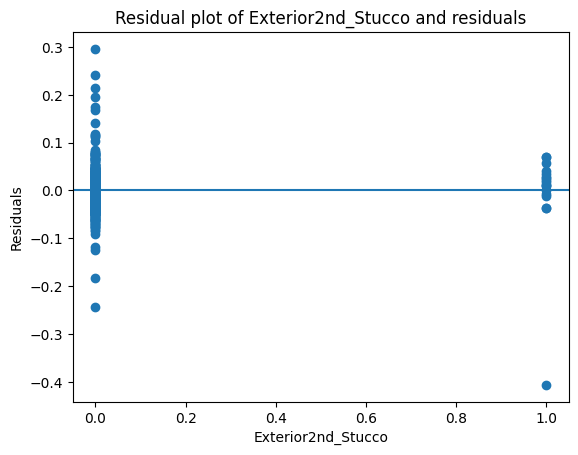

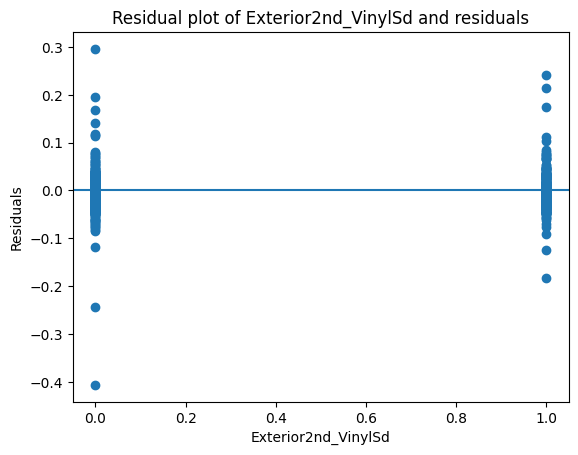

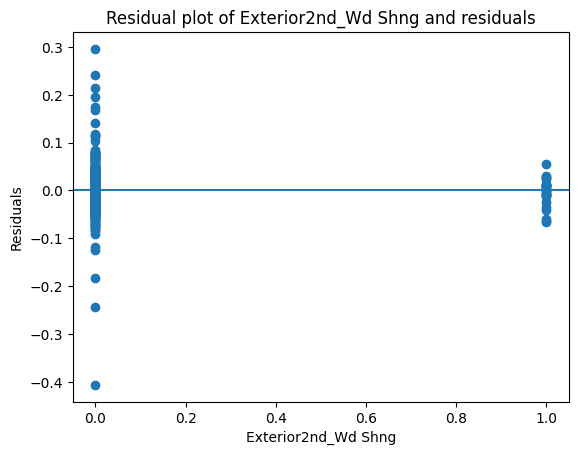

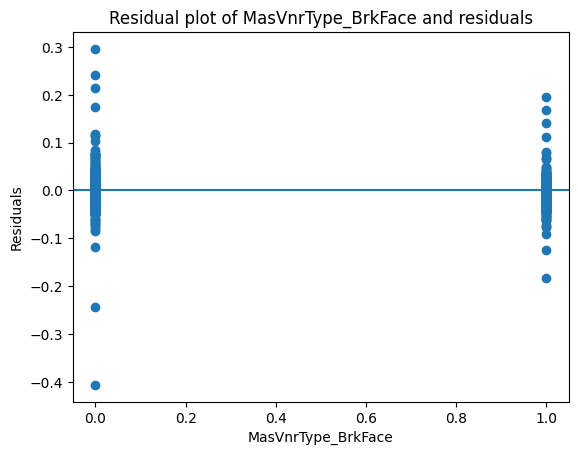

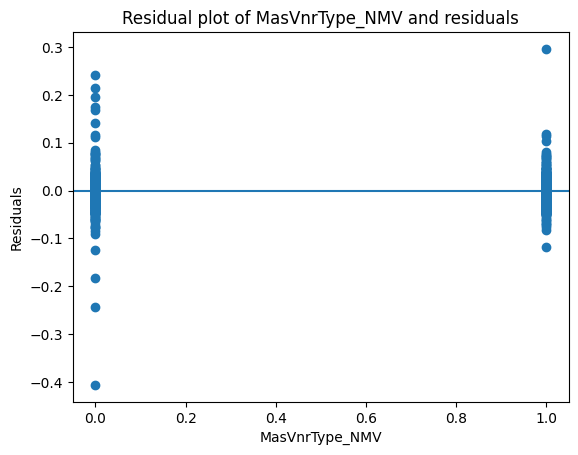

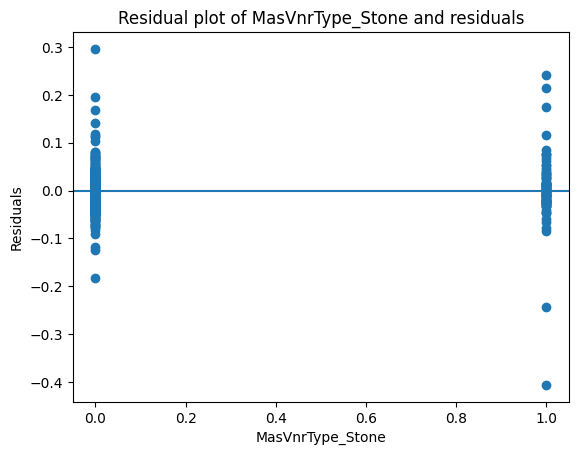

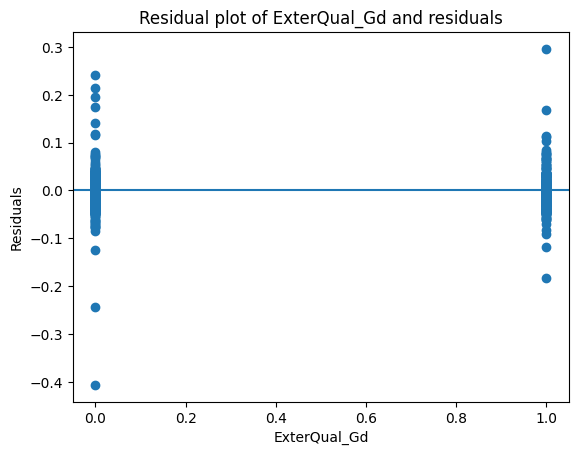

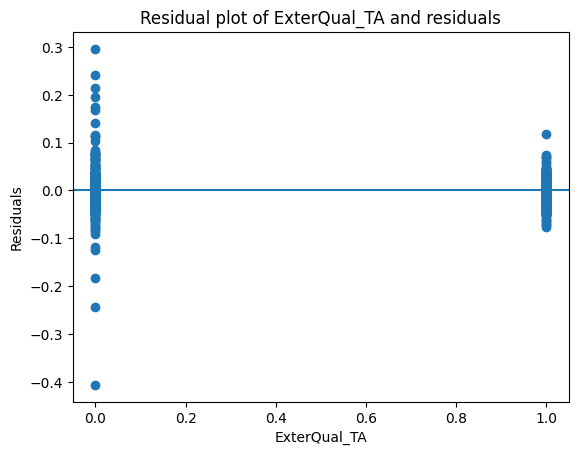

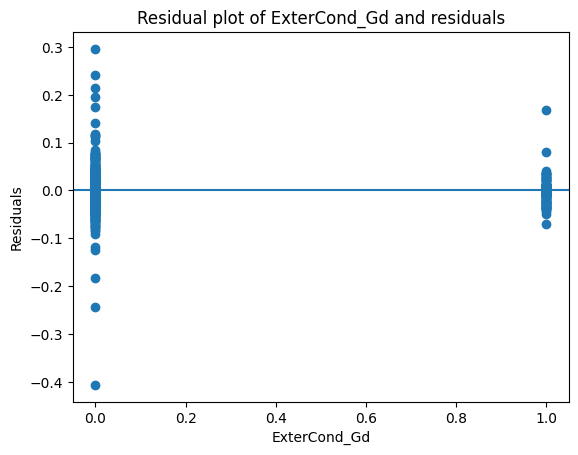

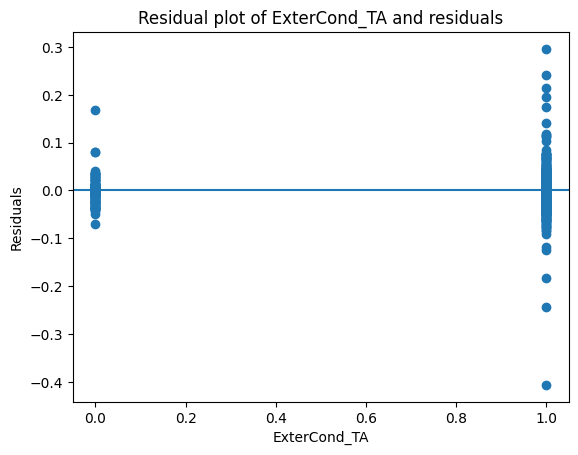

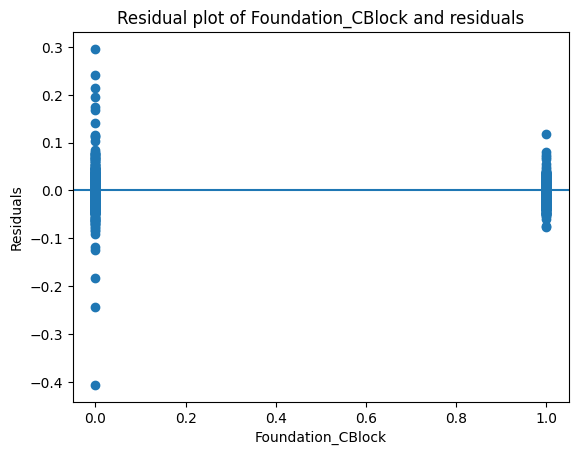

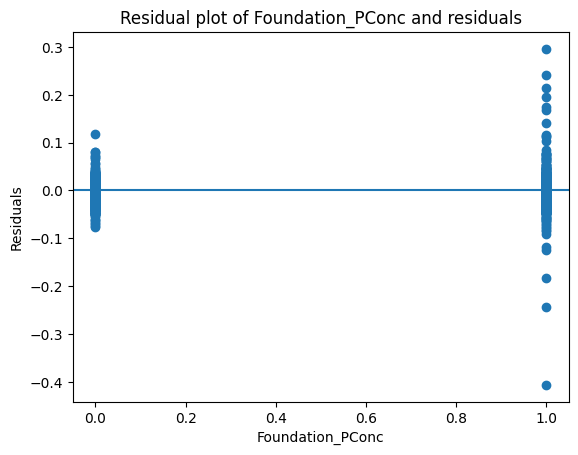

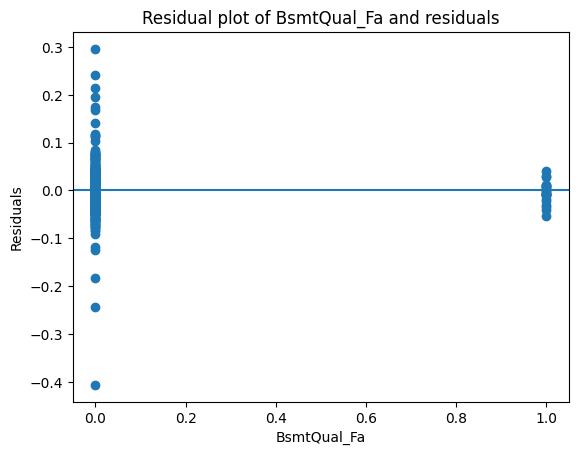

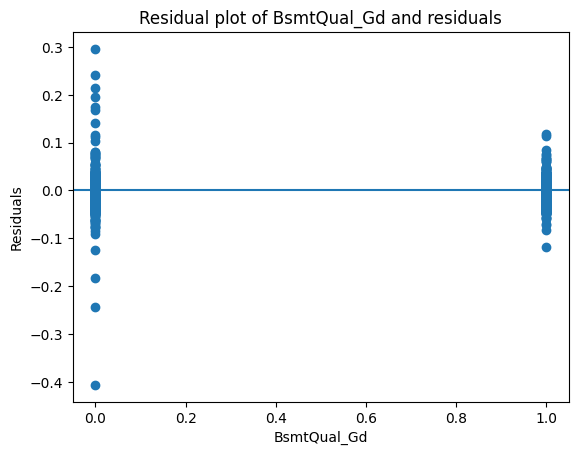

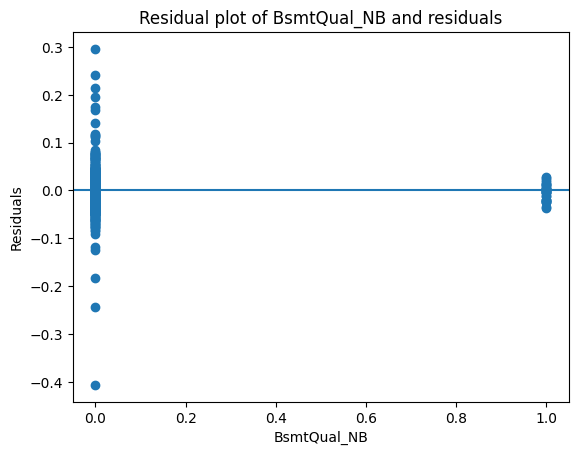

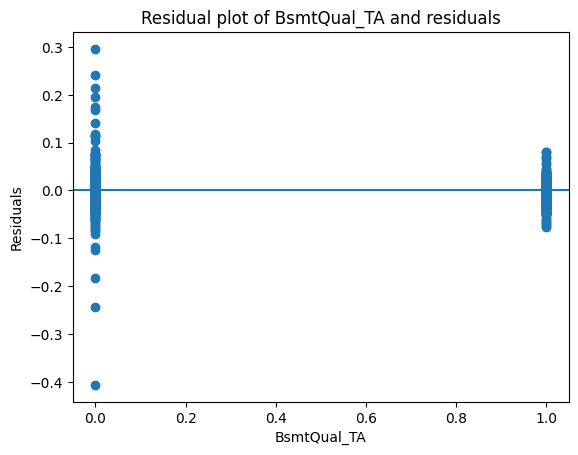

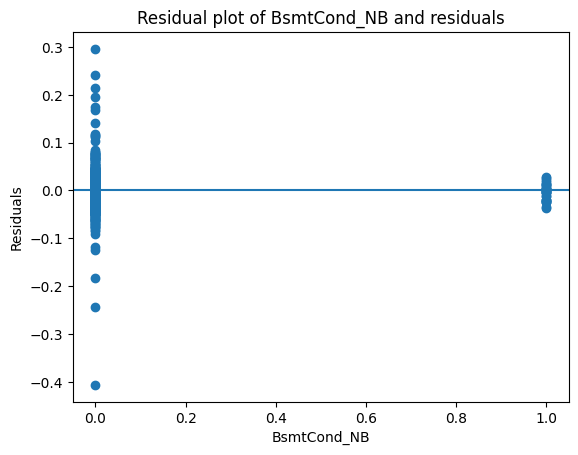

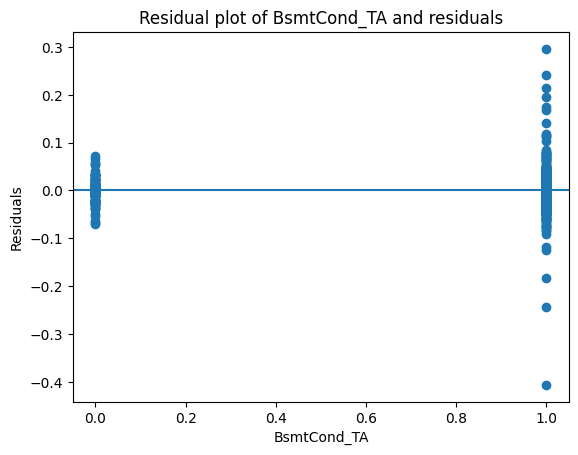

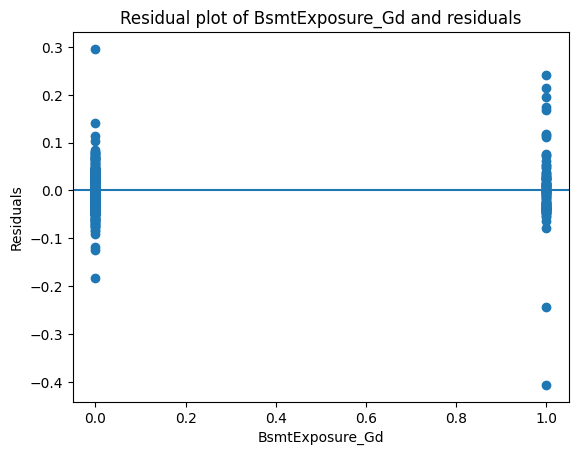

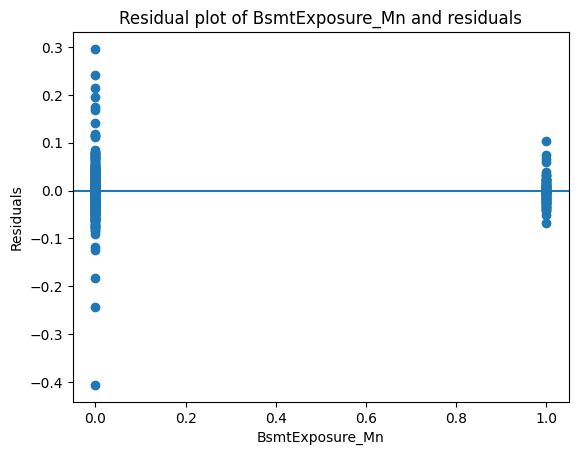

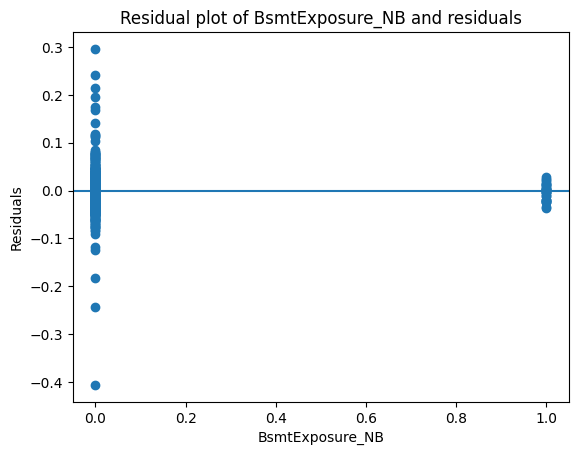

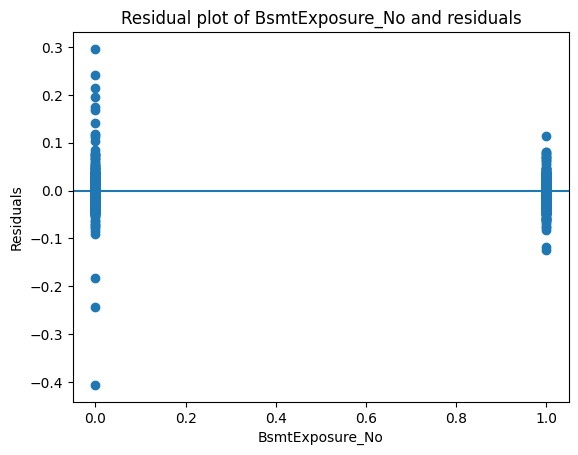

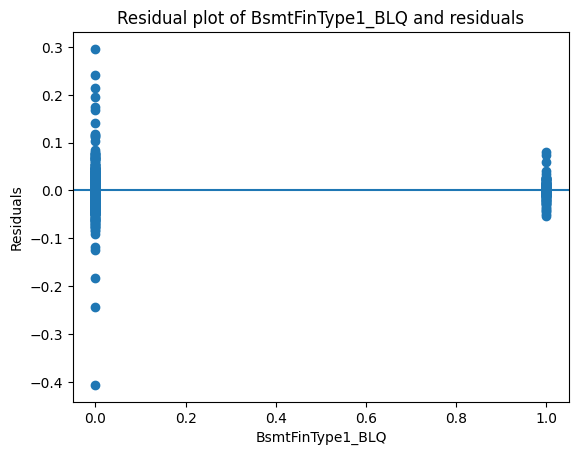

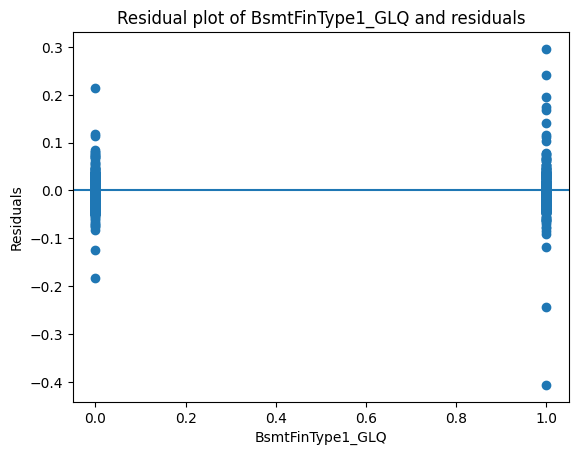

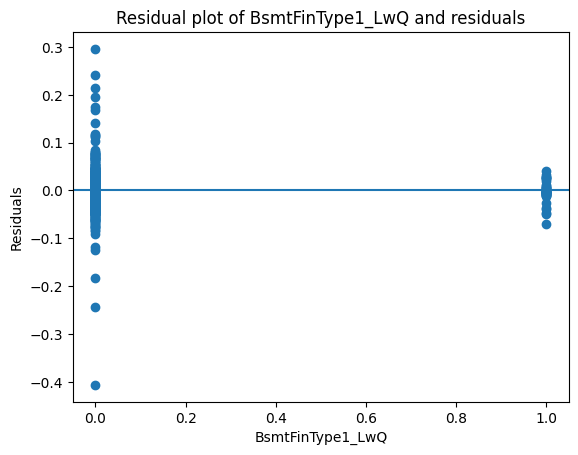

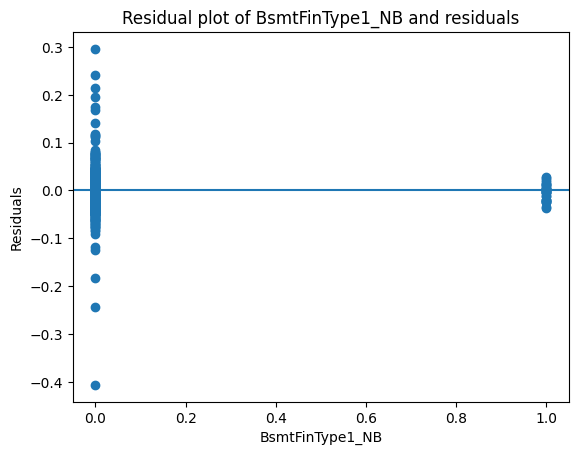

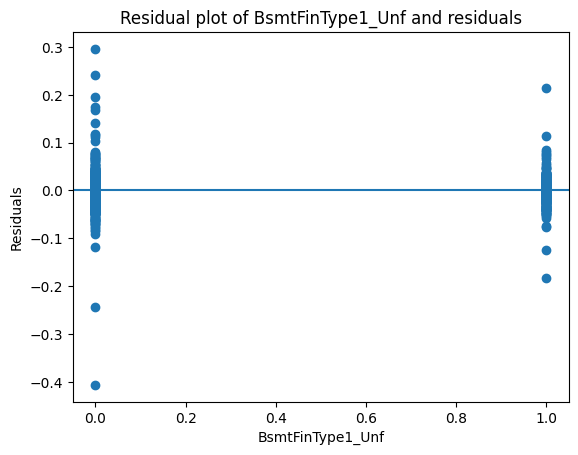

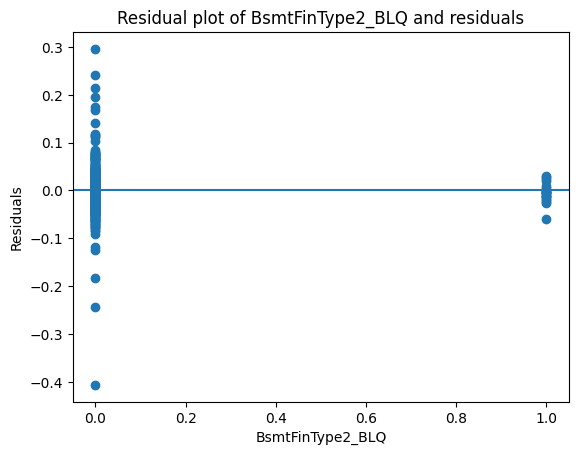

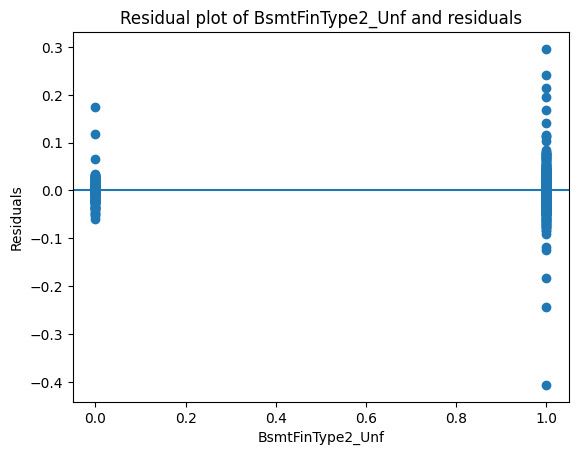

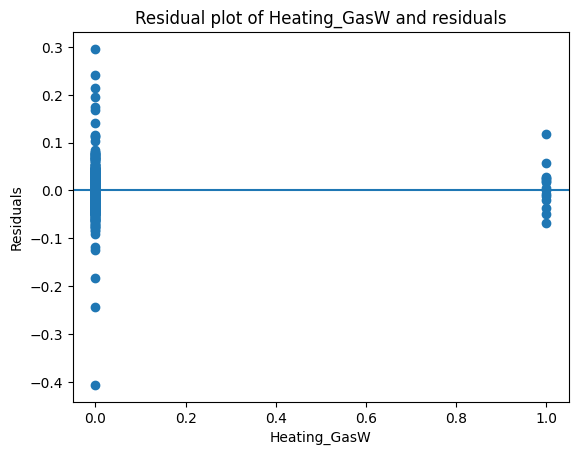

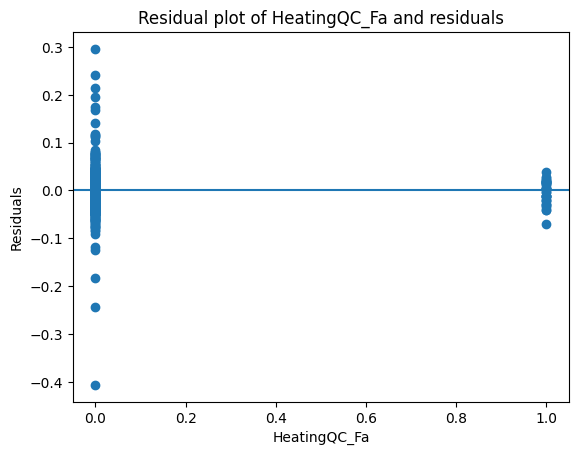

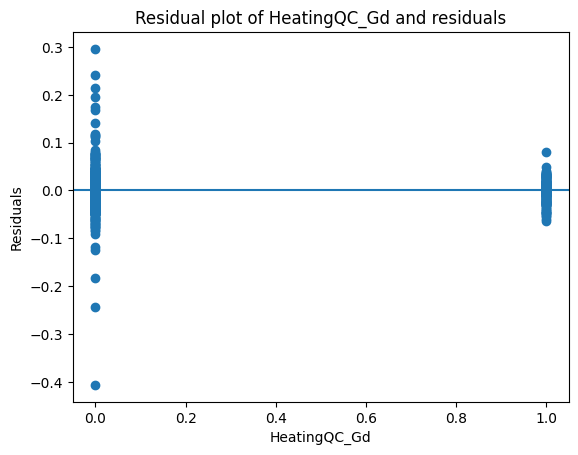

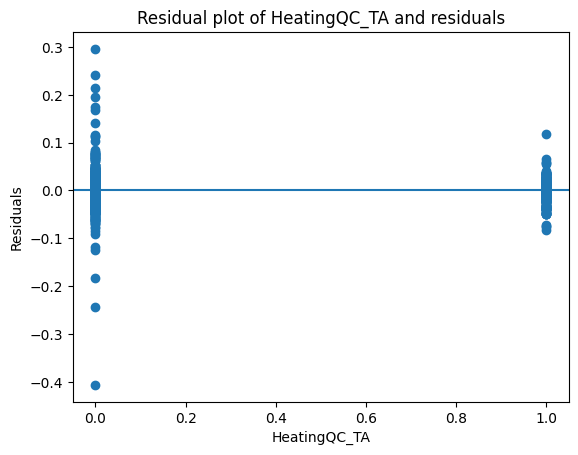

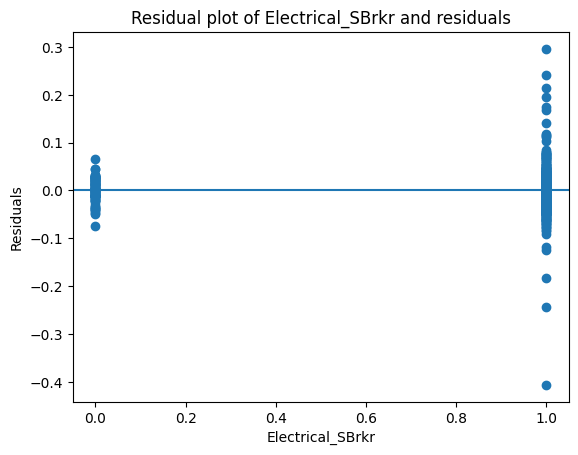

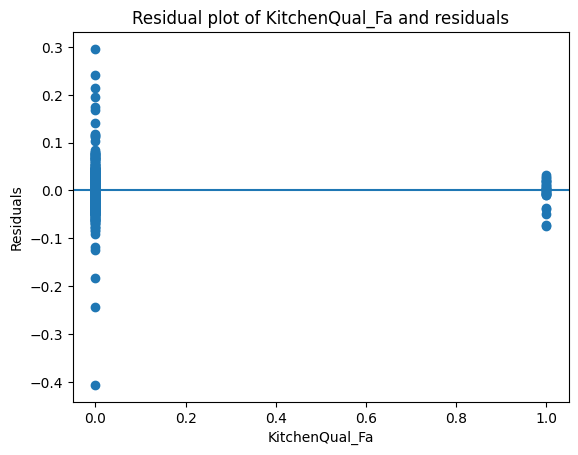

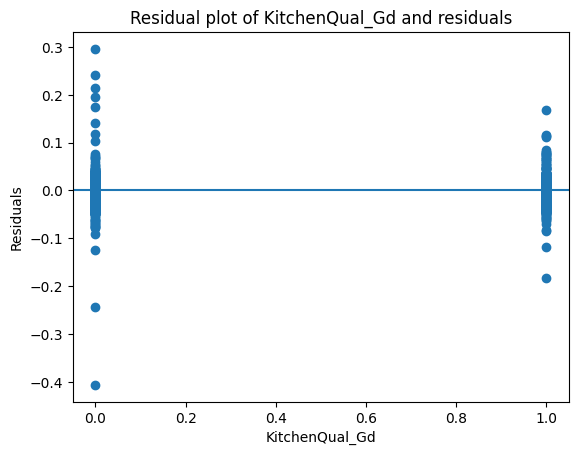

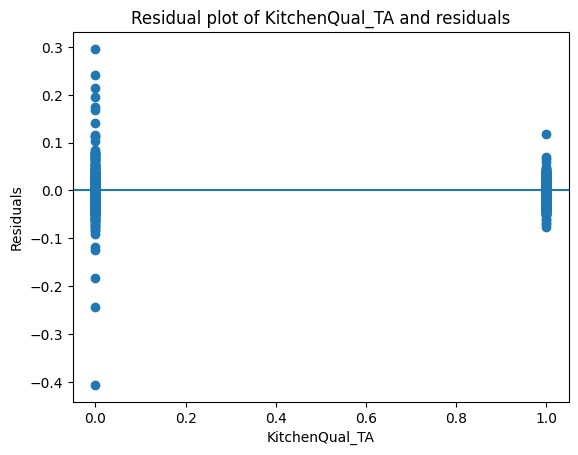

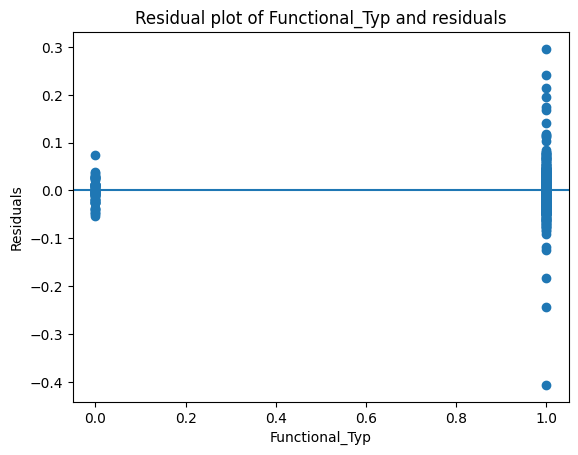

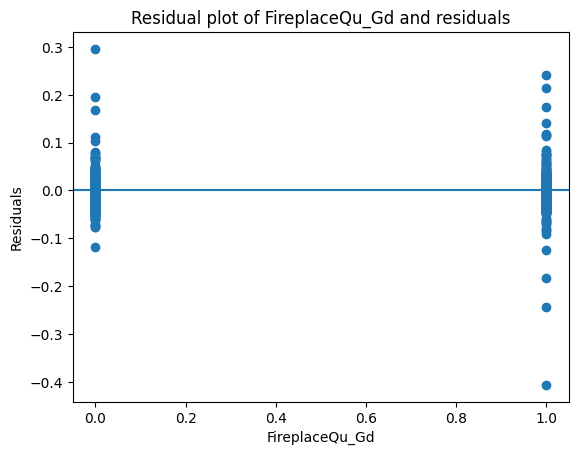

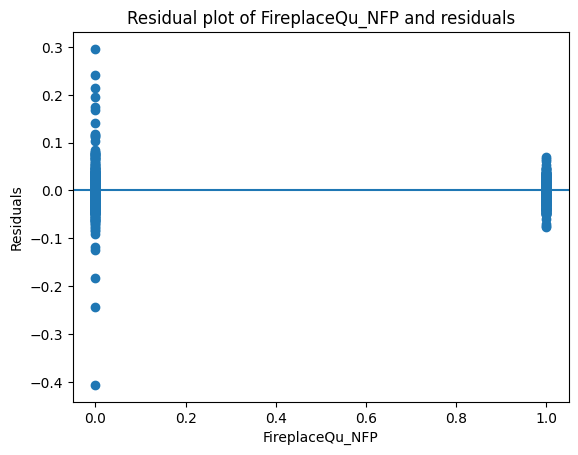

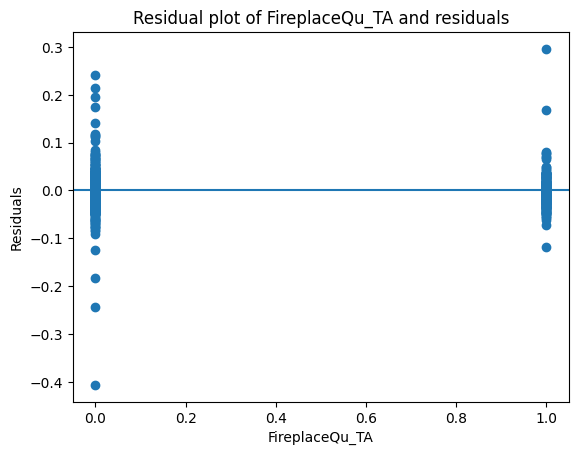

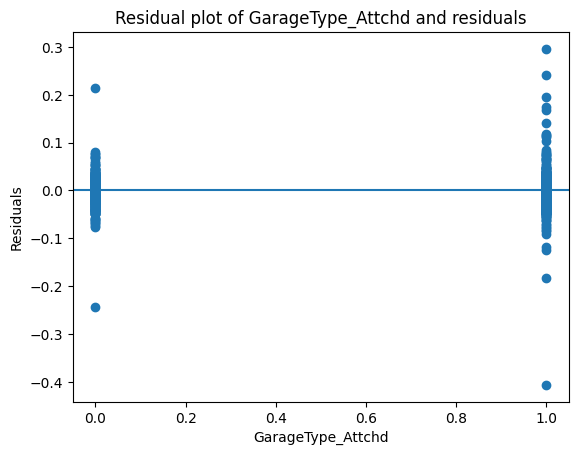

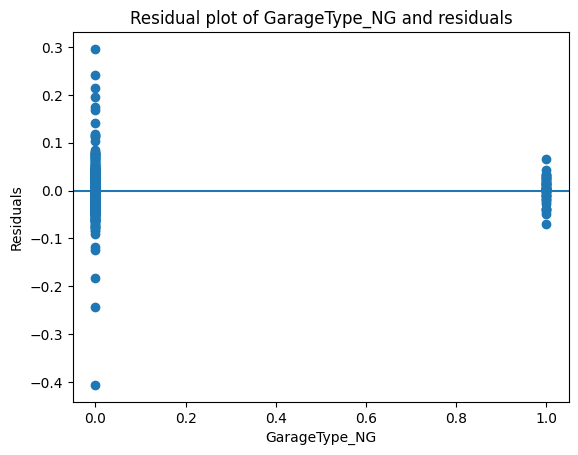

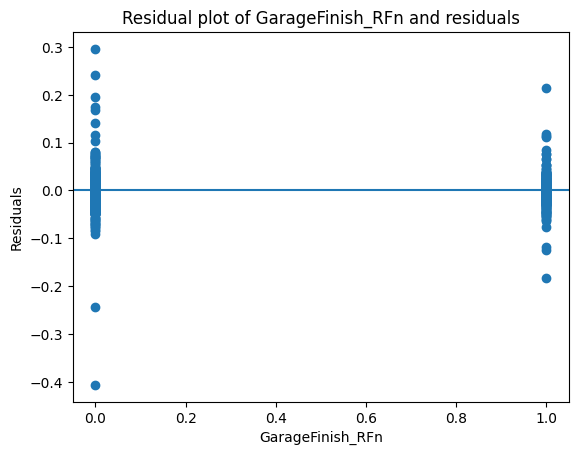

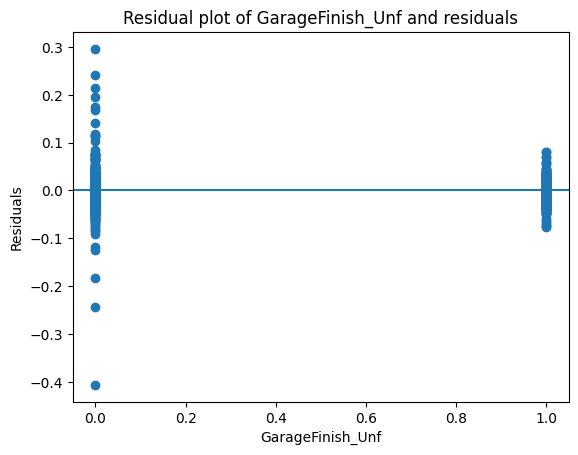

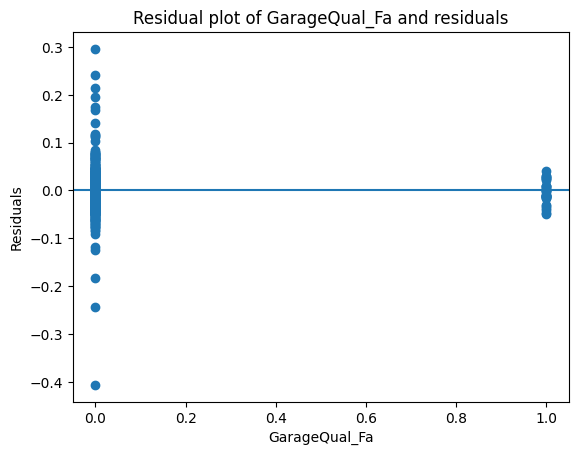

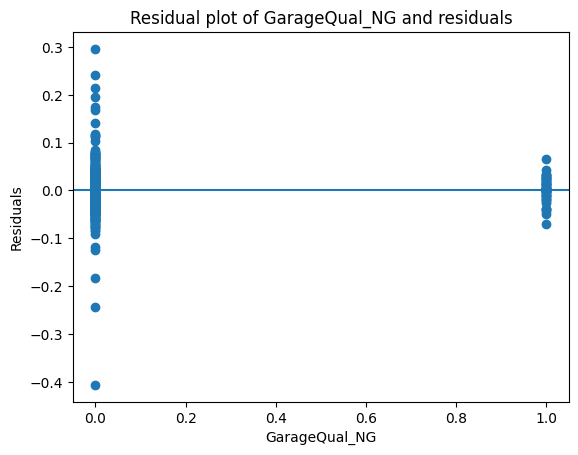

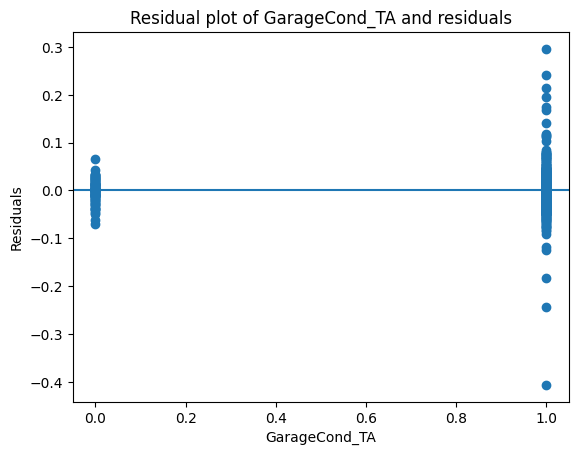

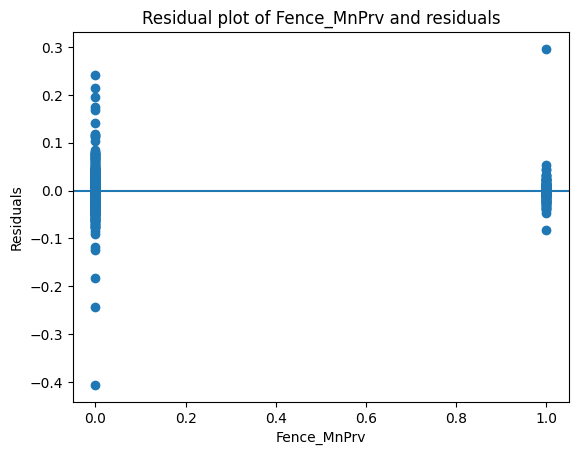

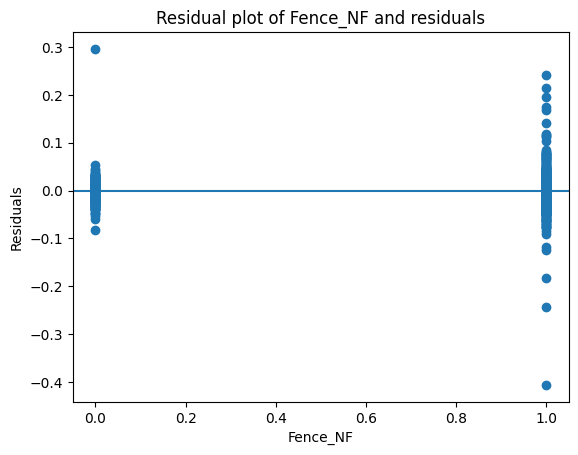

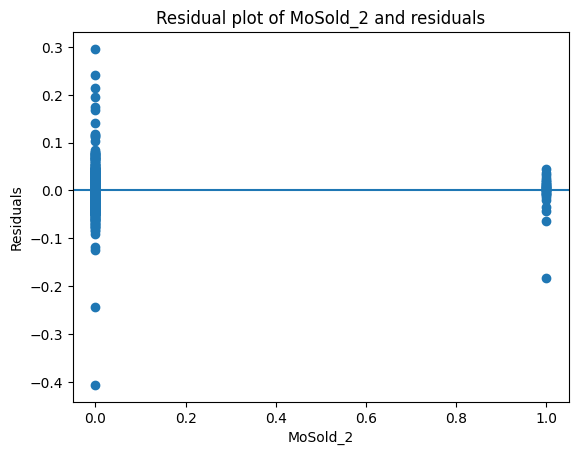

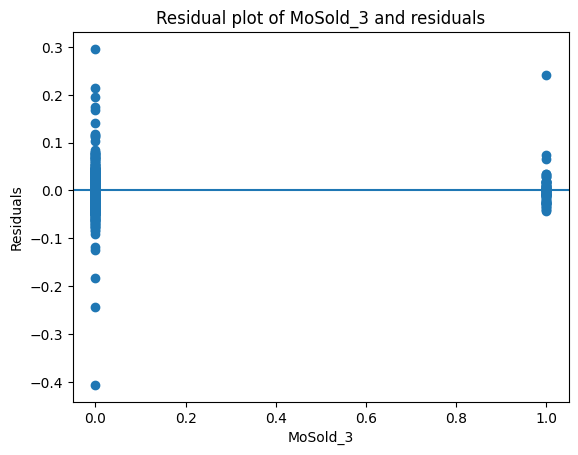

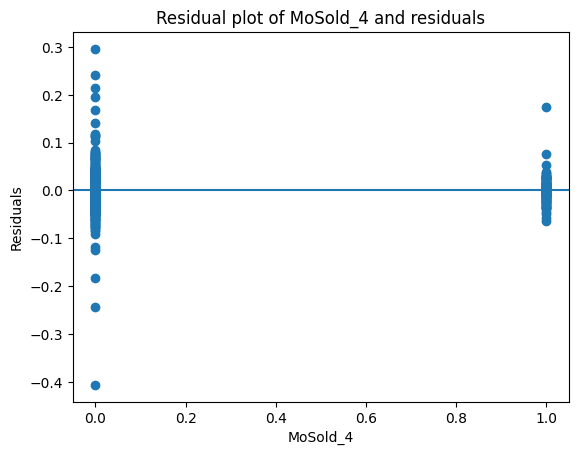

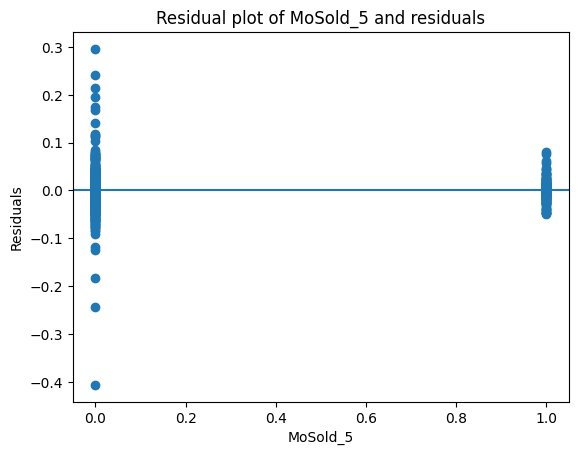

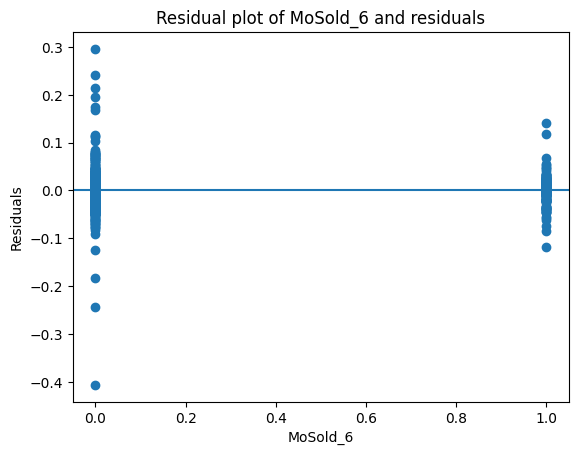

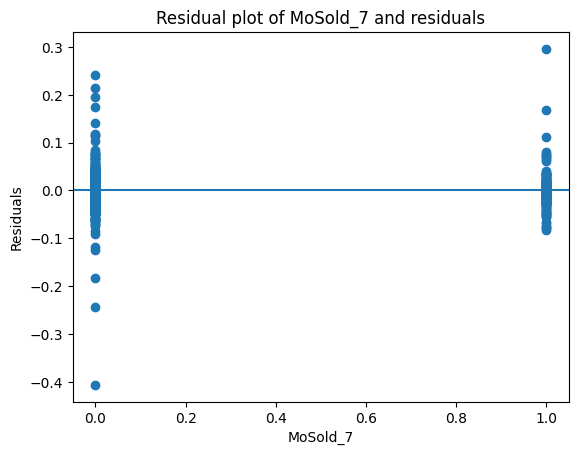

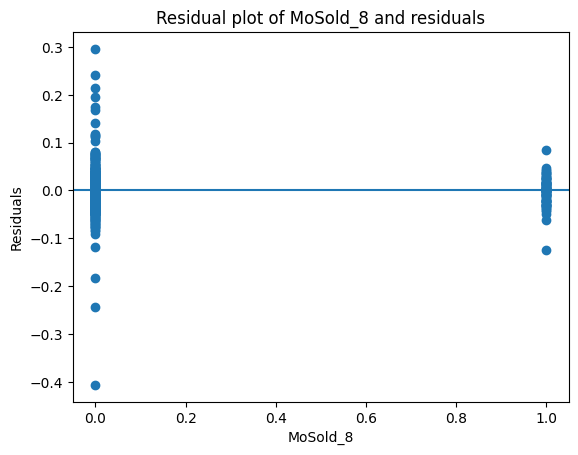

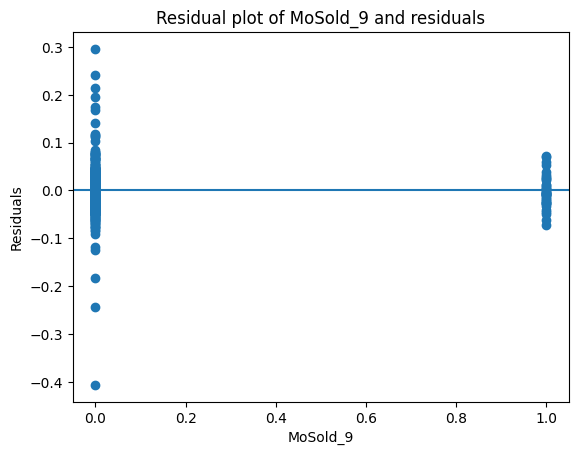

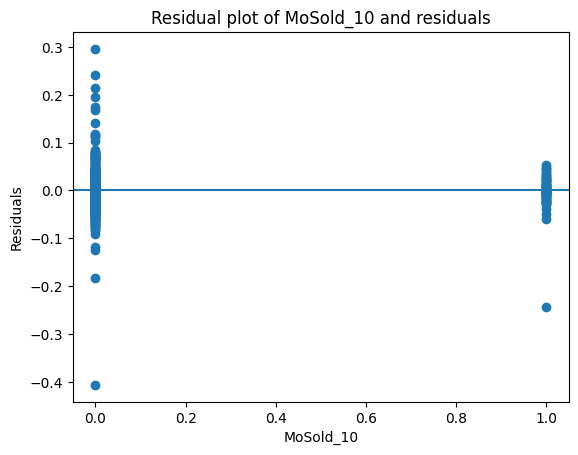

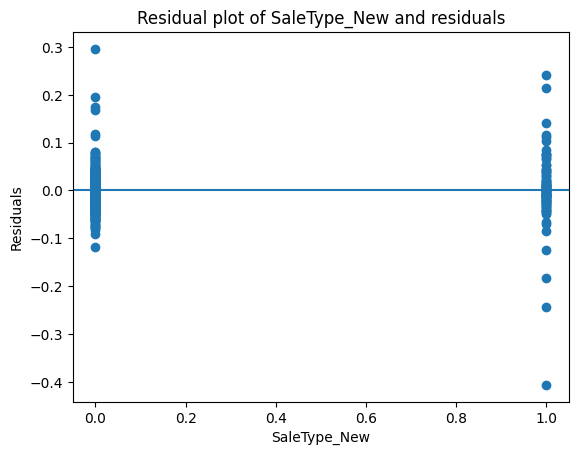

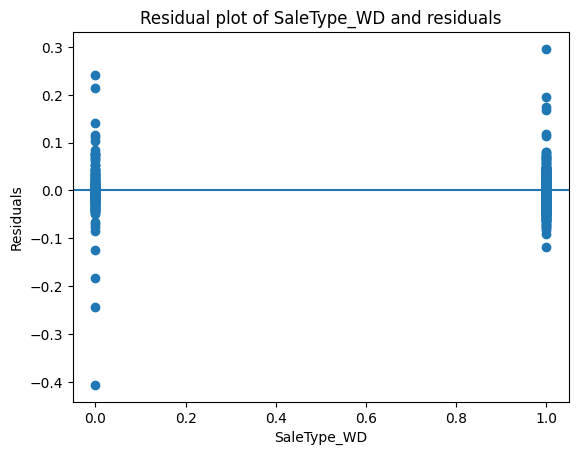

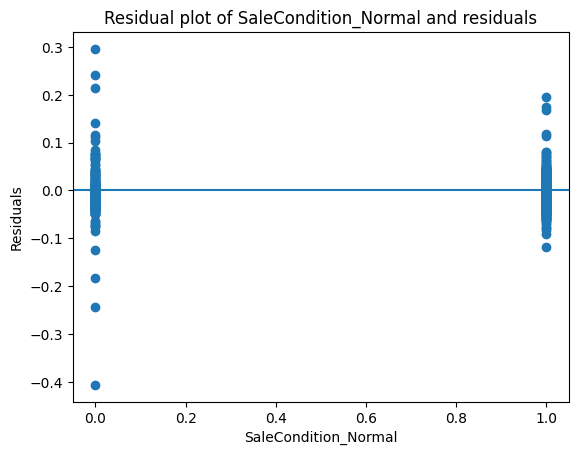

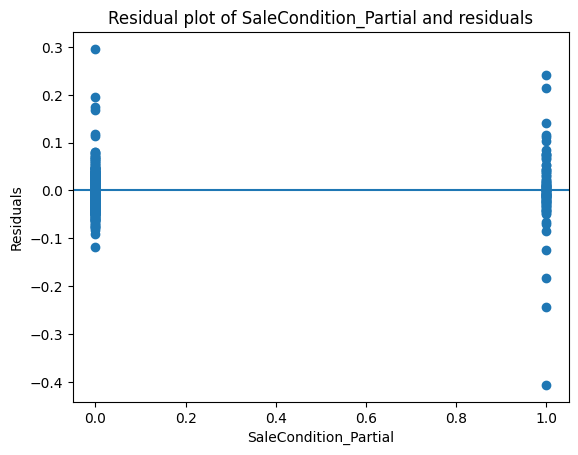

In [82]:
for predictor in selected_predictors:
    plt.figure()
    plt.scatter(X_train[predictor], res_lasso_mean_absolute_error)
    plt.axhline(y = 0)
    plt.xlabel(predictor)
    plt.ylabel('Residuals')
    plt.title('Residual plot of {0} and residuals'.format(predictor))
    plt.show()

#### The residual plots suggest that our model is doing fine. So, it will be our final model.